

# <font size="+3"><span style='color:#2994ff'> **P5 - Segmentez des clients d'un site e-commerce** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:

# ----------------
# Packages Update
# ----------------
# !pip install --upgrade pip
# !pip install geopandas
# !pip install folium
# !pip install pycodestyle
# !pip install flake8 pycodestyle_magic

# General libraries
import os
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
from pprint import pprint
import time
import datetime
from math import pi

# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import webbrowser
import scipy.stats as stats
import plotly as plotly
import plotly.express as px
from sklearn import manifold

# Data preprocessing
import sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Validation code PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

# Warnings
import warnings
from warnings import simplefilter
warnings.filterwarnings(action='once')
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ValueError)
simplefilter(action='ignore', category=UserWarning)


'''
# -------------------------------------------------------------
# Checking the version numbers of the installed packages
# -------------------------------------------------------------
'''
print('Librairies version : \n')

print('Pandas      : ' + pd.__version__)
print('Geopandas   : ' + gpd.__version__)
print('NumPy       : ' + np.version.full_version)
print('Csv         : ' + csv.__version__ + '\n')

print('Matplotlib  : ' + mpl.__version__)
print('Seaborn     : ' + sns.__version__ + '\n')
print('Folium      : ' + folium.__version__)


now = datetime.datetime.now().isoformat()
print('Launched on : ' + now)

Librairies version : 

Pandas      : 1.5.3
Geopandas   : 0.12.2
NumPy       : 1.23.5
Csv         : 1.0

Matplotlib  : 3.7.1
Seaborn     : 0.12.2

Folium      : 0.14.0
Launched on : 2023-04-14T07:45:47.346178



<a id='USED_PARAMETERS'></a>


<br>


---
---

<font size="+1"> **PARAMETERS USED IN THIS NOTEBOOK** </font>

---


In [2]:
# Parameters used in this notebook

seed = 84

palette4 = ["#253d85", "#618576", "#cba87d", "#faec4d"]

palette5 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#faec4d"]

palette6 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#dcd2a3", "#faec4d"]


<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---


In [3]:
%pycodestyle_off

In [4]:
# ---------------------
# Dataset description
# ---------------------

def complet_description(df):
    nb_row = df.index.size
    nb_col = df.columns.size
    Types = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    Null = pd.DataFrame(df.isna().sum()).T.rename(index={0:'null'})
    Duplicated = pd.DataFrame(df.shape[0]-df.isna().sum()-df.nunique())\
        .T.rename(index={0:'Duplicated'}) 
    PercCount = pd.DataFrame(100-100*(df.isna().sum())/nb_row).T\
        .rename(index={0:'Filling percentage'})
    Describe = df.describe(datetime_is_numeric=True, include='all')
    infor = pd.concat([Types,Null,Duplicated,PercCount, Describe],\
                       axis =0).T.sort_values("Filling percentage")\
                       .reset_index() 
    infor = infor.rename(columns={"index":"Variable"})
    return infor


In [5]:
# ---------------------------------------------
#  DESCRIPTION OF CATEGORICAL VARIABLES
# ---------------------------------------------

def univ_cate_vari(dataframe, feature, tableau=True, graphDistsrib=True):

    """
     Displays the frequency table and a bar graph with the frequency
     of the words
    @Params IN : 
        dataframe : DataFrame, required
        feature : categorical variables to be analyzed, required
        tableau : booléen, True = displays the frequency table
        graphDistsrib : booléen,  True = displays the percentage distribution
        graph"""

    if tableau:
        df = dataframe[feature].value_counts().to_frame().reset_index()
        df = df.rename(columns={'index':feature, feature:'num_entries'})
        df['Frequency_%'] = 100*df['num_entries']/((dataframe.shape[0]))
        display(df.head(10).style.hide(axis="index"))

    if graphDistsrib:
        plt.figure(figsize=(4,6))
        df_graph = df.sort_values('Frequency_%', ascending=False).head(20)
        sns.barplot(data= df_graph, x= 'Frequency_%', y= feature ,\
                    palette = "light:b_r")
        plt.title("Distribution of " + feature)
        plt.show()

In [6]:
# -------------------------------------------------------
# Univariate graphical analysis - quantitative features
# -------------------------------------------------------

def univ_quantit(list_feat, df_feat):

    """ GRAPHICAL ANALYSIS OF QUANTITATIVE FEATURES
        Box plot, hystogram & QQ-plot
        -----------------------------
        @param IN :
          list_feat : list of quantitative variables to be analyzed, required
          df_feat : dataframe with the quantitative variables to be analyzed,
                    required
        @param OUT : None
        """

    nombre_Graphs = len(list_feat)

    columns = 3  # number of columns
    rows = nombre_Graphs  # number of rows
    pc = 1  # initialization of the plot counter

    fig = plt.figure(figsize=(15, (4.5*nombre_Graphs)))

    for feat in range(nombre_Graphs):
        plt.subplot(rows, columns, pc)
        sns.boxplot(data=df_feat, y=list_feat[feat], color='SteelBlue')
        plt.ylabel(list_feat[feat])
        pc = pc + 1

        plt.subplot(rows, columns, pc)
        sns.histplot(data=df_feat, x=list_feat[feat],
                     color="SteelBlue", kde=True)
        plt.xlabel(list_feat[feat])
        plt.axvline(x=df_feat[list_feat[feat]].mean(),
                    color="r", label="mean")
        plt.axvline(x=df_feat[list_feat[feat]].median(),
                    color="y", ls="--", lw=2, label="median")
        plt.axvline(x=df_feat[list_feat[feat]].mode()[0],
                    color="g", ls=":", lw=2, label="mode")
        plt.legend(bbox_to_anchor=(1.0, 1), loc="upper left")
        pc = pc + 1

        plt.subplot(rows, columns, pc)
        stats.probplot(df_feat[list_feat[feat]], dist="norm", plot=plt)
        plt.title("Probability Plot")
        pc = pc + 1

    plt.tight_layout()
    plt.show()

In [7]:
# -------------------
# Boxplot categories
# -------------------

def groups_boxplot(df, groupby):
    """
    df : dataframe whith the data to plot
    groupby : Name of the series to plot
    """
    fig, axs = plt.subplots(3, 1, figsize=(14, 4))
    fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05,
                        top=3, hspace=0.4, wspace=0.3)
    # Boxplot Recency
    sns.boxplot(x=groupby, y="Recency", data=df,
                color="#2994ff", ax=axs[0])
    axs[0].set_title("Recency")

    # Boxplot Frequency
    sns.boxplot(x=groupby, y="Frequency", data=df,
                color="#2994ff", ax=axs[1])
    axs[1].set_title("Frequency")

    # Boxplot Monetary
    sns.boxplot(x=groupby, y="Monetary", data=df,
                color="#2994ff", ax=axs[2])
    axs[2].set_title("Monetary")

    plt.show()

In [8]:
# --------------
# Radar charts
# --------------

def make_spider(df, row, title, color):
    """Define a function that do a plot for one line of the dataset
    ##Parameters:
        * df = dataframe for radarchart
        * row = number of rows
        * title = subplot titles
        * color = color palette
    """

    # number of variable
    categories = list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    # number of columns
    n_columns = 5
    # number of rows
    n_rows = (int(round(len(df.index.tolist())/5, 0)))+1
    ax = plt.subplot(n_rows, n_columns, row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    lim_y = round(df.iloc[:, 1].max())
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=7)
    plt.ylim(0, lim_y)

    # Ind1
    values = df.loc[row].drop(df.columns[0]).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
    plt.tight_layout


<font size="+3"><span style='color:#2994ff'> **P5 - Segmentez des clients d'un site e-commerce** </span></font>



This notebook is part of the customer segmentation project of the **olist** e-commerce site.
 <center><img src="./img/logo_olist.png" style="height: 100px;"/></center>

The objective is to understand the different types of users through their behaviour and personal data.<br>
The following is [the source of the data](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).<br>

For this purpose **olist requests** :
 * Provide a customer segmentation that they can use on a daily basis for their communication campaigns
 * Provide the marketing team an actionable description of your segmentation and its underlying logic for optimal use
 * Provide a maintenance contract proposal based on an analysis of the stability of the segments over time

---
---

**This notebook** includes **data cleaning and exploratory analysis**.<br>



## <font color = '#0085dd'>**Table of content**</font>


[Librairies loading](#LOADING_LIBRARIES)<br>

[Functions used in this notebook](#USED_FUNCTIONS)<br>

---

[**Datasets**](#datasets)
 * [Description](#datasets_description)
   * [orders_dataset](#orders_dataset)
   * [customers_dataset](#customers_dataset)
   * [order_items](#order_items)
   * [products_dataset](#products_dataset)
   * [product_category_name_translation](#product_category_name_translation)   
   * [sellers_dataset](#sellers_dataset)
   * [order_payments](#order_payments)
   * [order_reviews](#order_reviews)
   * [geolocation_dataset](#geolocation_dataset)<br> 
<br>
 * [Columns preparation](#columns_preparation)
   * [Zip codes centroids calculation](#centroid_zipCode)
   * [Product category check and update](#cat_products)   
   
   
[**Datasets joining**](#datasets_joining)
 * [Data description](#data_description)
 * [Evaluation of missing values](#missing_values)  
 * [Column filling analysis](#column_fill)   
 * [Row filling analysis](#row_filling)  
 * [Features pre-selection](#features_preSelection)

[**Features engineering**](#features_engineering)
 * [Customers spatial distribution](#customers_spatial_distribution)
 * [RFM features](#RFM_features)  
 * [Products](#products)   
 * [Orders](#Orders)  
 * [Dates](#dates)
 * [Joining customers information](#join_customers_datasets)
 * [Features analysis](#features_analysis)  

[**Dataset for segmentation**](#segmentation_dataset)
<br>

---


<a id='datasets'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Datasets** </span></span>


In [9]:
# Define the folder containing the files with the project data
P5_source = "/home/raquelsp/Documents/Openclassrooms/P5_segment_clients_eComerc/P5_travail/P5_source/9_fichiers"

os.chdir(P5_source)

# .csv files number and name
allFilesCsv = glob.glob('*.csv')

print("The data is divided into : " + str(len(allFilesCsv)) + " datasets.\n")
pprint("The available dataset are : " + str(allFilesCsv))

The data is divided into : 9 datasets.

("The available dataset are : ['olist_order_reviews_dataset.csv', "
 "'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', "
 "'olist_products_dataset.csv', 'olist_sellers_dataset.csv', "
 "'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', "
 "'product_category_name_translation.csv', 'olist_order_payments_dataset.csv']")


<a id='datasets_description'></a>

## <span style='background:#0085dd'><span style='color:white'>Description</span></span>


<a id='orders_dataset'></a>

---
### <span style='background:#0075bc'><span style='color:white'>orders_dataset</span></span>


In [10]:
# -----------------------------
# File upload: orders_dataset
# -----------------------------
# linked to ORDER_CUSTOMER by 'customer_id'
# linked to ORDER_ITEMS by 'order_id'
# linked to ORDER_REVIEWS by 'order_id'
orders_dataset = pd.read_csv('olist_orders_dataset.csv', low_memory=False,
                             encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'orders_dataset' contains " +
      str(orders_dataset.shape[0]) + " rows and " +
      str(orders_dataset.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
# pd.options.display.max_columns = None
orders_dataset.head(3)

The dataset 'orders_dataset' contains 99441 rows and 8 columns.



order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00

In [11]:
# --------------------
# Column description
# --------------------
complet_description(orders_dataset)

Variable    Type  null Duplicated Filling percentage  \
0  order_delivered_customer_date  object  2965        812          97.018332   
1   order_delivered_carrier_date  object  1783      16640          98.206977   
2              order_approved_at  object   160       8548          99.839101   
3                       order_id  object     0          0              100.0   
4                    customer_id  object     0          0              100.0   
5                   order_status  object     0      99433              100.0   
6       order_purchase_timestamp  object     0        566              100.0   
7  order_estimated_delivery_date  object     0      98982              100.0   

   count unique                               top   freq  
0  96476  95664               2018-05-08 23:38:46      3  
1  97658  81018               2018-05-09 15:48:00     47  
2  99281  90733               2018-02-27 04:31:10      9  
3  99441  99441  e481f51cbdc54678b7cc49136f2d6af7      1  
4  99441  99441  9ef432eb6251297304e76186b10a928d      1  
5  99441      8                         delivered  96478  
6  99441  98875               2018-04-11 10:48:14      3  
7  99441    459               2017-12-20 00:00:00    522

**The columns that refer to dates must be casted to Datetime type.**

<span style='color:#00547a'>**Features comprenhension**</span>

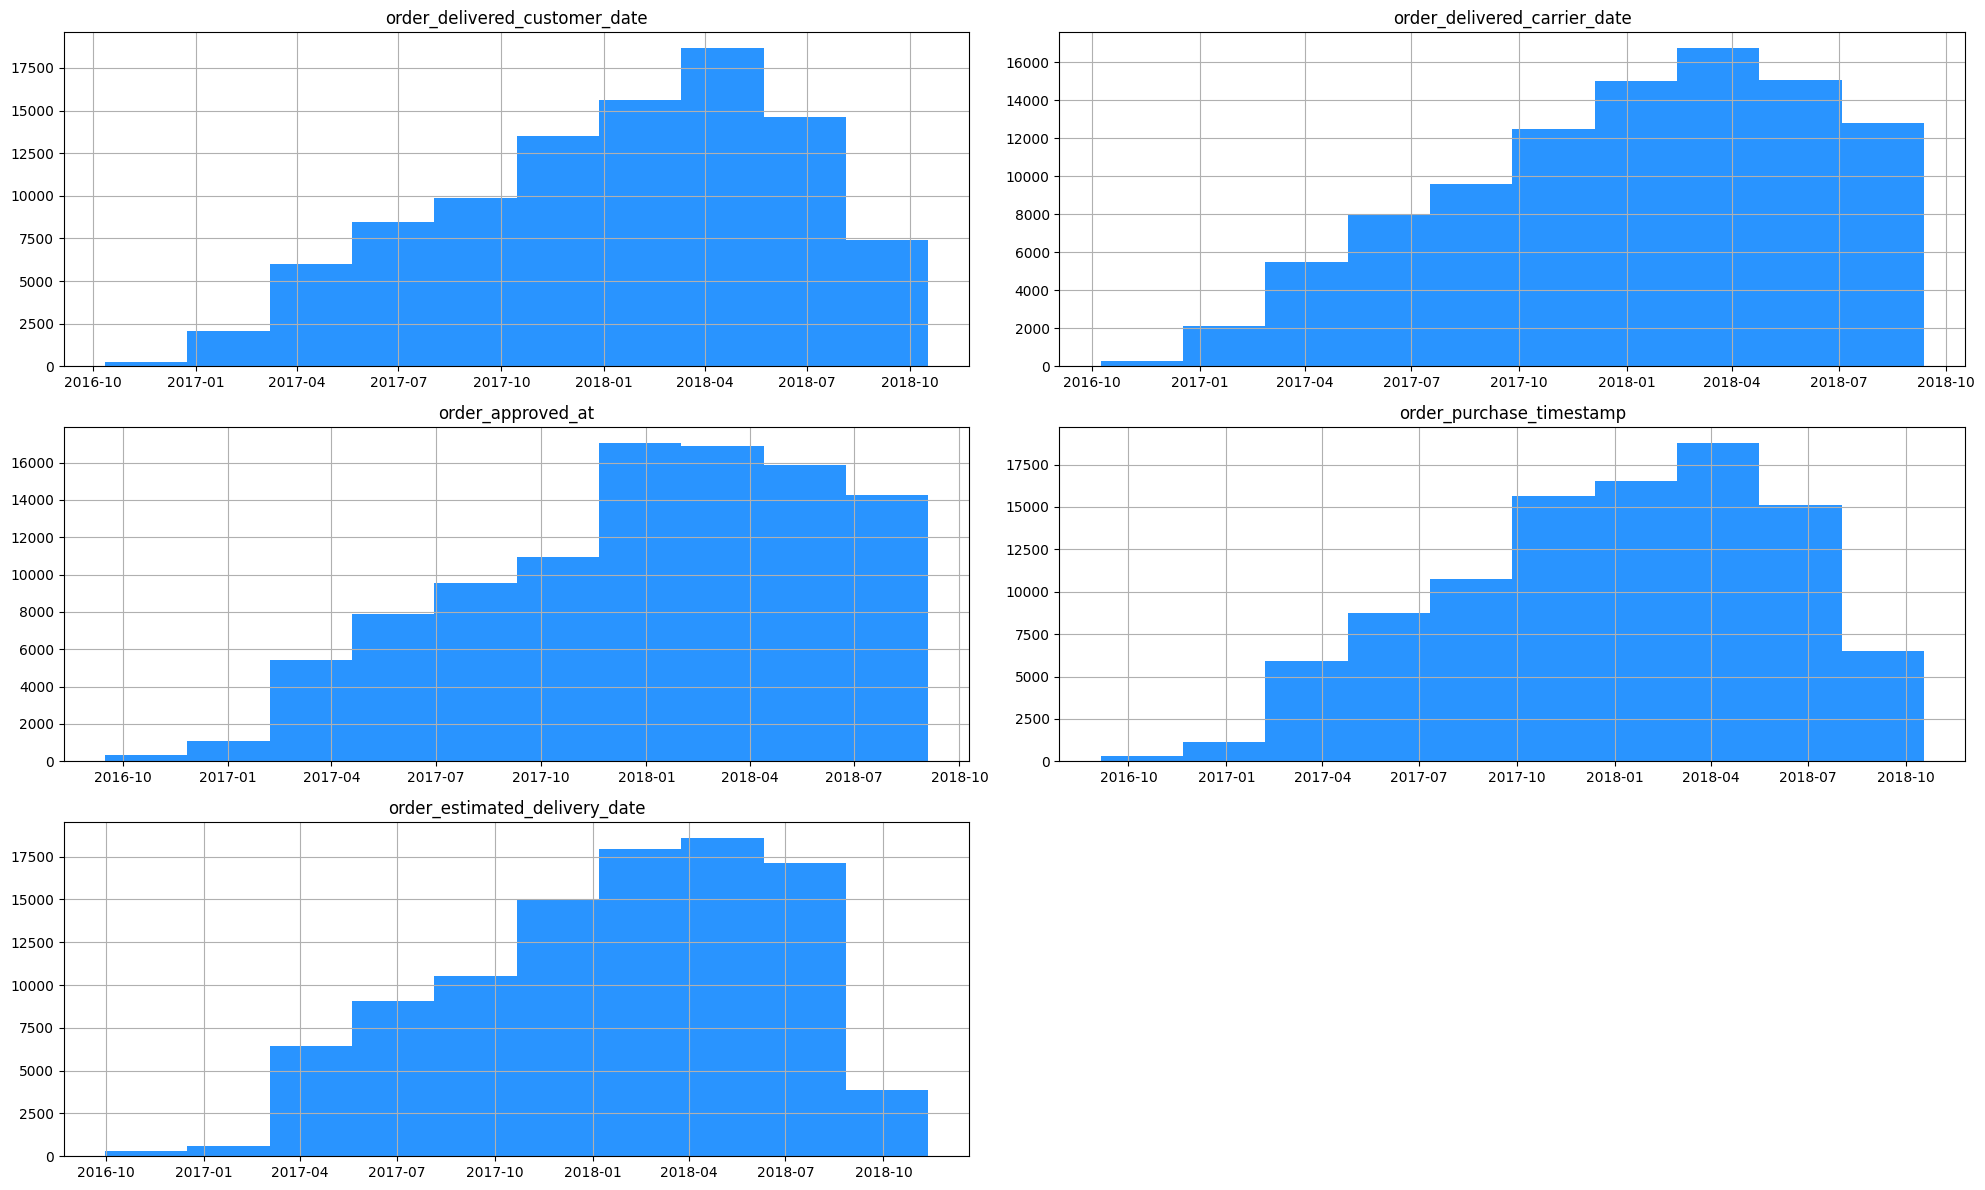

In [12]:
# Date time information
# ----------------------
orders_dataset['order_delivered_customer_date'] = pd.to_datetime(
    orders_dataset['order_delivered_customer_date'], utc=True)
orders_dataset['order_delivered_carrier_date'] = pd.to_datetime(
    orders_dataset['order_delivered_carrier_date'], utc=True)
orders_dataset['order_approved_at'] = pd.to_datetime(
    orders_dataset['order_approved_at'], utc=True)
orders_dataset['order_purchase_timestamp'] = pd.to_datetime(
    orders_dataset['order_purchase_timestamp'], utc=True)
orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(
    orders_dataset['order_estimated_delivery_date'], utc=True)

# Date features analysis
# ------------------------
df_date_orders = orders_dataset[["order_delivered_customer_date",
                                 "order_delivered_carrier_date",
                                 "order_approved_at",
                                 "order_purchase_timestamp",
                                 "order_estimated_delivery_date"]]
df_date_orders.hist(bins=10, figsize=(20, 12), color="#2994ff")
plt.tight_layout()
plt.show()

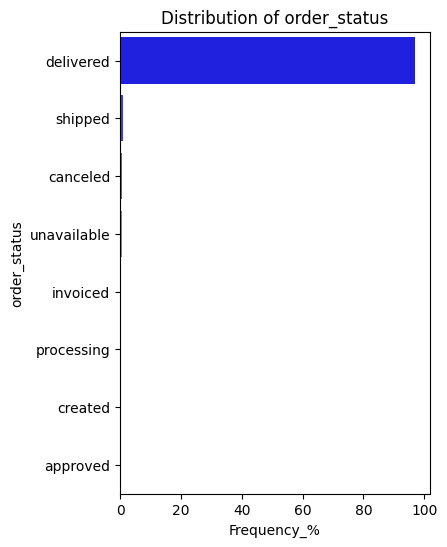

In [13]:
# Oder status
# -------------
univ_cate_vari(orders_dataset, "order_status")

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

The **orders_dataset** informs about the orders.
The dataset informs about 99441 orders.

The variables *order_id* and *customer_id* contain unique pairs of values that characterize orders and customers.
* **order_id** allows to link all information about products, sellers, and order dates
* **customer_id** allows to link to all the information about consumers
* The most frequent **order_status** is delivered
The dates are between October 2016 and October 2018, except for delivery that includes some data in January 2020.the dates are between October 2016 and October 2018.

<a id='customers_dataset'></a>

---
### <span style='background:#0075bc'><span style='color:white'>customers_dataset</span></span>

In [14]:
# -------------------------------
# File upload: customers_dataset
# -------------------------------
# linked to ORDERS by 'customer_id'
# linked to GEOLOCATION by 'zip_code_prefix'
customers_dataset = pd.read_csv('olist_customers_dataset.csv',
                                low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'customers_dataset' contains " +
      str(customers_dataset.shape[0]) + " rows and " +
      str(customers_dataset.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
customers_dataset.head(3)

The dataset 'customers_dataset' contains 99441 rows and 5 columns.



customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP

In [15]:
# --------------------
# Column description
# --------------------
complet_description(customers_dataset)

Variable    Type null Duplicated Filling percentage  \
0               customer_id  object    0          0              100.0   
1        customer_unique_id  object    0       3345              100.0   
2  customer_zip_code_prefix   int64    0      84447              100.0   
3             customer_city  object    0      95322              100.0   
4            customer_state  object    0      99414              100.0   

     count unique                               top   freq          mean  \
0    99441  99441  06b8999e2fba1a1fbc88172c00ba8bc7      1           NaN   
1    99441  96096  8d50f5eadf50201ccdcedfb9e2ac8455     17           NaN   
2  99441.0    NaN                               NaN    NaN  35137.474583   
3    99441   4119                         sao paulo  15540           NaN   
4    99441     27                                SP  41746           NaN   

            std     min      25%      50%      75%      max  
0           NaN     NaN      NaN      NaN      NaN      NaN  
1           NaN     NaN      NaN      NaN      NaN      NaN  
2  29797.938996  1003.0  11347.0  24416.0  58900.0  99990.0  
3           NaN     NaN      NaN      NaN      NaN      NaN  
4           NaN     NaN      NaN      NaN      NaN      NaN

<span style='color:#00547a'>**Features comprenhension**</span>

In [16]:
# -----------------------------------------------
# Number of customers_id per customer_unique_id
# -----------------------------------------------
df_orders_per_customer = pd.DataFrame(customers_dataset
                                      .groupby("customer_unique_id")
                                      ["customer_id"].count()
                                      .sort_values(ascending=False))\
                                      .reset_index()
df_orders_per_customer = df_orders_per_customer\
    .rename(columns={"customer_id" : "num_orders"})
df_orders_per_customer.tail(10)

customer_unique_id  num_orders
96086  565b64d5eccb92927eef430de8df9047           1
96087  565af81202a1fb8a9ffe282935381142           1
96088  56583a02df6f603c331a575f4f63ec6b           1
96089  565811ed44e539a14bc391cf57373ed1           1
96090  5657f9f721c16800a66c21081d46b18d           1
96091  5657dfebff5868c4dc7e8355fea865c4           1
96092  5657596addb4d7b07b32cd330614bdf8           1
96093  5656eb169546146caeab56c3ffc3d268           1
96094  5656a8fabc8629ff96b2bc14f8c09a27           1
96095  ffffd2657e2aad2907e67c3e9daecbeb           1

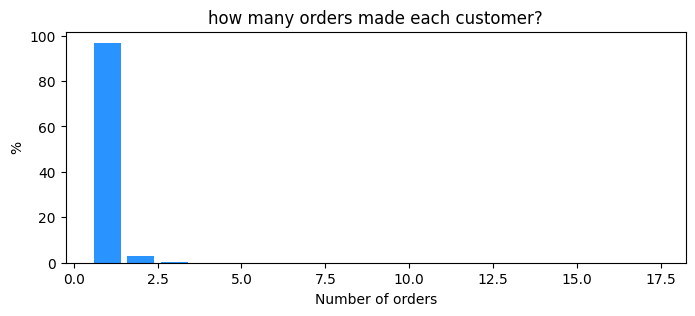

In [17]:
# -------------------------------------
# how many orders made each customer?
# -------------------------------------
df_percent_customer_orders = pd.DataFrame(df_orders_per_customer
                                          .groupby("num_orders")
                                          ["customer_unique_id"].count()
                                          .reset_index())\
                                          .rename(columns=
                                                  {"customer_unique_id":
                                                   "num_customers"})
df_percent_customer_orders["Percent of customers"] = \
                            df_percent_customer_orders["num_customers"]*100\
                            / df_orders_per_customer.shape[0]
df_percent_customer_orders

# Visualization
# --------------
fig, ax = plt.subplots(figsize=(8, 3))

ax.bar(df_percent_customer_orders["num_orders"],
       df_percent_customer_orders["Percent of customers"], color="#2994ff")
ax.set_ylabel("%")
ax.set_xlabel("Number of orders")
ax.set_title("how many orders made each customer?")
plt.tight_layout
plt.show()

%pycodestyle_off

In [18]:
# ------------------------------
# Number of orders per zip_code
# ------------------------------
df_orders_zipCode = pd.DataFrame(customers_dataset
                                 .groupby("customer_zip_code_prefix")
                                 ["customer_id"].count()
                                 .sort_values(ascending=False))\
                                 .reset_index()
df_orders_zipCode = df_orders_zipCode\
                            .rename(columns={"customer_id" : "num_orders"})
df_orders_zipCode.head(3)

customer_zip_code_prefix  num_orders
0                     22790         142
1                     24220         124
2                     22793         121

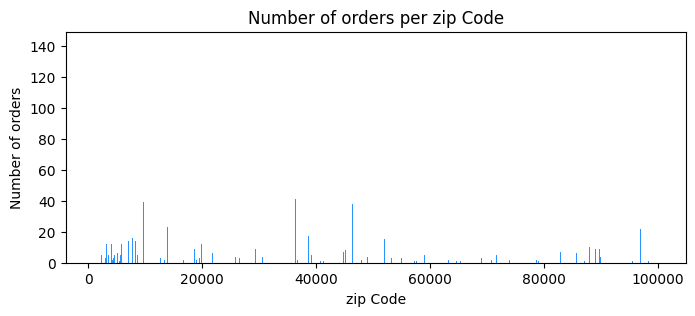

In [19]:
# -----------------------------------
# Orders per zip code visualization
# -----------------------------------
fig, ax = plt.subplots(figsize=(8, 3))

ax.bar(df_orders_zipCode["customer_zip_code_prefix"],
       df_orders_zipCode["num_orders"], color="#2994ff")
ax.set_ylabel("Number of orders")
ax.set_xlabel("zip Code")
ax.set_title("Number of orders per zip Code")
plt.tight_layout
plt.show()

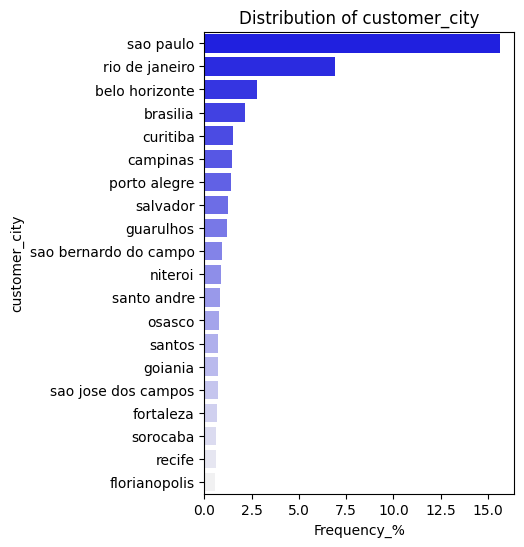

In [20]:
# Customers city
# ---------------
univ_cate_vari(customers_dataset, "customer_city")

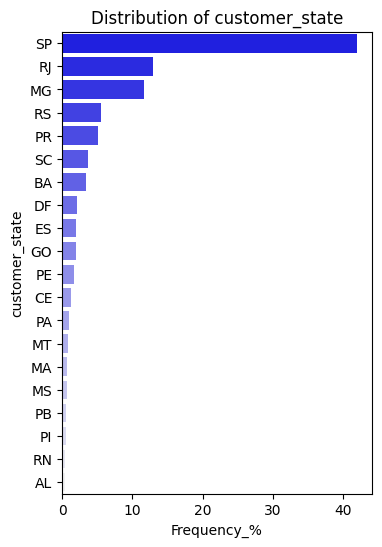

In [21]:
# Customers state
# ----------------
univ_cate_vari(customers_dataset, "customer_state")

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

* **customer_unique_id** is the unique identifier for each customer.<br>
* When a customer places an order a **customer_id** is associated to it, which allows to link the order information with the customer's information.<br>
* There can be several *customer_id* associated to a *customer_unique_id*.<br>
   * Most customers have only ordered once.
   * Keep the variable, number of orders per customer: **num_orders**<br><br>
   

* More than 20% of orders come from people in Sao Paulo and Rio de Janeiro cities.
* More than 51% of orders come from people in Sao Paulo and Rio de Janeiro states.

The **zip_code** must be transformed into a categorical variable.<br>
The spelling should be homogenized in the variables **customer_city** and **customer_state**.<br>

<a id='order_items'></a>

---
### <span style='background:#0075bc'><span style='color:white'>order_items</span></span>

In [22]:

# --------------------------
# File upload: order_items
# --------------------------
# linked to PRODUCTS by 'product_id'
# linked to ORDERS by 'order_id'
# linked to SELLERS by 'seller_id'
order_items = pd.read_csv("olist_order_items_dataset.csv",
                          low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'products_dataset' contains " +
      str(order_items.shape[0]) + " rows and " +
      str(order_items.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
# pd.options.display.max_columns = None
order_items.head(3)

The dataset 'products_dataset' contains 112650 rows and 7 columns.



order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
2  2018-01-18 14:48:30  199.0          17.87

In [23]:
# --------------------
# Column description
# --------------------
complet_description(order_items)

Variable     Type null Duplicated Filling percentage     count  \
0             order_id   object    0      13984              100.0    112650   
1        order_item_id    int64    0     112629              100.0  112650.0   
2           product_id   object    0      79699              100.0    112650   
3            seller_id   object    0     109555              100.0    112650   
4  shipping_limit_date   object    0      19332              100.0    112650   
5                price  float64    0     106682              100.0  112650.0   
6        freight_value  float64    0     105651              100.0  112650.0   

  unique                               top  freq        mean         std  \
0  98666  8272b63d03f5f79c56e9e4120aec44ef    21         NaN         NaN   
1    NaN                               NaN   NaN    1.197834    0.705124   
2  32951  aca2eb7d00ea1a7b8ebd4e68314663af   527         NaN         NaN   
3   3095  6560211a19b47992c3666cc44a7e94c0  2033         NaN         NaN   
4  93318               2017-07-21 18:25:23    21         NaN         NaN   
5    NaN                               NaN   NaN  120.653739  183.633928   
6    NaN                               NaN   NaN    19.99032   15.806405   

    min    25%    50%    75%     max  
0   NaN    NaN    NaN    NaN     NaN  
1   1.0    1.0    1.0    1.0    21.0  
2   NaN    NaN    NaN    NaN     NaN  
3   NaN    NaN    NaN    NaN     NaN  
4   NaN    NaN    NaN    NaN     NaN  
5  0.85   39.9  74.99  134.9  6735.0  
6   0.0  13.08  16.26  21.15  409.68

**The columns that refer to dates must be casted to Datetime type.**

<span style='color:#00547a'>**Features comprenhension**</span>

In [24]:
# -----------------------------------------
# how many sellers are involved in orders
# -----------------------------------------
df_orders_per_seller = pd.DataFrame(order_items.groupby('order_id')
                                    ['seller_id'].count()
                                    .sort_values(ascending=False))\
                                    .reset_index().rename(columns=\
                                                {"seller_id" : "num_sellers"})

# -----------------------------------------
# how many sellers are involved in orders
# -----------------------------------------
df_percent_seller_orders = pd.DataFrame(df_orders_per_seller
                                        .groupby("num_sellers")
                                        ["order_id"].count().reset_index())\
                                        .rename(columns =\
                                                {"order_id" : "num_orders"})
df_percent_seller_orders["Percent of orders"] = \
    df_percent_seller_orders["num_orders"]*100\
        / df_orders_per_seller.shape[0]
df_percent_seller_orders.head(5)


num_sellers  num_orders  Percent of orders
0            1       88863          90.064460
1            2        7516           7.617619
2            3        1322           1.339874
3            4         505           0.511828
4            5         204           0.206758

In [25]:
df_percent_seller_orders.tail(5)

num_sellers  num_orders  Percent of orders
12           13           1           0.001014
13           14           2           0.002027
14           15           2           0.002027
15           20           2           0.002027
16           21           1           0.001014

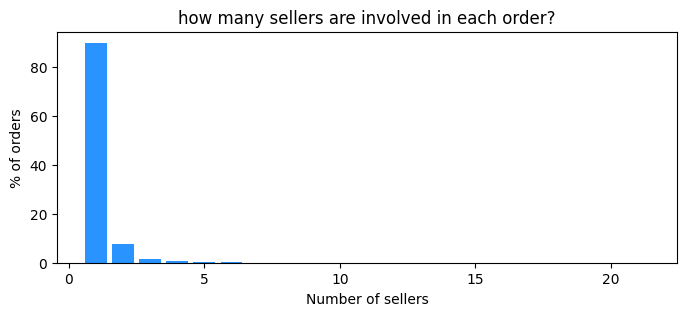

In [26]:
# Visualization
# --------------
fig, ax = plt.subplots(figsize=(8, 3))

ax.bar(df_percent_seller_orders["num_sellers"],
       df_percent_seller_orders["Percent of orders"], color="#2994ff")
ax.set_ylabel("% of orders")
ax.set_xlabel("Number of sellers")
ax.set_title("how many sellers are involved in each order?")
plt.tight_layout
plt.show()

In [27]:
# ----------------------------------
# how many items are in each order
# ----------------------------------
df_items_per_order = pd.DataFrame(order_items.groupby('order_id')
                                  ['order_item_id'].max()
                                  .sort_values(ascending=False))\
                                  .reset_index().rename(columns=
                                                {"order_item_id":"num_items"})

df_percent_items_per_order = pd.DataFrame(df_items_per_order
                                          .groupby("num_items")
                                          ["order_id"].count()
                                          .reset_index()).rename(columns=\
                                                    {"order_id":"num_orders"})
df_percent_items_per_order["Percent of orders"] = \
    df_percent_items_per_order["num_orders"]*100\
        / df_items_per_order.shape[0]
df_percent_items_per_order.head(5)

num_items  num_orders  Percent of orders
0          1       88863          90.064460
1          2        7516           7.617619
2          3        1322           1.339874
3          4         505           0.511828
4          5         204           0.206758

In [28]:
df_percent_items_per_order.tail(5)

num_items  num_orders  Percent of orders
12         13           1           0.001014
13         14           2           0.002027
14         15           2           0.002027
15         20           2           0.002027
16         21           1           0.001014

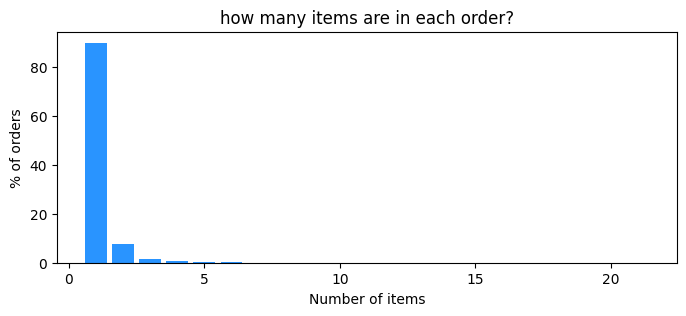

In [29]:
# Visualization
# --------------
fig, ax = plt.subplots(figsize=(8, 3))

ax.bar(df_percent_items_per_order["num_items"],
       df_percent_items_per_order["Percent of orders"], color="#2994ff")
ax.set_ylabel("% of orders")
ax.set_xlabel("Number of items")
ax.set_title("how many items are in each order?")
plt.tight_layout
plt.show()

In [30]:
# ----------------------------------
# how many products are in each order
# ----------------------------------
df_products_per_order = pd.DataFrame(order_items.groupby('order_id')
                                     ['product_id'].count()
                                     .sort_values(ascending=False))\
                                     .reset_index().rename(columns=
                                                {"product_id":"num_products"})

df_percent_orders_product = pd.DataFrame(df_products_per_order
                                         .groupby("num_products")
                                         ["order_id"].count().reset_index())\
                                         .rename(columns=\
                                                 {"order_id":"num_orders"})
df_percent_orders_product["Percent of orders"] = \
    df_percent_orders_product["num_orders"]*100\
        / df_products_per_order.shape[0]
df_percent_orders_product.head(5)

num_products  num_orders  Percent of orders
0             1       88863          90.064460
1             2        7516           7.617619
2             3        1322           1.339874
3             4         505           0.511828
4             5         204           0.206758

In [31]:
df_percent_orders_product.tail(5)

num_products  num_orders  Percent of orders
12            13           1           0.001014
13            14           2           0.002027
14            15           2           0.002027
15            20           2           0.002027
16            21           1           0.001014

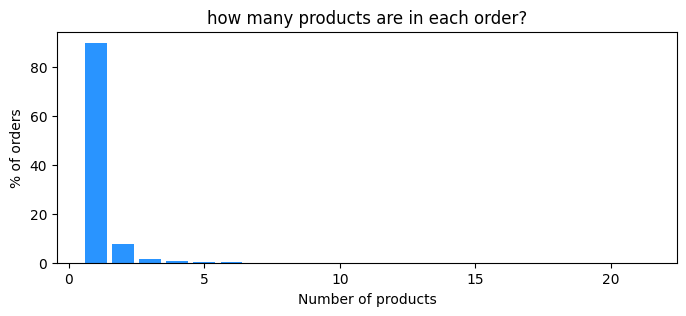

In [32]:

# Visualization
# --------------
fig, ax = plt.subplots(figsize=(8, 3))

ax.bar(df_percent_orders_product["num_products"],
       df_percent_orders_product["Percent of orders"], color="#2994ff")
ax.set_ylabel("% of orders")
ax.set_xlabel("Number of products")
ax.set_title("how many products are in each order?")
plt.tight_layout
plt.show()

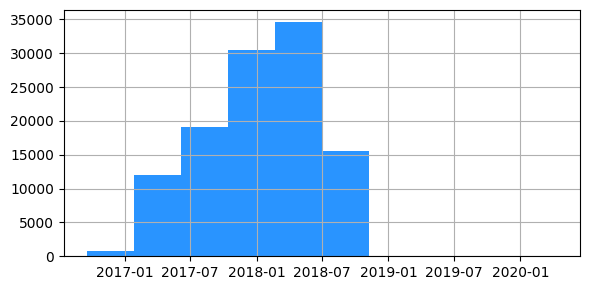

In [33]:
# ----------------------
# Date time information
# ----------------------
order_items["shipping_limit_date"] = pd.to_datetime(
    order_items["shipping_limit_date"], utc=True)

# Visualization
# ------------------------
order_items["shipping_limit_date"].hist(bins=10, figsize=(6, 3),
                                        color="#2994ff")
plt.tight_layout()
plt.show()

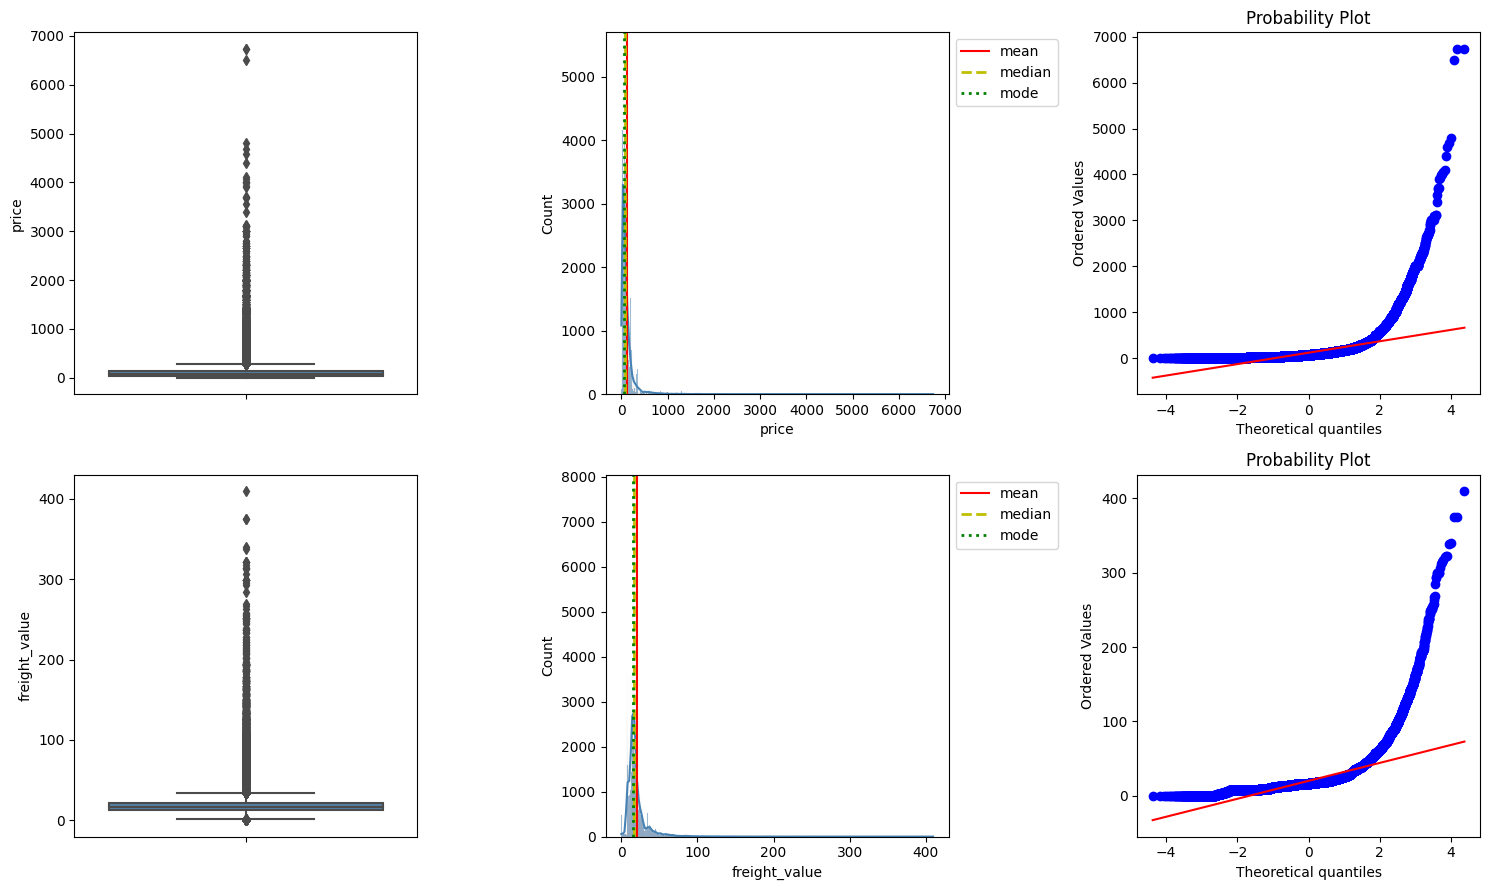

In [34]:
# -----------------------
# Product cuantitative
# -----------------------
df_product_cuanti = order_items[["price", "freight_value"]]
list_product_cuanti = df_product_cuanti.columns.tolist()
# Visualization
univ_quantit(list_product_cuanti, df_product_cuanti)

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

Dataset containint information about the items in the orders.<br>
* **order_item_id** is a number used to list the items in an order.
  * If there are four items in an order; one of them will have order_item_id =1, one =2, one =3 and one =4.<br>
* **order_item_id** and **product_id**
  * More than 97% of ordrers contained 1 or 2 items/products
  * The maximum number of items in an order was 21 / products

* **seller_id** More than 97% of ordrers concerned 1 or 2 sellers
  * The maximum number of sellers concerned by an order was 21

* **shipping_limit_date** will be removed since there are other variables that provide similar information.

* **price** price of product_id. Most of products cost less than 500 brazilian reals.
* **freight_value** : Freight charges are less than 100 brazilian reals in most cases. In most of cases freight charges are less than 50 brazilian reals.

The columns that refer to dates have been be casted to Datetime type.

<a id='products_dataset'></a>

---
### <span style='background:#0075bc'><span style='color:white'>products_dataset</span></span>

In [35]:

# -------------------------------
# File upload: products_dataset
# -------------------------------
# linked to ORDER_ITEMS by 'product_id'
# linked to PRODUCTS_ CATEGORY_NAME_TRANSLATION by 'product_category_name'
products_dataset = pd.read_csv('olist_products_dataset.csv',
                               low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'products_dataset' contains " +
      str(products_dataset.shape[0]) + " rows and " +
      str(products_dataset.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
products_dataset.head(3)

The dataset 'products_dataset' contains 32951 rows and 9 columns.



product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                 artes   
2  96bd76ec8810374ed1b65e291975717f         esporte_lazer   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0

In [36]:
# --------------------
# Column description
# --------------------
complet_description(products_dataset)

Variable     Type null Duplicated Filling percentage  \
0       product_category_name   object  610      32268          98.148766   
1         product_name_lenght  float64  610      32275          98.148766   
2  product_description_lenght  float64  610      29381          98.148766   
3          product_photos_qty  float64  610      32322          98.148766   
4            product_weight_g  float64    2      30745           99.99393   
5           product_length_cm  float64    2      32850           99.99393   
6           product_height_cm  float64    2      32847           99.99393   
7            product_width_cm  float64    2      32854           99.99393   
8                  product_id   object    0          0              100.0   

     count unique                               top  freq         mean  \
0    32341     73                   cama_mesa_banho  3029          NaN   
1  32341.0    NaN                               NaN   NaN    48.476949   
2  32341.0    NaN                               NaN   NaN   771.495285   
3  32341.0    NaN                               NaN   NaN     2.188986   
4  32949.0    NaN                               NaN   NaN  2276.472488   
5  32949.0    NaN                               NaN   NaN    30.815078   
6  32949.0    NaN                               NaN   NaN    16.937661   
7  32949.0    NaN                               NaN   NaN    23.196728   
8    32951  32951  1e9e8ef04dbcff4541ed26657ea517e5     1          NaN   

           std  min    25%    50%     75%      max  
0          NaN  NaN    NaN    NaN     NaN      NaN  
1    10.245741  5.0   42.0   51.0    57.0     76.0  
2   635.115225  4.0  339.0  595.0   972.0   3992.0  
3     1.736766  1.0    1.0    1.0     3.0     20.0  
4  4282.038731  0.0  300.0  700.0  1900.0  40425.0  
5    16.914458  7.0   18.0   25.0    38.0    105.0  
6    13.637554  2.0    8.0   13.0    21.0    105.0  
7    12.079047  6.0   15.0   20.0    30.0    118.0  
8          NaN  NaN    NaN    NaN     NaN      NaN

<span style='color:#00547a'>**Features comprenhension**</span>

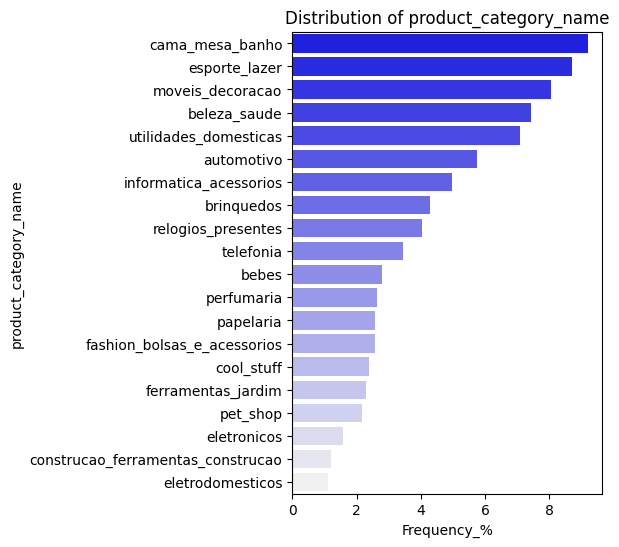

In [37]:
# Product category
# ----------------------
univ_cate_vari(products_dataset, "product_category_name")

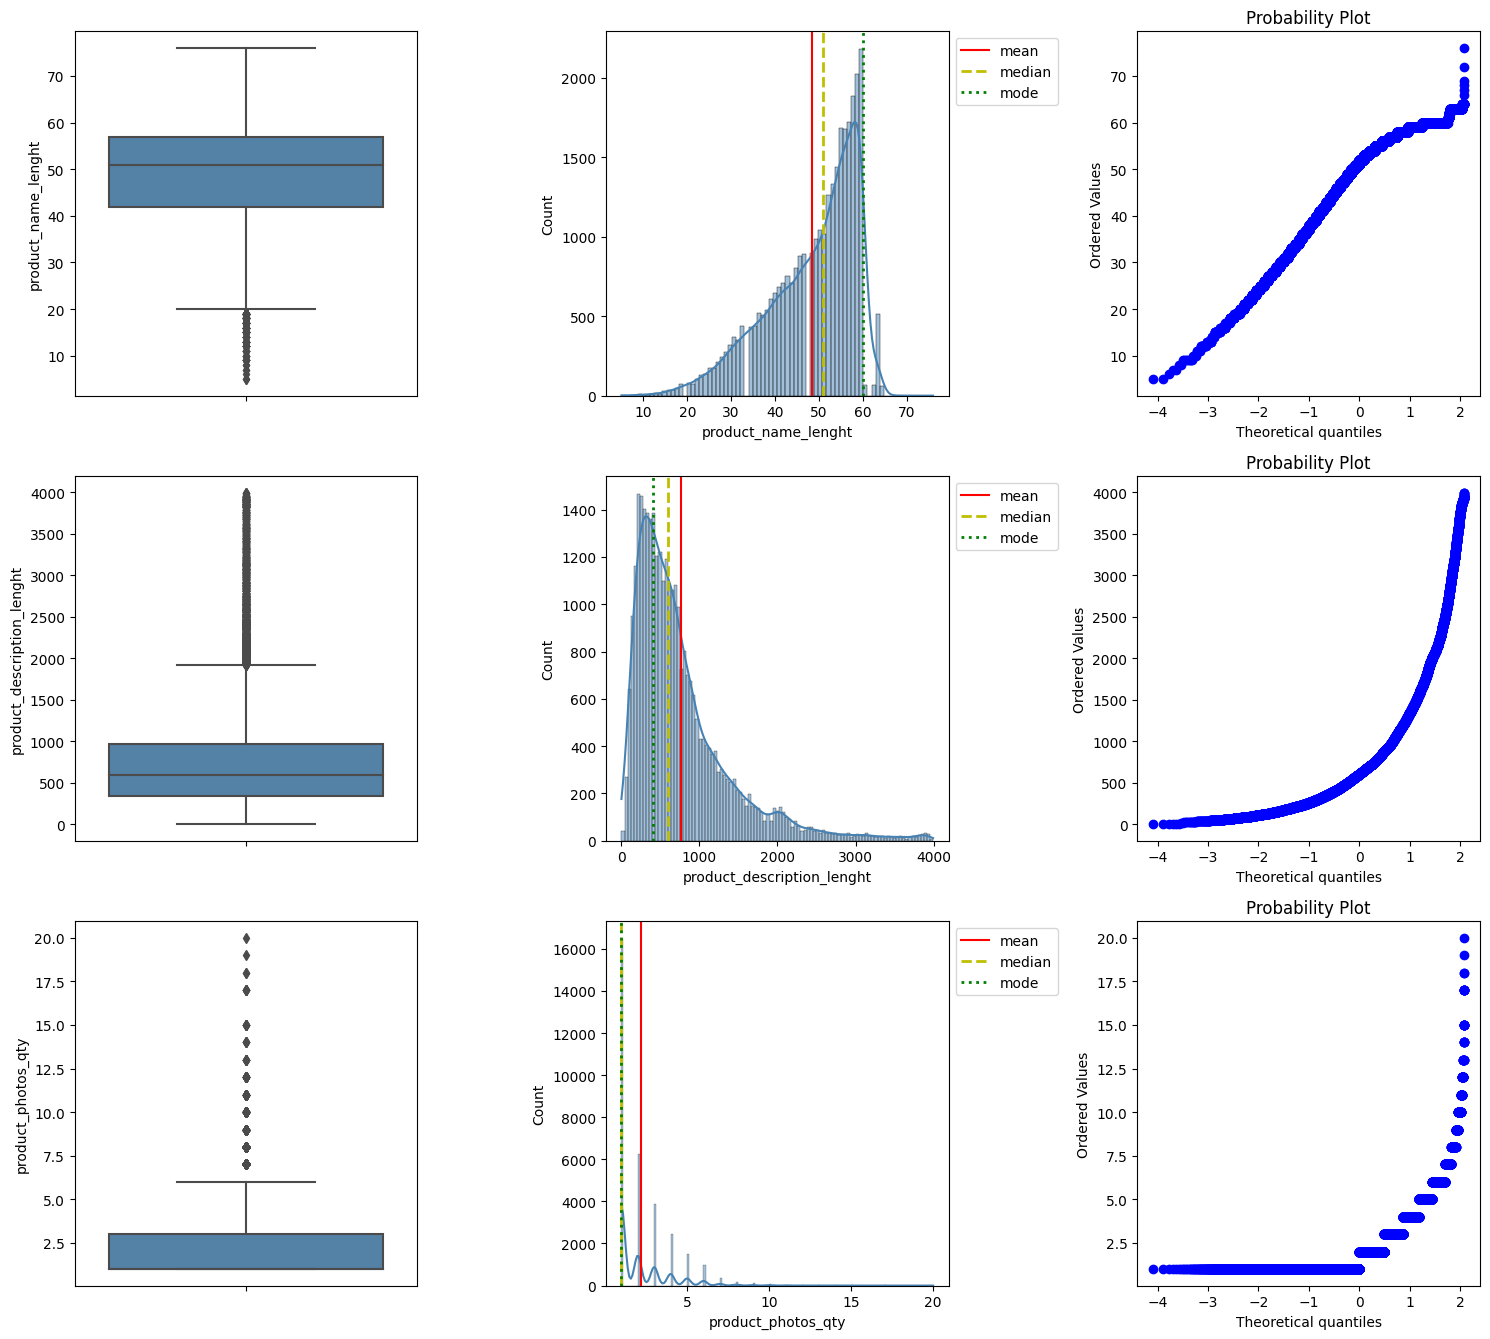

In [38]:
# --------------------
# Product description
# --------------------
df_product_descr_features = products_dataset[["product_name_lenght",
                                              "product_description_lenght",
                                              "product_photos_qty"]]
list_product_descr = df_product_descr_features.columns.tolist()

# Visualization
univ_quantit(list_product_descr, df_product_descr_features)

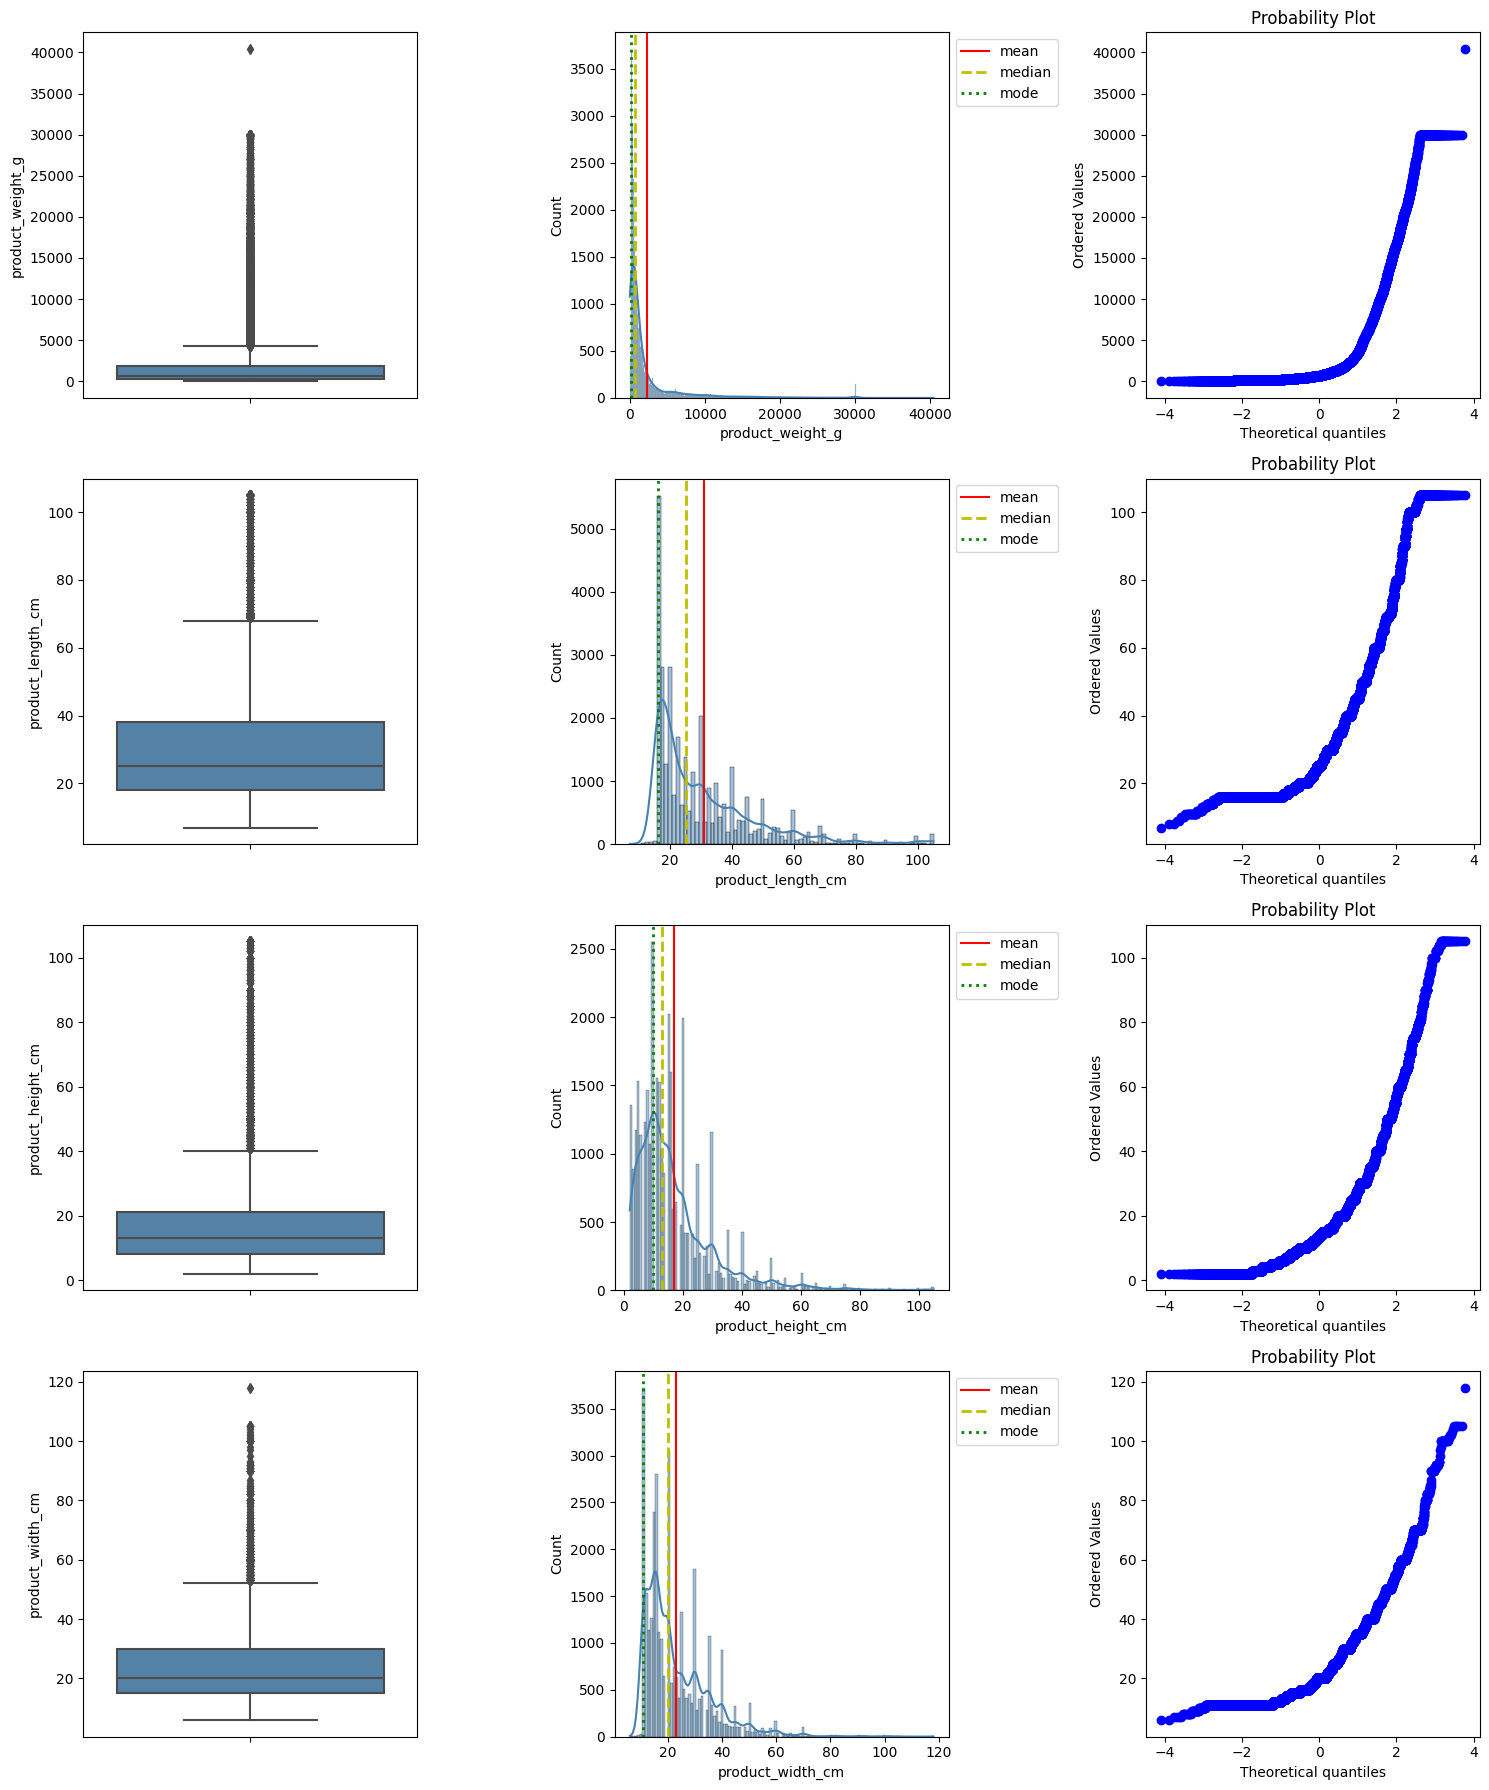

In [39]:
# --------------------
# Product dimensions
# --------------------
df_product_dim_features = products_dataset[["product_weight_g",
                                            "product_length_cm",
                                            "product_height_cm",
                                            "product_width_cm"]]
lis_product_dim = df_product_dim_features.columns.tolist()

# Visualization
univ_quantit(lis_product_dim, df_product_dim_features)

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

This dataset provides information about the products.<br>
* Each product has a unique id : **product_id**.<br>

* **product_category_name**: The spelling should be homogenized in the variable.
  * there are many categories involved in very few orders.
  * Reduce the number of categories

* **product_name_lenght** The longer the name of the product the more it sells, limit around 60 characters.
* **product_description_lenght** The description of the best selling products is less than 1000 characters.
* **product_phots_qty** Most of the products have less than 3 photos.

* Most of products are under 2.5kg, 40cm length, 20cm heigth and 30cm widht.

<a id='product_category_name_translation'></a>

---
### <span style='background:#0075bc'><span style='color:white'>product_category_name_translation</span></span>

In [40]:

# ------------------------------------------------
# File upload: product_category_name_translation
# ------------------------------------------------
# linked to PRODUCTS_DATASET by 'product_category_name'
product_category_name_translation = pd.read_csv(
    'product_category_name_translation.csv',
    low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'product_category_name_translation' contains " +
      str(product_category_name_translation.shape[0]) + " rows and " +
      str(product_category_name_translation.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
# pd.options.display.max_rows = None
product_category_name_translation.head(10)

The dataset 'product_category_name_translation' contains 71 rows and 2 columns.



product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor
5           esporte_lazer                sports_leisure
6              perfumaria                     perfumery
7   utilidades_domesticas                    housewares
8               telefonia                     telephony
9      relogios_presentes                 watches_gifts

In [41]:
# --------------------
# Column description
# --------------------
complet_description(product_category_name_translation)

Variable    Type null Duplicated Filling percentage  \
0          product_category_name  object    0          0              100.0   
1  product_category_name_english  object    0          0              100.0   

  count unique            top freq  
0    71     71   beleza_saude    1  
1    71     71  health_beauty    1

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

This dataset provides an English translation of the product categories used in the products_dataset (in Portuguese).<br>
* In the products_dataset there are 73 categories, two more than in the present one.
* The categories in each dataset should be checked and corrected if necessary.<br>

* English categories will be used for the reduction of the number of categories.

The spelling should be homogenized.

<a id='sellers_dataset'></a>

---
### <span style='background:#0075bc'><span style='color:white'>sellers_dataset</span></span>

In [42]:
# ------------------------------
# File upload: sellers_dataset
# ------------------------------
# linked to ORDER_ITEMS by 'seller_id'
# linked to GEOLOCATION by "zip_code"prefix"
sellers_dataset = pd.read_csv('olist_sellers_dataset.csv',
                              low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'sellers_dataset' contains " +
      str(sellers_dataset.shape[0]) + " rows and " +
      str(sellers_dataset.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
sellers_dataset.head(3)

The dataset 'sellers_dataset' contains 3095 rows and 4 columns.



seller_id  seller_zip_code_prefix     seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                   13023        campinas   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844      mogi guacu   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031  rio de janeiro   

  seller_state  
0           SP  
1           SP  
2           RJ

In [43]:
# --------------------
# Column description
# --------------------
complet_description(sellers_dataset)

Variable    Type null Duplicated Filling percentage   count  \
0               seller_id  object    0          0              100.0    3095   
1  seller_zip_code_prefix   int64    0        849              100.0  3095.0   
2             seller_city  object    0       2484              100.0    3095   
3            seller_state  object    0       3072              100.0    3095   

  unique                               top  freq          mean          std  \
0   3095  3442f8959a84dea7ee197c632cb2df15     1           NaN          NaN   
1    NaN                               NaN   NaN  32291.059451  32713.45383   
2    611                         sao paulo   694           NaN          NaN   
3     23                                SP  1849           NaN          NaN   

      min     25%      50%      75%      max  
0     NaN     NaN      NaN      NaN      NaN  
1  1001.0  7093.5  14940.0  64552.5  99730.0  
2     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN      NaN      NaN      NaN

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

Data set with information about vendors.<br>
Initially, this data set is of little interest.<br>
The **zip_code** must be transformed into a categorical variable.<br>
The spelling should be homogenized in the variables **seller_city** and **seller_state**.<br>

<a id='order_payments'></a>

---
### <span style='background:#0075bc'><span style='color:white'>order_payments</span></span>

In [44]:
# -----------------------------
# File upload: order_payments
# -----------------------------
# linked to ORDERS by 'order_id'
order_payments = pd.read_csv('olist_order_payments_dataset.csv',
                             low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'order_payments' contains " +
      str(order_payments.shape[0]) + " rows and " +
      str(order_payments.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
order_payments.head(3)

The dataset 'order_payments' contains 103886 rows and 5 columns.



order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71

In [45]:
# --------------------
# Column description
# --------------------
complet_description(order_payments)

Variable     Type null Duplicated Filling percentage     count  \
0              order_id   object    0       4446              100.0    103886   
1    payment_sequential    int64    0     103857              100.0  103886.0   
2          payment_type   object    0     103881              100.0    103886   
3  payment_installments    int64    0     103862              100.0  103886.0   
4         payment_value  float64    0      74809              100.0  103886.0   

  unique                               top   freq       mean         std  min  \
0  99440  fa65dad1b0e818e3ccc5cb0e39231352     29        NaN         NaN  NaN   
1    NaN                               NaN    NaN   1.092679    0.706584  1.0   
2      5                       credit_card  76795        NaN         NaN  NaN   
3    NaN                               NaN    NaN   2.853349    2.687051  0.0   
4    NaN                               NaN    NaN  154.10038  217.494064  0.0   

     25%    50%       75%       max  
0    NaN    NaN       NaN       NaN  
1    1.0    1.0       1.0      29.0  
2    NaN    NaN       NaN       NaN  
3    1.0    1.0       4.0      24.0  
4  56.79  100.0  171.8375  13664.08

<span style='color:#00547a'>**Features comprenhension**</span>

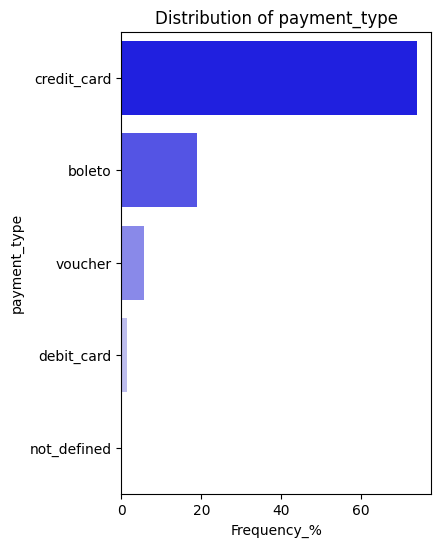

In [46]:
# Payment type
# ----------------------
univ_cate_vari(order_payments, 'payment_type')

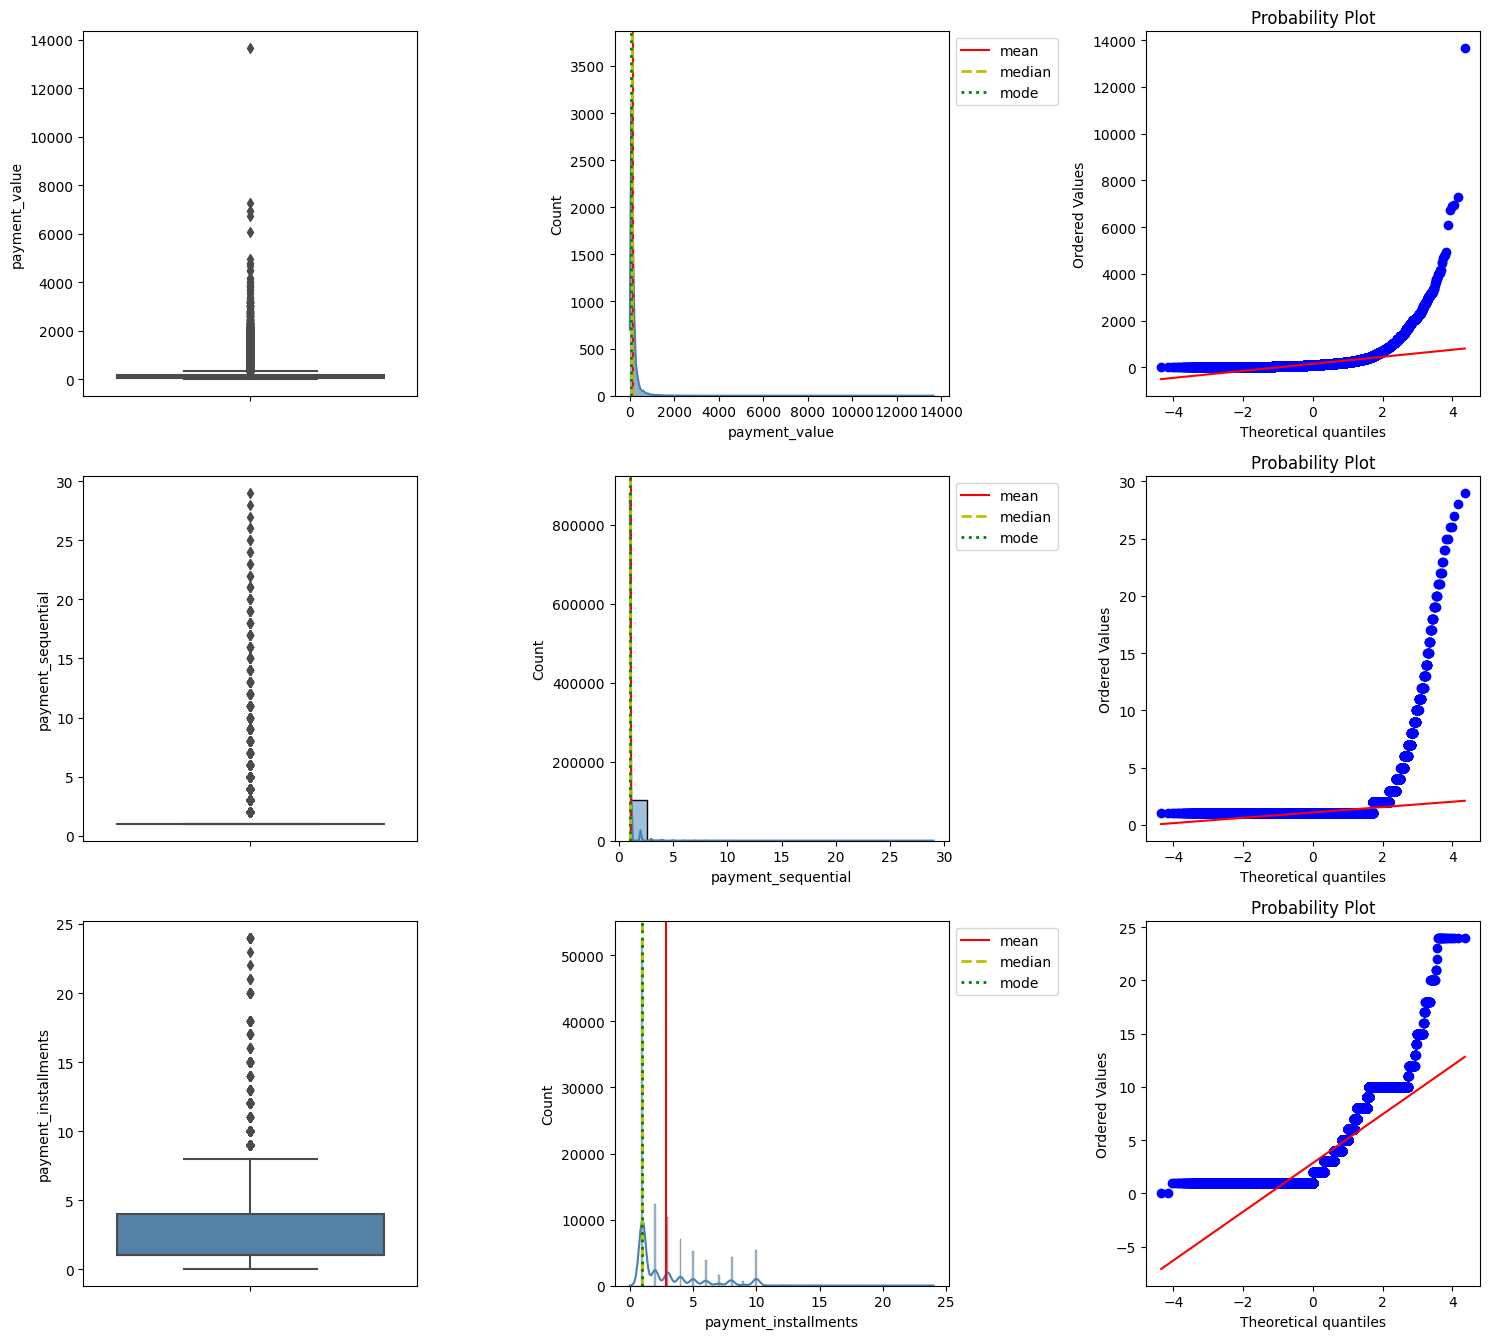

In [47]:
df_order_features = order_payments[["payment_value", "payment_sequential",
                                    "payment_installments"]]
list_order_feat = df_order_features.columns.tolist()

# Visualization
univ_quantit(list_order_feat, df_order_features)

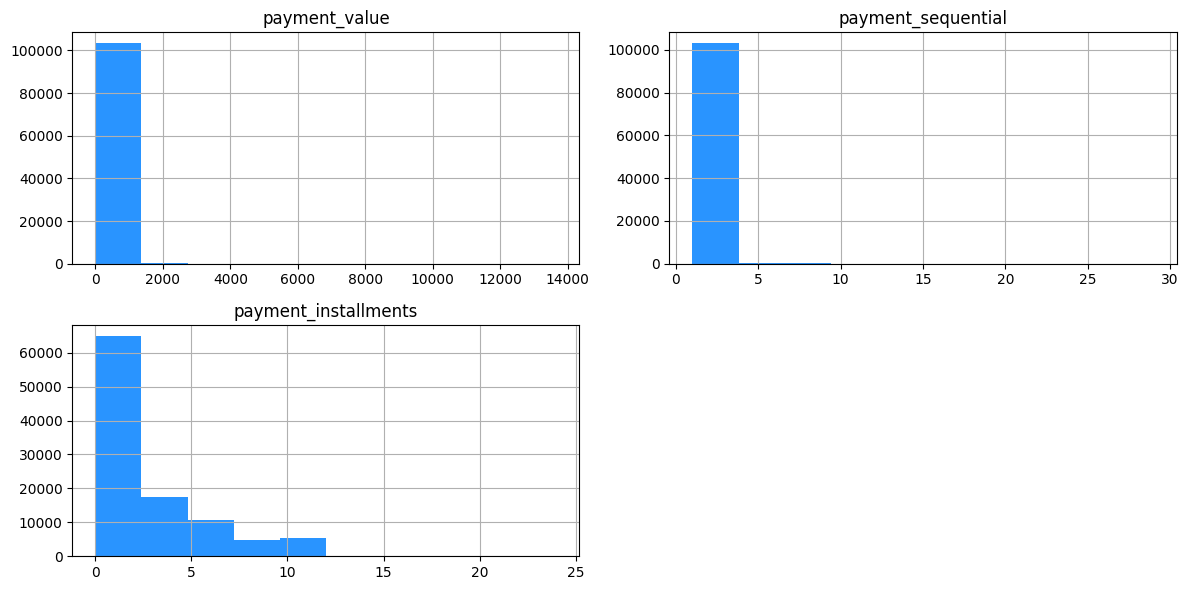

In [48]:
# Visualization
# ----------------
df_order_features = order_payments[["payment_value", "payment_sequential",
                                    "payment_installments"]]
list_order_feat = df_order_features.columns.tolist()

df_order_features.hist(bins=10, figsize=(12, 6), color='#2994ff')
plt.tight_layout()
plt.show()

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

This dataset includes information on order payment options.

* **payment_type** : most of payments are made by credit cart.
* **payment_value** : Price of the order_id. 
  * Most of the orders have an amount less than 1000 brazilian reals
* **payment_sequential** : A customer can pay for an order with more than one payment method.
  * If he does so, a sequence will be created.Most orders are paid with less than 5 methods.
* **payment_installments** : Refer to a customer paying a bill in small portions throughout a fixed period of time.
  * Instalment payments are a payment plan arranged between the buyer and the seller. Although most of the payments are made in a single payment, it is not uncommon to agree on installments

<a id='order_reviews'></a>

---
### <span style='background:#0075bc'><span style='color:white'>order_reviews</span></span>

In [49]:
# ----------------------------
# File upload: order_reviews
# ----------------------------
# linked to ORDERS by 'order_id'
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv',
                            low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'order_reviews' contains " +
      str(order_reviews.shape[0]) + " rows and " +
      str(order_reviews.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
# pd.options.display.max_columns = None
order_reviews.head(3)

The dataset 'order_reviews' contains 99224 rows and 7 columns.



review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   
2             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13  
2  2018-02-17 00:00:00     2018-02-18 14:36:24

In [50]:
# --------------------
# Column description
# --------------------
complet_description(order_reviews)

Variable    Type   null Duplicated Filling percentage  \
0     review_comment_title  object  87656       7041           11.65847   
1   review_comment_message  object  58247       4818          41.297468   
2                review_id  object      0        814              100.0   
3                 order_id  object      0        551              100.0   
4             review_score   int64      0      99219              100.0   
5     review_creation_date  object      0      98588              100.0   
6  review_answer_timestamp  object      0        976              100.0   

     count unique                               top freq      mean       std  \
0    11568   4527                         Recomendo  423       NaN       NaN   
1    40977  36159                         Muito bom  230       NaN       NaN   
2    99224  98410  7b606b0d57b078384f0b58eac1d41d78    3       NaN       NaN   
3    99224  98673  c88b1d1b157a9999ce368f218a407141    3       NaN       NaN   
4  99224.0    NaN                               NaN  NaN  4.086421  1.347579   
5    99224    636               2017-12-19 00:00:00  463       NaN       NaN   
6    99224  98248               2017-06-15 23:21:05    4       NaN       NaN   

   min  25%  50%  75%  max  
0  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  
4  1.0  4.0  5.0  5.0  5.0  
5  NaN  NaN  NaN  NaN  NaN  
6  NaN  NaN  NaN  NaN  NaN

**The columns that refer to dates must be casted to Datetime type.**

<span style='color:#00547a'>**Features comprenhension**</span>

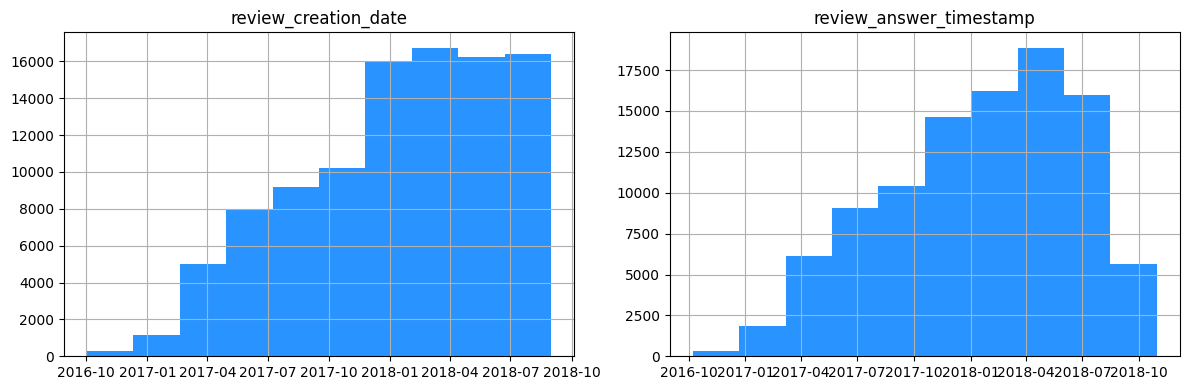

In [51]:
# ----------------------
# Date time information
# ----------------------
order_reviews['review_creation_date'] = pd.to_datetime(
    order_reviews['review_creation_date'], utc=True)
order_reviews['review_answer_timestamp'] = pd.to_datetime(
    order_reviews['review_answer_timestamp'], utc=True)

# ------------------------
# Date features analysis
# ------------------------
df_date_review = order_reviews[["review_creation_date",
                                "review_answer_timestamp"]]
df_date_review.hist(bins=10, figsize=(12, 4), color='#2994ff')
plt.tight_layout()
plt.show()

In [52]:
# Oder status
# ----------------------
univ_cate_vari(order_reviews, 'review_score', True, False)

<span style='color:#00547a'>**Bilan : orders_dataset**</span>

The **order_reviews** file contains order reviews. <br>

* **review_creation_date** Indicates the date the satisfaction survey was sent to the client.
* **review_answer_timestamp** Indicates the timestamp of the response to the satisfaction survey.

* The same review can concern several orders, the lines are multiplied so that there is one per order.<br>
* In the same way the products of an order can be associated to several reviews, the lines are also multiplied.<br>
* It will be necessary to verify if it is possible to know which products are evaluated by each review.<br>

The columns that refer to dates must be casted to Datetime type.

<a id='geolocation_dataset'></a>

---
### <span style='background:#0075bc'><span style='color:white'>geolocation_dataset</span></span>

In [53]:
# ----------------------------------
# File upload: geolocation_dataset
# ----------------------------------
# linked to SELLERS by 'zip_code_prefix'
# linked to ORDER_CUSTOMER by 'zip_code_prefix'
geolocation_dataset = pd.read_csv('olist_geolocation_dataset.csv',
                                  low_memory=False, encoding='utf-8')

# --------------
# Dataset size
# --------------
print("The dataset 'geolocation_dataset' contains " +
      str(geolocation_dataset.shape[0]) + " rows and " +
      str(geolocation_dataset.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
# pd.options.display.max_columns = None
geolocation_dataset.head(3)

The dataset 'geolocation_dataset' contains 1000163 rows and 5 columns.



geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP

In [54]:
# --------------------
# Column description
# --------------------
complet_description(geolocation_dataset)

Variable     Type null Duplicated Filling percentage  \
0  geolocation_zip_code_prefix    int64    0     981148              100.0   
1              geolocation_lat  float64    0     282803              100.0   
2              geolocation_lng  float64    0     282550              100.0   
3             geolocation_city   object    0     992152              100.0   
4            geolocation_state   object    0    1000136              100.0   

       count unique        top    freq          mean          std         min  \
0  1000163.0    NaN        NaN     NaN  36574.166466  30549.33571      1001.0   
1  1000163.0    NaN        NaN     NaN    -21.176153     5.715866  -36.605374   
2  1000163.0    NaN        NaN     NaN    -46.390541     4.269748 -101.466766   
3    1000163   8011  sao paulo  135800           NaN          NaN         NaN   
4    1000163     27         SP  404268           NaN          NaN         NaN   

         25%        50%        75%         max  
0    11075.0    26530.0    63504.0     99990.0  
1 -23.603546 -22.919377  -19.97962   45.065933  
2 -48.573172 -46.637879 -43.767709  121.105394  
3        NaN        NaN        NaN         NaN  
4        NaN        NaN        NaN         NaN

<span style='color:#00547a'>**Features comprenhension**</span>

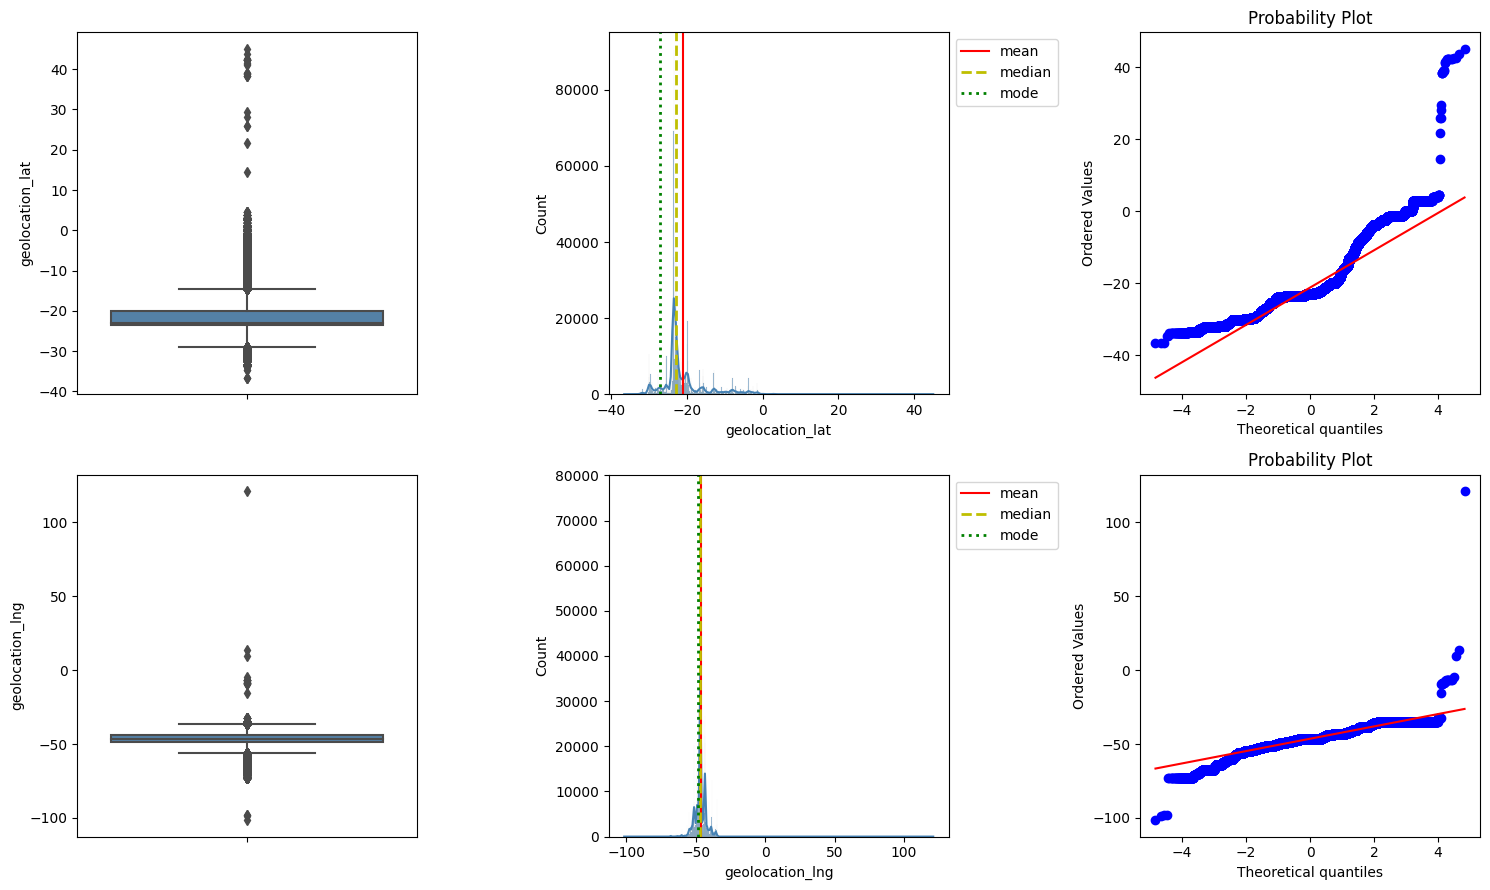

In [55]:
# -----------------------
# Geographical features
# -----------------------
df_geo_features = geolocation_dataset.select_dtypes(include="float64")
list_geo_features = df_geo_features.columns.tolist()
# Visualization
univ_quantit(list_geo_features, df_geo_features)

**Outliers analysis** :

 * Brazil Northermost point : 5.269582
 * Brazil Southermost point : -33.750936
 * Brazil Easternmost point : -28.847684
 * Brazil Westermmost point : -73.98306

In [56]:
# Outliers identification
# -----------------------
# North
north_outliers = geolocation_dataset\
                .loc[geolocation_dataset["geolocation_lat"] > 5.269582]
# South
south_outliers = geolocation_dataset\
                .loc[geolocation_dataset["geolocation_lat"] < -33.750936]
# East
east_outliers = geolocation_dataset\
                .loc[geolocation_dataset["geolocation_lng"] > -28.847684]
# West
west_outliers = geolocation_dataset\
                .loc[geolocation_dataset["geolocation_lng"] < -73.98306]

outliers = north_outliers.index.tolist() + south_outliers.index.tolist()\
            + east_outliers.index.tolist()\
            + west_outliers.index.tolist()
outliers = list(set(outliers))

# Outliers removal
# -----------------
geolocation_dataset = geolocation_dataset.drop(index=outliers)

<span style='color:#00547a'>**Bilan : geolocation_dataset**</span>

This data set contains latitude, longitude, city and state information associated with each zip code.

* There are zip codes with many entries, different latitudes/longitudes.
 * We will calculate the centroid of the coordinates to have a single latitude/longitude pair for each zip code.

The **zip_code** must be transformed into a categorical variable.<br>
The spelling should be homogenized in the variables **customer_city** and **customer_state**.<br>

---
<a id='columns_preparation'></a>

## <span style='background:#0085dd'><span style='color:white'>Columns preparation</span></span>

In [57]:
# ----------------------
# Date time information
# ----------------------
orders_dataset['order_delivered_customer_date'] = pd.to_datetime(
    orders_dataset['order_delivered_customer_date'], utc=True)
orders_dataset['order_delivered_carrier_date'] = pd.to_datetime(
    orders_dataset['order_delivered_carrier_date'], utc=True)
orders_dataset['order_approved_at'] = pd.to_datetime(
    orders_dataset['order_approved_at'], utc=True)
orders_dataset['order_purchase_timestamp'] = pd.to_datetime(
    orders_dataset['order_purchase_timestamp'], utc=True)
orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(
    orders_dataset['order_estimated_delivery_date'], utc=True)

order_items['shipping_limit_date'] = pd.to_datetime(
    order_items['shipping_limit_date'], utc=True)

order_items['shipping_limit_date'] = pd.to_datetime(
    order_items['shipping_limit_date'], utc=True)

order_reviews['review_creation_date'] = pd.to_datetime(
    order_reviews['review_creation_date'], utc=True)

order_reviews['review_answer_timestamp'] = pd.to_datetime(
    order_reviews['review_answer_timestamp'], utc=True)

In [58]:
# ----------------------
# Zip_code information
# ----------------------
customers_dataset['customer_zip_code_prefix'] =\
    customers_dataset['customer_zip_code_prefix'].astype(str)
customers_dataset['customer_zip_code_prefix'] = \
    customers_dataset['customer_zip_code_prefix'].str.rjust(5, '0')

sellers_dataset['seller_zip_code_prefix'] =\
    sellers_dataset['seller_zip_code_prefix'].astype(str)
sellers_dataset['seller_zip_code_prefix'] = \
    sellers_dataset['seller_zip_code_prefix'].str.rjust(5, '0')

geolocation_dataset['geolocation_zip_code_prefix'] =\
    geolocation_dataset['geolocation_zip_code_prefix'].astype(str)
geolocation_dataset['geolocation_zip_code_prefix'] = \
    geolocation_dataset['geolocation_zip_code_prefix'].str.rjust(5, '0')

In [59]:
# -------------------------
# Spelling homogenization
# -------------------------
customers_dataset['customer_city'] = customers_dataset['customer_city']\
    .str.lower().replace({r"ã": "a"}, regex=True)
customers_dataset['customer_state'] = customers_dataset['customer_city']\
    .str.upper().replace({r"ã": "a"}, regex=True)

sellers_dataset['seller_city'] = sellers_dataset['seller_city']\
    .str.lower().replace({r"ã": "a"}, regex=True)
sellers_dataset['seller_state'] = sellers_dataset['seller_state']\
    .str.upper().replace({r"ã": "a"}, regex=True)

geolocation_dataset['geolocation_city'] =\
    geolocation_dataset['geolocation_city']\
    .str.lower().replace({r"ã": "a"}, regex=True)

products_dataset['product_category_name'] = \
    products_dataset['product_category_name']\
    .str.lower().replace({r"ã": "a"}, regex=True)

product_category_name_translation['product_category_name'] = \
    product_category_name_translation['product_category_name']\
    .str.lower().replace({r"ã": "a"}, regex=True)

product_category_name_translation['product_category_name_english'] = \
    product_category_name_translation['product_category_name_english']\
    .str.lower().replace({r"ã": "a"}, regex=True)


<a id='centroid_zipCode'></a>

---
### <span style='background:#0075bc'><span style='color:white'>Zip codes centroid calculation</span>

In [60]:
# Comparison of Zip Codes in both datasets
list_zipCode_customers = customers_dataset['customer_zip_code_prefix']\
    .unique().tolist()

list_zipCode_geo = \
    geolocation_dataset['geolocation_zip_code_prefix'].unique().tolist()

list_zipCode_difference = list(set(list_zipCode_customers)
                               .difference(list_zipCode_geo))

print("Il y a " + str(len(list_zipCode_difference)) +
      " zip Codes in the customers data set that are not present in the geolocation dataset.\n")

# pprint("Items in 'customers_dataset', not in 'geolocation_dataset'; " +str(list_zipCode_difference))

Il y a 158 zip Codes in the customers data set that are not present in the geolocation dataset.



In [61]:
# Comparison of cities in both datasets
list_cities_customers = customers_dataset['customer_city']\
    .unique().tolist()

list_cities_geoloc = \
    geolocation_dataset['geolocation_city'].unique().tolist()

list_cities_difference = list(set(list_cities_customers)
                              .difference(list_cities_geoloc))

print("There are " + str(len(list_cities_difference)) +
      " cities in the 'customers_dataset' that are not present in the 'geolocation_dataset'.\n")

pprint("Items in 'customers_dataset', not in 'geolocation_dataset'; "
       + str(list_cities_difference))

There are 51 cities in the 'customers_dataset' that are not present in the 'geolocation_dataset'.

("Items in 'customers_dataset', not in 'geolocation_dataset'; ['colonia "
 "jordaozinho', 'taboquinhas', 'sao miguel do cambui', 'glaura', 'ilha dos "
 "valadares', 'siriji', 'guinda', 'poco de pedra', 'angelo frechiani', "
 "'conceicao do formoso', 'cipo-guacu', 'sao francisco do humaita', "
 "'passagem', 'santo eduardo', 'jaua', 'sao sebastiao do paraiba', 'ibitioca', "
 "'bom jesus do querendo', 'jaguarembe', 'doce grande', 'major porto', "
 "'guariroba', 'maioba', 'sambaiba', 'humildes', 'mampituba', 'perola "
 "independente', 'mussurepe', 'palmeirinha', 'bora', 'aribice', 'missi', "
 "'caldas do jorro', 'estevao de araujo', 'cuite velho', 'nossa senhora do "
 "remedio', 'sao vitor', 'pitanga de estrada', 'ajapi', 'sao sebastiao da "
 "serra', 'monnerat', 'sao clemente', 'piacu', 'pinhotiba', 'nucleo "
 "residencial pilar', 'polo petroquimico de triunfo', 'palmital de minas', "
 "'alt

In [62]:
# Before calculating the centroid we will complete the geolocation_dataset

# Create a table with the zip_code missing in the geolocation_dataset
missing_zip_codes = customers_dataset\
    .loc[customers_dataset["customer_zip_code_prefix"]
         .isin(list_zipCode_difference)]
to_complet_zipCodes = missing_zip_codes[["customer_zip_code_prefix",
                                         "customer_city", "customer_state"]]


# Use cities information in geolocation_dataset to complete
# as much as possible
# Finding the centroid values (latitude/longitude) for each 'city' pair
results_city = (geolocation_dataset
                .groupby(["geolocation_city"])
                # Choosing which functions get used on which columns
                .agg({'geolocation_lat':'mean', 'geolocation_lng':'mean'})
                # Renaming columns for clarity
                .rename(columns={'geolocation_lat':'lat_simple_avg',
                                 'geolocation_lng':'lon_simple_avg',})
                # Making "geolocation_zip_code_prefix" a regular column again
                .reset_index())

# Generating a GeoDataFrame with the centroid points using the simple average
# of the original coordinates
results_city_avg_geo = (gpd.GeoDataFrame(results_city
                                   .copy(),
                                   crs='epsg:4326',
                                   geometry=gpd.points_from_xy(
                                       results_city['lat_simple_avg'],
                                       results_city['lon_simple_avg']))
                   # Dropping the "avg" columns
                   .drop(columns=['lat_simple_avg','lon_simple_avg']))

# Creating a column for the lat and lng centroid values
results_city_avg_geo["geolocation_avg_lat"] = results_city_avg_geo.geometry.x
results_city_avg_geo["geolocation_avg_lng"] = results_city_avg_geo.geometry.y
# Drop 'geometry' column
results_city_avg_geo = results_city_avg_geo.drop(columns="geometry")

# Merge tables, 1st step to complete
complete_zipCodes = to_complet_zipCodes.merge(results_city_avg_geo,
                                              left_on='customer_city',
                                              right_on = 'geolocation_city',
                                              how='left')

# Zip codes to complete complete_zipCodes
really_missing = complete_zipCodes\
    .loc[(complete_zipCodes["geolocation_avg_lat"]).isna()
         | (complete_zipCodes["geolocation_avg_lng"].isna())]
net_search_zipCode = really_missing["customer_zip_code_prefix"]\
                                                    .unique().tolist()

pprint("Zip code with missing information : " +str(net_search_zipCode))


("Zip code with missing information : ['35408', '08980', '65137', '28655', "
 "'28388', '06930', '36956', '35242', '29718', '75784', '25840', '85118', "
 "'95853', '95572', '58734', '35104', '17390', '36596', '48504', '83843', "
 "'62625', '49870', '85958', '19740', '44135', '28120', '87323', '65830', "
 "'28575', '28160', '38710', '36248', '39103', '59299', '85894', '36857', "
 "'42843', '83252', '86996', '58286', '38627', '28530', '55863']")


In [63]:
# Chercher le ZipCode associé à l'addresse et compléter
complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "35408", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-23.8827427, -46.7940334]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "08980", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-23.410895065656394, -46.04560462459372]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "55863", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-7.657986977645164, -35.47476250398852] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "65137", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-2.5408299999864097, -44.17273800087062] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "28655", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-22.076469375534007, -42.40670890824121] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "28388", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-20.98278, -41.86417] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "95853", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-29.712578256812993, -51.62628968247364]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "62625", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-3.6206027204964792, -39.82343218140609] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "28575", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-21.725418904519163, -41.991373162206116] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "42843", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-12.819490466117706, -38.23706114129119] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "06930", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-23.88111, -46.79639] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "95572", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-29.211999068085763, -49.93637599563607] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "49870", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-10.126910400789862, -37.103216395191716]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "28160", ["geolocation_avg_lat", "geolocation_avg_lng"]] =  [-21.215323203948262, -41.46786985887809] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "86996", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-23.61, -51.86417] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "36956", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-20.0, -41.35583] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "58734", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-7.13174037730689, -37.05309585780768]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "85958", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-24.52528, -53.74556]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "35242", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-19.13298, -41.35661] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "29718", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-19.53944, -40.63056] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "75784", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-16.915186875942336, -47.71552467179411] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "25840", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-22.14692078357193, -43.10366798818054]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "85118", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-25.309814562067295, -50.58056555407106] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "35104", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-23.49234, -46.35112]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "17390", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-22.441864091336747, -48.01790434341276] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "36596", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-20.61667, -42.53333] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "48504", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-10.56667, -38.78333]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "83843", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-26.0, -49.40667]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "19740", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-22.270395531285732, -50.54459756657703] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "44135", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-12.353861118977134, -38.870653162638426]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "28120", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-21.825255312753878, -41.43599789412664]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "87323", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-24.55917, -52.10167]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "65830", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-7.138193990784812, -45.34748454742859] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "38710", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-18.70513145592613, -46.04834013212599] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "36248", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-21.41667, -43.35] 

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "39103", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-18.25, -43.68333]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "59299", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-5.81667, -35.45]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "85894", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-24.781437265680754, -54.23454640567315]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "36857", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-20.96667, -42.18333]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "58286", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-6.61, -35.13556]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "38627", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-16.1248314, -47.2931216]

complete_zipCodes.loc[complete_zipCodes["customer_zip_code_prefix"] == "28530", ["geolocation_avg_lat", "geolocation_avg_lng"]] = [-21.7625, -42.37278]


In [64]:
# Prepare the new table to join the 'geolocation_dataset'
complete_zipCodes = complete_zipCodes.drop(columns="geolocation_city")
complete_zipCodes.columns = ["geolocation_zip_code_prefix",
                             "geolocation_city", "geolocation_state",
                             "geolocation_lat", "geolocation_lng"]

# Join tables
geolocation_dataset = pd.concat([geolocation_dataset, complete_zipCodes])

In [65]:
# Verify that all consumer zip codes are now in the 'geolocation_dataset'
list_zipCode_customers = customers_dataset['customer_zip_code_prefix']\
    .unique().tolist()

list_zipCode_geo = \
    geolocation_dataset['geolocation_zip_code_prefix'].unique().tolist()

list_zipCode_difference = list(set(list_zipCode_customers)
                               .difference(list_zipCode_geo))

print("There are " + str(len(list_zipCode_difference)) + " zip Codes in the customers data set that are not present in the geolocation dataset.\n")

There are 0 zip Codes in the customers data set that are not present in the geolocation dataset.



In [66]:
# Finding the centroid values (latitude/longitude) for each 'zip_code'
results = (geolocation_dataset
           .groupby(["geolocation_zip_code_prefix"])
           # Choosing which functions get used on which columns
           .agg({'geolocation_lat':'mean',
                 'geolocation_lng':'mean'})
           # Renaming columns for clarity
           .rename(columns={'geolocation_lat':'lat_simple_avg',
                            'geolocation_lng':'lon_simple_avg',})
           # Making "geolocation_zip_code_prefix" a regular column again
           .reset_index())

# Generating a GeoDataFrame with the centroid points using the simple average
# of the original coordinates
results_avg_geo = (gpd.GeoDataFrame(results
                                   .copy(),
                                   crs='epsg:4326',
                                   geometry=gpd.points_from_xy(
                                       results['lat_simple_avg'], 
                                       results['lon_simple_avg']))
                   # Dropping the "avg" columns
                   .drop(columns=['lat_simple_avg','lon_simple_avg']))

# Creating a column for the lat and lng centroid values
results_avg_geo["geolocation_avg_lat"] = results_avg_geo.geometry.x
results_avg_geo["geolocation_avg_lng"] = results_avg_geo.geometry.y

# Drop 'geometry' column
results_avg_geo = results_avg_geo.drop(columns="geometry")
results_avg_geo.head()



geolocation_zip_code_prefix  geolocation_avg_lat  geolocation_avg_lng
0                       01001           -23.550190           -46.634024
1                       01002           -23.548146           -46.634979
2                       01003           -23.548994           -46.635731
3                       01004           -23.549799           -46.634757
4                       01005           -23.549456           -46.636733

<a id='cat_products'></a>

---
### <span style='background:#0075bc'><span style='color:white'>Product category check and update</span></span>

In [67]:
# Comparison of items in both datasets
list_unique_products_dataset = products_dataset['product_category_name']\
                                                            .unique().tolist()

list_unique_product_category_name_translation = \
                 product_category_name_translation['product_category_name']\
                                                            .unique().tolist()

print("Items in 'products_dataset', not in 'product_category_name_translation'; "
      + str(list(set(list_unique_products_dataset)
                 .difference(list_unique_product_category_name_translation))))

Items in 'products_dataset', not in 'product_category_name_translation'; [nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos']


In [68]:
# Creation of new entries in 'product_category_name_translation'
newRows = ({'product_category_name':
            ['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer'],
            'product_category_name_english':
            ['small_appliances_kitchen_and_food_preparers',
             'computer_gamer']})
df_newRows = pd.DataFrame(newRows)

product_category_name_translation = pd.concat(
    [product_category_name_translation, df_newRows], axis=0)

In [69]:
# Reduction of categories :
product_categories_dict = {
    # Auto
    'auto': 'auto',
    # other_stuff
    'watches_gifts': 'other_stuff',
    'cool_stuff': 'other_stuff',
    'luggage_accessories': 'other_stuff',
    # stationery
    'stationery': 'stationery',
    # market_place
    'market_place': 'market_place',
    # industry_commerce_bussiness
    'agro_industry_and_commerce': 'industry_commerce_bussiness',
    'industry_commerce_and_business': 'industry_commerce_bussiness',
    # food_drink
    'food': 'food_drink',
    'drinks': 'food_drink',
    'food_drink': 'food_drink',
    # home_appliances_confort
    'air_conditioning': 'home_appliances_confort',
    'home_confort': 'home_appliances_confort',
    'home_appliances_2': 'home_appliances_confort',
    'home_appliances': 'home_appliances_confort',
    'home_comfort_2': 'home_appliances_confort',
    # security
    'security_and_services': 'security',
    'signaling_and_security': 'security',
    # computers
    'computer_gamer': 'computers',
    'computers': 'computers',
    # leisure
    'cine_photo': 'leisure',
    'music': 'leisure',
    'cds_dvds_musicals': 'leisure',
    'dvds_blu_ray': 'leisure',
    'cool_stuff': 'leisure',
    'audio': 'leisure',
    'arts_and_craftmanship': 'leisure',
    'art': 'leisure',
    'flowers': 'leisure',
    'books_imported': 'leisure',
    'books_technical': 'leisure',
    'books_general_interest': 'leisure',
    'consoles_games': 'leisure',
    'musical_instruments': 'leisure',
    'sports_leisure': 'leisure',
    # tools_construction
    'garden_tools': 'tools_construction',
    'costruction_tools_garden': 'tools_construction',
    'construction_tools_construction': 'tools_construction',
    'costruction_tools_tools': 'tools_construction',
    'home_construction': 'tools_construction',
    'construction_tools_lights': 'tools_construction',
    'construction_tools_safety': 'tools_construction',
    # kitchen_stuff
    'housewares': 'kitchen_stuff',
    'small_appliances_kitchen_and_food_preparers': 'kitchen_stuff',
    'small_appliances_home_oven_and_coffee': 'kitchen_stuff',
    'la_cuisine': 'kitchen_stuff',
    # technology
    'small_appliances': 'technology',
    'computers_accessories': 'technology',
    'electronics': 'technology',
    'tablets_printing_image': 'technology',
    'telephony': 'technology',
    'fixed_telephony': 'technology',
    # party_decor
    'party_supplies': 'party_decor',
    'christmas_supplies': 'party_decor',
    'bed_bath_table': 'party_decor',
    # health_beauty
    'health_beauty': 'health_beauty',
    'perfumery': 'health_beauty',
    'diapers_and_hygiene': 'health_beauty',
    # kids
    'baby': 'kids',
    'toys': 'kids',
    'fashion_childrens_clothes': 'kids',
    # pet_shop
    'pet_shop': 'pet_shop',
    # fashion
    'fashion_bags_accessories': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashion_underwear_beach': 'fashion',
    'fashion_sport': 'fashion',
    'fashio_female_clothing': 'fashion',
    # furniture
    'furniture_bedroom': 'furniture',
    'furniture_decor': 'furniture',
    'kitchen_dining_laundry_garden_furniture': 'furniture',
    'furniture_mattress_and_upholstery': 'furniture',
    'furniture_living_room': 'furniture',
    'office_furniture': 'furniture'}

print("Original number of categories "
      + str(len(list(product_categories_dict.values()))))
print("Final number of categories "
      + str(len(set(list(product_categories_dict.values())))))

Original number of categories 73
Final number of categories 19


In [70]:
len(list(product_categories_dict.values()))

73

In [71]:
# Create a new column for the reduced categoires

product_category_name_translation['product_category_name_reduced'] =\
        product_category_name_translation['product_category_name_english']\
                                                .map(product_categories_dict)

print(len(product_category_name_translation["product_category_name_reduced"]
          .unique().tolist()))

19


<a id='datasets_joining'></a>

# <font color = '#26467a'>**Datasets joining** </font>


In [72]:

# -------------
# customer_id
# -------------
print("\n Number of different 'customer_id'")
print("'orders_dataset' : "
      + str(len(list(orders_dataset['customer_id'].unique()))))
print("'customers_dataset' : "
      + str(len(list(customers_dataset['customer_id'].unique()))))

# -----------------
# zip_code_prefix
# -----------------
print("\n Number of different 'zip_code_prefix'")
print("'customers_dataset' : ('customer_zip_code_prefix') "
      + str(len(list(customers_dataset['customer_zip_code_prefix']
                     .unique()))))

print("'sellers_dataset' : ('seller_zip_code_prefix')"
      + str(len(list(sellers_dataset['seller_zip_code_prefix'].unique()))))

print("'geolocation_dataset' : ('geolocation_zip_code_prefix')"
      + str(len(list(geolocation_dataset['geolocation_zip_code_prefix']
                     .unique()))))

# ----------
# order_id
# ----------
print("\n Number of different 'order_id'")
print("'orders_dataset' : "
      + str(len(list(orders_dataset['order_id'].unique()))))
print("'order_items' : "
      + str(len(list(order_items['order_id'].unique()))))
print("'order_payments' : "
      + str(len(list(order_payments['order_id'].unique()))))
print("'order_reviews' : "
      + str(len(list(order_reviews['order_id'].unique()))))

# -----------
# seller_id
# -----------
print("\n Number of different 'seller_id'")
print("'order_items' : "
      + str(len(list(order_items['seller_id'].unique()))))

print("'sellers_dataset' : "
      + str(len(list(sellers_dataset['seller_id'].unique()))))

# ------------
# product_id
# ------------
print("\n Number of different 'product_id'")
print("'order_items' : "
      + str(len(list(order_items['product_id'].unique()))))

print("'products_dataset' : "
      + str(len(list(products_dataset['product_id'].unique()))))

# ----------------------
# product_category_name
# ----------------------
print("\n Number of different 'product_category_name'")
print("'products_dataset': "
      + str(products_dataset['product_category_name'].nunique()))
print("'product_category_name_translation' : "
      + str(product_category_name_translation['product_category_name']
            .nunique()))

print("\n Number of different 'product_category_name_english'")
print("'product_category_name_translation' : "
      + str(product_category_name_translation['product_category_name_english']
            .nunique()))


 Number of different 'customer_id'
'orders_dataset' : 99441
'customers_dataset' : 99441

 Number of different 'zip_code_prefix'
'customers_dataset' : ('customer_zip_code_prefix') 14994
'sellers_dataset' : ('seller_zip_code_prefix')2246
'geolocation_dataset' : ('geolocation_zip_code_prefix')19169

 Number of different 'order_id'
'orders_dataset' : 99441
'order_items' : 98666
'order_payments' : 99440
'order_reviews' : 98673

 Number of different 'seller_id'
'order_items' : 3095
'sellers_dataset' : 3095

 Number of different 'product_id'
'order_items' : 32951
'products_dataset' : 32951

 Number of different 'product_category_name'
'products_dataset': 73
'product_category_name_translation' : 73

 Number of different 'product_category_name_english'
'product_category_name_translation' : 73


---

<font color="#00547a"> **geolocation** </font> 

In [73]:
# Joining dataset customer and geolocation
customers_geolocation = customers_dataset.merge(results_avg_geo,
                                    left_on='customer_zip_code_prefix',
                                    right_on='geolocation_zip_code_prefix',
                                                how='left')

# Remove column 'geolocation_zip_code_prefix'
customers_geolocation = customers_geolocation\
                                .drop(columns='geolocation_zip_code_prefix')

# Rename lat/long columns for clarity
customers_geolocation = customers_geolocation.rename(
    columns={"geolocation_avg_lat":"customer_geoloc_avg_lat",
             "geolocation_avg_lng":"customer_geoloc_avg_lng"})

print(customers_geolocation.shape[0])

99441


In [74]:

# Joining dataset seller and geolocation
sellers_geolocation = sellers_dataset.merge(results_avg_geo,
                                            left_on='seller_zip_code_prefix',
                                    right_on='geolocation_zip_code_prefix',
                                            how='left')

# Remove column 'geolocation_zip_code_prefix'
sellers_geolocation = sellers_geolocation.drop(
                                        columns='geolocation_zip_code_prefix')

# Rename lat/long columns for clarity
sellers_geolocation = sellers_geolocation.rename(
    columns={"geolocation_avg_lat":"seller_geoloc_avg_lat",
             "geolocation_avg_lng":"seller_geoloc_avg_lng"})

print(sellers_geolocation.shape[0])

3095


---

<font color="#00547a"> **Customer & Order** </font> 

In [75]:
# Joining customer & order information
customer_order = customers_geolocation\
    .merge(orders_dataset, on='customer_id', how='left')
print(customer_order.shape)

(99441, 14)


---

<font color="#00547a"> **Customer & Order & Items** </font> 

In [76]:
# Joining item information
customer_order_item = customer_order\
    .merge(order_items, on='order_id', how='left')
print(customer_order_item.shape)

(113425, 20)


---

<font color="#00547a"> **Customer & Order & Items & Product category** </font> 

In [77]:
# Joining both datasets about products
products_dataset_cat_en = products_dataset.\
    merge(product_category_name_translation, on='product_category_name',
          how='left').drop(columns=["product_category_name",
                                    "product_category_name_english"])

In [78]:
# Joining item information
customer_order_item_cat = customer_order_item\
    .merge(products_dataset_cat_en, on='product_id', how='left')
print(customer_order_item_cat.shape)

(113425, 28)


---

<font color="#00547a"> **Customer & Order & Items & Product category & Payments** </font> 

In [79]:
# Joining Payments information
customer_order_item_cat_pay = customer_order_item_cat\
    .merge(order_payments, on='order_id', how='left')
print(customer_order_item_cat_pay.shape)

(118434, 32)


---

<font color="#00547a"> **Customer & Order & Items & Product category & Payments & Review** </font> 

In [80]:
# Joining Payments information
customer_order_item_cat_pay_rev = customer_order_item_cat_pay\
    .merge(order_reviews, on='order_id', how='left')
print(customer_order_item_cat_pay_rev.shape)

(119143, 38)


---

<font color="#00547a"> **Customer & Order & Items & Product category & Payments & Review & Seller** </font> 

In [81]:
# Joining Seller information
customer_order_item_cat_pay_rev_seller = customer_order_item_cat_pay_rev\
    .merge(sellers_geolocation, on='seller_id', how='left')
print(customer_order_item_cat_pay_rev_seller.shape)

(119143, 43)


---

<font color="#00547a"> **All data joined** </font> 

In [82]:
# Create a copy of the dataset that compiles all the data
all_data_olist = customer_order_item_cat_pay_rev_seller.copy()

# --------------
# Dataset size
# --------------
print("The dataset 'all_data_olist' contains "
      + str(all_data_olist.shape[0]) + " rows and "
      + str(all_data_olist.shape[1]) + " columns.\n")

The dataset 'all_data_olist' contains 119143 rows and 43 columns.



---
---
<a id='data_description'></a>

## <font color = '#0085dd'>Data description</font>
    

In [83]:
all_data_olist.shape

(119143, 43)

In [84]:
# ------------------
# Data description
# ------------------
info_all_data_olist = complet_description(all_data_olist)
info_all_data_olist

Variable                 Type    null Duplicated  \
0            review_comment_title               object  105154       9462   
1          review_comment_message               object   68898      14086   
2   order_delivered_customer_date  datetime64[ns, UTC]    3421      20058   
3      product_description_lenght              float64    2542     113641   
4   product_category_name_reduced               object    2542     116582   
5              product_photos_qty              float64    2542     116582   
6             product_name_lenght              float64    2542     116535   
7    order_delivered_carrier_date  datetime64[ns, UTC]    2086      36039   
8           seller_geoloc_avg_lat              float64    1055     115847   
9           seller_geoloc_avg_lng              float64    1055     115847   
10                      review_id               object     997      19736   
11                   review_score              float64     997     118141   
12           review_creation_date  datetime64[ns, UTC]     997     117510   
13        review_answer_timestamp  datetime64[ns, UTC]     997      19898   
14              product_length_cm              float64     853     118191   
15               product_weight_g              float64     853     116086   
16              product_height_cm              float64     853     118188   
17               product_width_cm              float64     853     118195   
18                      seller_id               object     833     115215   
19                  freight_value              float64     833     111311   
20                     product_id               object     833      85359   
21                  order_item_id              float64     833     118289   
22         seller_zip_code_prefix               object     833     116064   
23                    seller_city               object     833     117699   
24                   seller_state               object     833     118287   
25            shipping_limit_date  datetime64[ns, UTC]     833      24992   
26                          price              float64     833     112342   
27              order_approved_at  datetime64[ns, UTC]     177      28233   
28             payment_sequential              float64       3     119111   
29                   payment_type               object       3     119135   
30           payment_installments              float64       3     119116   
31                  payment_value              float64       3      90063   
32        customer_geoloc_avg_lat              float64       1     104224   
33        customer_geoloc_avg_lng              float64       1     104225   
34       order_purchase_timestamp  datetime64[ns, UTC]       0      20268   
35                 customer_state               object       0     115024   
36       customer_zip_code_prefix               object       0     104149   
37             customer_unique_id               object       0      23047   
38  order_estimated_delivery_date  datetime64[ns, UTC]       0     118684   
39                       order_id               object       0      19702   
40                   order_status               object       0     119135   
41                  customer_city               object       0     115024   
42                    customer_id               object       0      19702   

   Filling percentage     count unique                               top  \
0           11.741353     13989   4527                         Recomendo   
1           42.172012     50245  36159                         Muito bom   
2           97.128661    115722    NaN                               NaN   
3           97.866429  116601.0    NaN                               NaN   
4           97.866429    116601     19                        technology   
5           97.866429  116601.0    NaN                               NaN   
6           97.866429  116601.0    NaN                               NaN   
7           98.249163    117

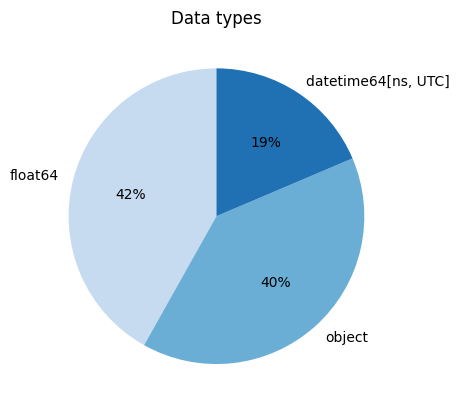

In [85]:
# Visualization data types
dTypes = info_all_data_olist['Type'].value_counts()
blues3 = sns.color_palette(palette="Blues", n_colors=3)

plt.pie(dTypes.values.tolist(), labels=["float64", "object",
                                        "datetime64[ns, UTC]"],
        colors=blues3, autopct="%.0f%%", startangle=90)
plt.title("Data types")
plt.show()


<a id='missing_values'></a>

### <font color = '#0075bc'> Evaluation of missing values </font>

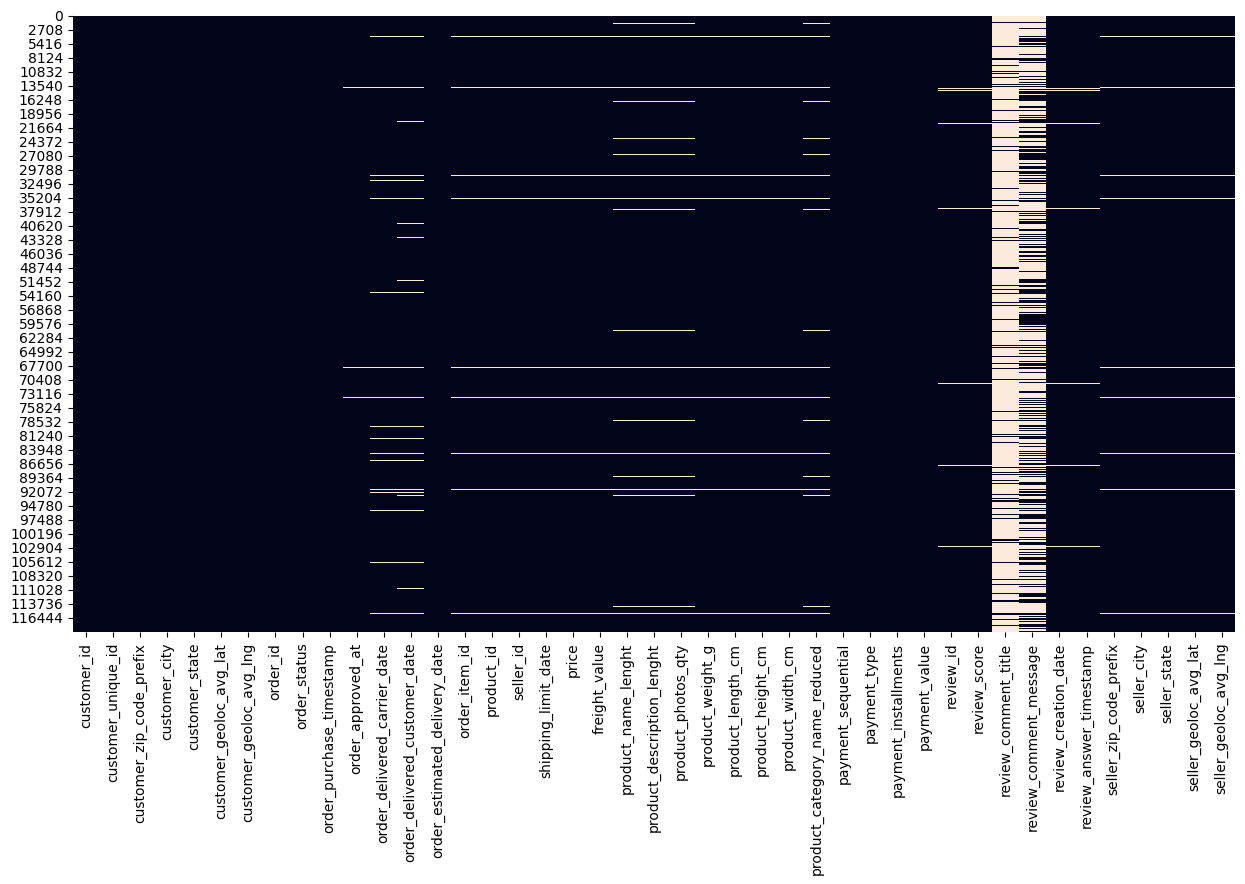

In [86]:
'''
#------------------------------
# Graphique valeurs manquantes
#------------------------------
'''
plt.figure(figsize=(15, 8))
sns.heatmap(all_data_olist.isnull(), cbar=False, cmap="rocket")
plt.show()

---
---
<a id='column_fill'></a>

## <font color = '#0085dd'>Column filling analysiss </font>
    

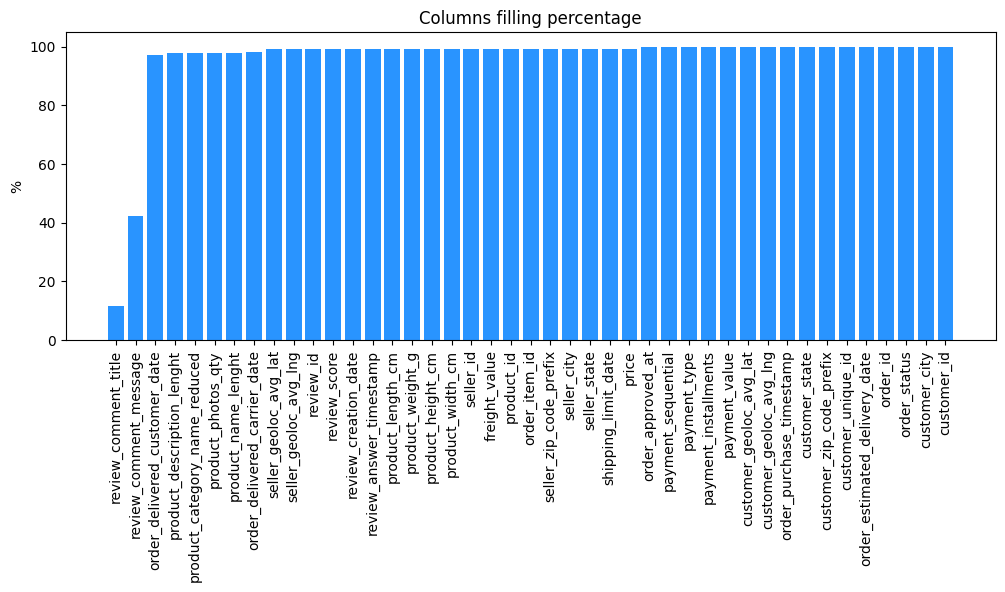

In [87]:
# ------------------------------
# Column filling visualization
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(info_all_data_olist["Variable"],
       info_all_data_olist["Filling percentage"], color="#2994ff")
ax.set_ylabel("%")
ax.set_title("Columns filling percentage")
plt.xticks(rotation=90)
plt.tight_layout
plt.show()

---
---
<a id='row_filling'></a>

## <font color = '#0085dd'>Row filling analysis </font>
    

In [88]:
# ----------------------------------------------------
# Create a copy of the dataset for the fill analysis
# ----------------------------------------------------
df_complet = all_data_olist.copy()

# Number of data by row
df_complet["data_count"] = df_complet.count(axis=1)  # axis = 1; rows

In [89]:
# -----------------------------
# Calculation of row filling
# -----------------------------
df_complet["Percent_fill_rows"] = df_complet["data_count"]\
    * 100/df_complet.shape[1]

minPercent_fill = round(df_complet["Percent_fill_rows"].min(), 2)
maxPercent_fill = round(df_complet["Percent_fill_rows"].max(), 2)
print("The minimal percentage filling is " + str(minPercent_fill)
      + "% and the maximal is " + str(maxPercent_fill) + "%.\n")

The minimal percentage filling is 34.09% and the maximal is 97.73%.



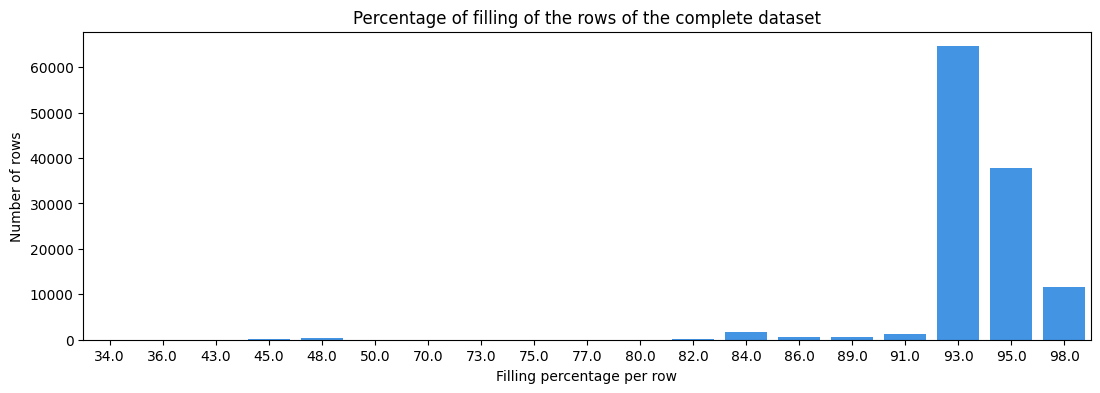

In [90]:
# ---------------------------
# Row filling visualization
# ---------------------------
plt.figure(figsize=(13, 4))
sns.countplot(x=round(df_complet["Percent_fill_rows"], 0), color='#2994ff')

plt.title("Percentage of filling of the rows of the complete dataset")
plt.ylabel("Number of rows")
plt.xlabel("Filling percentage per row")
plt.show()


---
<a id='features_preSelection'></a>

## <font color = '#0085dd'>Features pre-selection</font>

The business analysis and the filling analysis allow us to make a first selection of the variables.

**Variables to be discarded**

| **Variable** | **Argument** |
| --- | --- |
| **customer_id** | Provides the same information as order_id |
| **customer_zip_code_prefix** | We give priority to latitude and longitude data|
| **customer_city** | We give priority to latitude and longitude data|
| **order_approved_at**| Information not considered essential |
| **shipping_limit_date** | Information not considered essential |
| **review_id** | Was only useful for linking the data sets |
| **review_comment_title** | Lack of information |
| **review_comment_message** | Lack of information |
| **review_creation_date** | Information not considered essential |
| **review_answer_timestamp** | Information not considered essential |
| **seller_zip_code_prefix** | We give priority to latitude and longitude data |
| **seller_city** | We give priority to latitude and longitude data |
| **seller_state** | We give priority to latitude and longitude data |


In [91]:
# Variables to drop
first_discarded = ["customer_id", "customer_zip_code_prefix",
                   "customer_city", "order_approved_at",
                   "shipping_limit_date", "review_id",
                   "review_comment_title", "review_comment_message",
                   "review_creation_date", "review_answer_timestamp",
                   "seller_zip_code_prefix", "seller_city", "seller_state"]


<a id='date_errors'></a>

### <font color = '#0075bc'> Verification of the absence of date errors </font>

In [92]:
# The order was approved before it was purchased
all_data_olist.loc[(all_data_olist["order_purchase_timestamp"] >
                    all_data_olist["order_approved_at"])]

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, customer_geoloc_avg_lat, customer_geoloc_avg_lng, order_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, product_category_name_reduced, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp, seller_zip_code_prefix, seller_city, seller_state, seller_geoloc_avg_lat, seller_geoloc_avg_lng]
Index: []

[0 rows x 43 columns]

In [93]:
# The order was shipped before it was purchased
all_data_olist.loc[all_data_olist["order_purchase_timestamp"] >
                   all_data_olist["shipping_limit_date"]]

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, customer_geoloc_avg_lat, customer_geoloc_avg_lng, order_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, product_category_name_reduced, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp, seller_zip_code_prefix, seller_city, seller_state, seller_geoloc_avg_lat, seller_geoloc_avg_lng]
Index: []

[0 rows x 43 columns]

In [94]:
# The carriers received the order before the order was purchased
carriers_before_purchase = all_data_olist.loc[
    all_data_olist["order_purchase_timestamp"] >
    all_data_olist["order_delivered_carrier_date"]]

# remove these rows
all_data_olist = all_data_olist.drop(
    index=carriers_before_purchase.index.tolist())
carriers_before_purchase.head()

customer_id                customer_unique_id  \
1116  a125a54036b56ceb4c73638eda0f18aa  19067e6acbb88e562f0f58eca762ac76   
1618  b58a35cb4e1a1f9ea74dcf0b2639a9ac  fd837fa3548f0e74f75081f38a34e56b   
1760  3088cc4bfafe311f1d84830808c2aa6d  2f0def88a867b9c0aabb60c561b4d640   
2823  e489861e700dfc79e5347bbf75b472e0  44191aeadca96c5a073edb7f09ceee05   
3857  52f41b570c31d5f465eea3427b30334e  fc0334b0e1e56824d1886ffc4b7d2f36   

     customer_zip_code_prefix  customer_city customer_state  \
1116                    26015    nova iguacu    NOVA IGUACU   
1618                    93510  novo hamburgo  NOVO HAMBURGO   
1760                    09991        diadema        DIADEMA   
2823                    13495   iracemapolis   IRACEMAPOLIS   
3857                    17602           tupa           TUPA   

      customer_geoloc_avg_lat  customer_geoloc_avg_lng  \
1116               -22.744987               -43.439115   
1618               -29.682441               -51.123471   
1760               -23.695094               -46.612240   
2823               -22.586590               -47.514345   
3857               -21.930548               -50.498348   

                              order_id order_status  order_purchase_timestamp  \
1116  69aca49c98f05af05bec6fa1f87a3059    delivered 2018-07-20 13:19:19+00:00   
1618  db090a16182b263b1e896bb26c6f66cf    delivered 2018-07-13 16:14:08+00:00   
1760  f7780ea2807db31691e83f0013294035    delivered 2018-07-30 15:22:15+00:00   
2823  3b40ede283844ba0fbdd110f8a56792f    delivered 2018-07-18 14:35:41+00:00   
3857  c6f11a51ee3384a11e50cc55dc685c24    delivered 2018-08-15 14:02:44+00:00   

      ... review_score review_comment_title          review_comment_message  \
1116  ...          5.0            Muito bom                             NaN   
1618  ...          5.0                  NaN  Produto muito bom a princípio    
1760  ...          5.0                  NaN                             NaN   
2823  ...          5.0                  NaN                             NaN   
3857  ...          4.0                  NaN                             NaN   

          review_creation_date   review_answer_timestamp  \
1116 2018-07-26 00:00:00+00:00 2018-07-26 20:44:55+00:00   
1618 2018-07-28 00:00:00+00:00 2018-07-28 15:12:51+00:00   
1760 2018-08-04 00:00:00+00:00 2018-08-04 10:47:42+00:00   
2823 2018-07-26 00:00:00+00:00 2018-07-29 10:25:41+00:00   
3857 2018-08-22 00:00:00+00:00 2018-08-22 13:41:24+00:00   

     seller_zip_code_prefix           seller_city seller_state  \
1116                  85200               pitanga           PR   
1618                  03006             sao paulo           SP   
1760                  03564             sao paulo           SP   
2823                  14940              ibitinga           SP   
3857                  13232  campo limpo paulista           SP   

      seller_geoloc_avg_lat  seller_geoloc_avg_lng  
1116             -24.757846             -51.765958  
1618             -23.541812             -46.624550  
1760             -23.535169             -46.497268  
2823             -21.757321             -48.829744  
3857             -23.211746             -46.762875  

[5 rows x 43 columns]

In [95]:
# The customer received the order before puchase it
all_data_olist.loc[all_data_olist["order_purchase_timestamp"] >
                   all_data_olist["order_delivered_customer_date"]]

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, customer_geoloc_avg_lat, customer_geoloc_avg_lng, order_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, product_category_name_reduced, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp, seller_zip_code_prefix, seller_city, seller_state, seller_geoloc_avg_lat, seller_geoloc_avg_lng]
Index: []

[0 rows x 43 columns]

In [96]:
# The review was created before the purchase
review_before_purchase = all_data_olist.loc[
    all_data_olist["order_purchase_timestamp"] >
    all_data_olist["review_answer_timestamp"]]

# remove these rows
all_data_olist = all_data_olist.drop(
    index=review_before_purchase.index.tolist())

review_before_purchase.head()

customer_id                customer_unique_id  \
1278  ad2eb5d02c0808bcd8743117f6383cf6  ef0103e9602d12594d19c2b666219bc1   
1948  82d98198f7fb1687858e03a5322e1621  b351ac91ab0ef29bae6da7fbc05959c0   
3859  b1253701171dfb298f52a221f824e45b  788313d21c3507fe890921f6e17aa679   
4506  a73c1f73f5772cf801434bf984b0b1a7  968fac81e2c44fb6c1e3ac2a45e6a102   
5042  8c468917b274857623298a1627369866  5562519ab10ca3a2bcafca081618d2ea   

     customer_zip_code_prefix   customer_city  customer_state  \
1278                    30810  belo horizonte  BELO HORIZONTE   
1948                    80420        curitiba        CURITIBA   
3859                    11070          santos          SANTOS   
4506                    04685       sao paulo       SAO PAULO   
5042                    35500     divinopolis     DIVINOPOLIS   

      customer_geoloc_avg_lat  customer_geoloc_avg_lng  \
1278               -19.897717               -43.985176   
1948               -25.437578               -49.281917   
3859               -23.956748               -46.345272   
4506               -23.663211               -46.693516   
5042               -20.140360               -44.884080   

                              order_id order_status  order_purchase_timestamp  \
1278  bd35b677fd239386e9861d11ae98ab56     canceled 2018-09-17 17:21:16+00:00   
1948  38a86eb53c2309d6234fc9bad96331ac     canceled 2018-08-18 12:39:31+00:00   
3859  afed0d88ec7753e7be8744bb66e860d1     canceled 2018-08-02 15:23:07+00:00   
4506  4637ca194b6387e2d538dc89b124b0ee     canceled 2018-09-03 14:14:25+00:00   
5042  2bb02fdf5637a68cd5d13c78c37c3376     canceled 2018-08-09 10:55:10+00:00   

      ... review_score       review_comment_title  \
1278  ...          2.0  Carteira de couro marrom    
1948  ...          1.0         produto danificado   
3859  ...          1.0  Nota zero. Produto falso!   
4506  ...          3.0           Produto Avariado   
5042  ...          2.0                    Defeito   

                                 review_comment_message  \
1278  O produto veio com defeito! Espero que não dem...   
1948  Meu produto chegou todo quebrado, quero trocar...   
3859                      Falso e com arranhões na tela   
4506  Recebi o Diario do Bebê c um pequeno rasgo na ...   
5042  Produto c defeito, tentei por várias vezes, ma...   

          review_creation_date   review_answer_timestamp  \
1278 2018-08-29 00:00:00+00:00 2018-08-31 22:29:09+00:00   
1948 2018-08-14 00:00:00+00:00 2018-08-16 12:46:30+00:00   
3859 2018-07-28 00:00:00+00:00 2018-07-29 11:14:13+00:00   
4506 2018-08-17 00:00:00+00:00 2018-08-18 15:32:40+00:00   
5042 2018-08-01 00:00:00+00:00 2018-08-04 09:51:18+00:00   

     seller_zip_code_prefix seller_city seller_state  seller_geoloc_avg_lat  \
1278                    NaN         NaN          NaN                    NaN   
1948                    NaN         NaN          NaN                    NaN   
3859                    NaN         NaN          NaN                    NaN   
4506                    NaN         NaN          NaN                    NaN   
5042                    NaN         NaN          NaN                    NaN   

      seller_geoloc_avg_lng  
1278                    NaN  
1948                    NaN  
3859                    NaN  
4506                    NaN  
5042                    NaN  

[5 rows x 43 columns]


<a id='delivered_order'></a>

### <font color = '#0075bc'> Reduce data to delivered orders </font>

In [97]:
# Remove all non deliverd informations
all_data_olist = all_data_olist.loc[all_data_olist["order_status"] ==
                                    "delivered"]

# Remove "order_status" column
all_data_olist = all_data_olist.drop(columns="order_status")
all_data_olist.shape

(115529, 42)


<a id='drop_columns'></a>

### <font color = '#0075bc'> Reduce data to pre-selected features </font>

In [98]:
reduced_data_olist = all_data_olist.drop(columns=first_discarded)
reduced_data_olist.shape

(115529, 29)

In [99]:
# Replace NaN values, when possible
reduced_data_olist["product_category_name_reduced"].fillna("unknown",
                                                           inplace=True)

# Drop all rows containing NaN values
reduced_data_olist = reduced_data_olist.dropna().reset_index(drop=True)
reduced_data_olist.shape

(112812, 29)


<a id='missing_data'></a>

### <font color = '#0075bc'> Missing data </font>

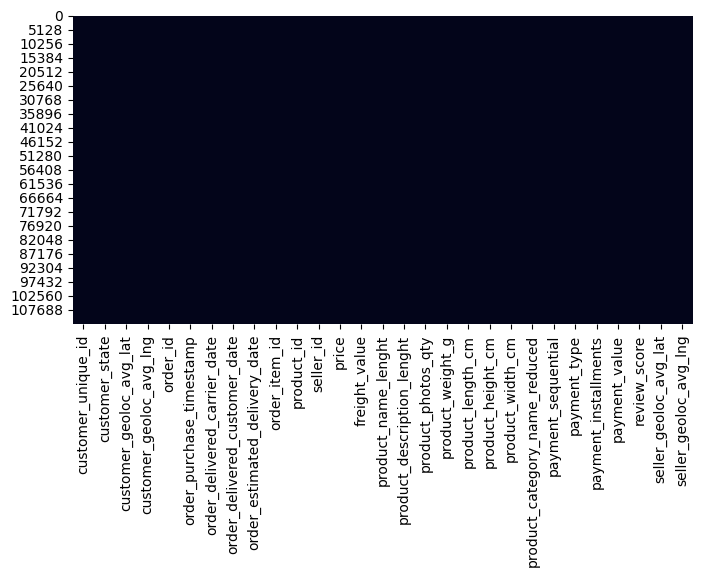

In [100]:
# ---------------------
# Missing values plot
# ---------------------
plt.figure(figsize=(8, 4))
sns.heatmap(reduced_data_olist.isnull(), cbar=False, cmap="rocket")
plt.show()

In [101]:
# Export data for stability analysis under different time periods

# Folder in which dataset will be saved
P5_cleaned = "/home/raquelsp/Documents/Openclassrooms/P5_segment_clients_eComerc/P5_travail/p5_cleaned"
os.chdir(P5_cleaned)

reduced_data_olist.to_csv("stabily_data_analysis.csv", index=False)

<a id='features_engineering'></a>

---
---

# <font color = '#26467a'>**Features engineering** </font>
    

---
<a id='customers_spatial_distribution'></a>

## <font color = '#0085dd'>Customers spatial distribution</font>

In [102]:
# --------------------------------
# Customers spatial distribution
# --------------------------------
dict_aggr_geo = {"customer_geoloc_avg_lat": 'mean',
                 "customer_geoloc_avg_lng": 'mean'}
df_geo = reduced_data_olist.groupby('customer_unique_id').agg(dict_aggr_geo)\
                                                                .reset_index()
df_geo.head()

customer_unique_id  customer_geoloc_avg_lat  \
0  0000366f3b9a7992bf8c76cfdf3221e2               -23.340235   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               -23.559115   
2  0000f46a3911fa3c0805444483337064               -27.542880   
3  0000f6ccb0745a6a4b88665a16c9f078                -1.312214   
4  0004aac84e0df4da2b147fca70cf8255               -23.505548   

   customer_geoloc_avg_lng  
0               -46.830140  
1               -46.787626  
2               -48.633426  
3               -48.483159  
4               -47.469705

---
<a id='RFM_features'></a>

## <font color = '#0085dd'> RFM features</font>


**RFM analysis** ranks each customer on the following factors:

*   **Recency**. How recent was the customer's last purchase? Recency is often measured in days.


In [103]:
# --------
# Recency
# --------
date_last_purchase = reduced_data_olist["order_purchase_timestamp"].max()\
    + datetime.timedelta(days=1)

dict_aggr_rfm = {"order_purchase_timestamp": lambda x:
                 (date_last_purchase - x.max()).days}
dict_rename_rfm = {"order_purchase_timestamp": "Recency"}


*   **Frequency**. How often did this customer make a purchase over the two years for those whom we have information?


In [104]:
# -----------
# Frequency
# -----------
dict_aggr_rfm["order_id"] = "count"
dict_rename_rfm["order_id"] = "Frequency"


*   **Monetary**. How much money did the customer spend over the two years for those whom we have information?


In [105]:
# ----------
# Monetary
# ----------
# Keep one entry per order
df_monetary = reduced_data_olist.drop_duplicates("order_id", keep="first")

df_monetary = df_monetary.groupby("customer_unique_id")["payment_value"]\
                                                        .sum().reset_index()

dict_rename_rfm["payment_value"] = "Monetary"

In [106]:
# Joining information on a RFM dataset
RFM_features = reduced_data_olist.groupby("customer_unique_id")\
                                          .agg(dict_aggr_rfm)
RFM_features = RFM_features.merge(df_monetary, on="customer_unique_id",
                                  how="outer")
RFM_features.rename(columns=dict_rename_rfm, inplace=True)
RFM_features = RFM_features.reset_index(drop=True)
RFM_features.shape
RFM_features.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89

---
<a id='products'></a>

## <font color = '#0085dd'> Products</font>
    

Development of columns to describe consumers through product-related information.

In [107]:
# -----------------
# Products volume
# -----------------
reduced_data_olist["product_volume_L"] =\
    reduced_data_olist["product_length_cm"]\
    * reduced_data_olist["product_height_cm"]\
    * reduced_data_olist["product_width_cm"]\
    / 1000

# ----------------------
# Average review score
# ----------------------
reduced_data_olist["review_score_avg"] = reduced_data_olist["review_score"]

In [108]:
# --------------------------------------------------
# Dictionary allowing aggregations through clients
# --------------------------------------------------

dict_aggr_products = {
    # Frequentmost_category
    "product_category_name_reduced": lambda x: x.mode()[0],
    # Average volume of products in L
    "product_volume_L": "mean",
    # # Average weight of products in g
    "product_weight_g" : "mean",
    # Average review score
    "review_score_avg" : "mean",
    # Total number of products bought
    "product_id" : "count",
    # Total number of reviews
    "review_score" : "count"}

In [109]:
# ------------------------------
# Dictionary to rename columns
# ------------------------------
dict_rename_products = {
    "product_category_name_reduced" :"frequentmost_category",
    "product_volume_L" : "average_vol_product_L",
    "product_weight_g" : "average_weight_product_g",
    "review_score_avg" : "average_review_score",
    "product_id": "total_num_products",
    "review_score" : "total_num_reviews"}

In [110]:
# Joining information on a RFM dataset
df_products = reduced_data_olist.groupby("customer_unique_id")\
                                          .agg(dict_aggr_products)
df_products.rename(columns=dict_rename_products, inplace=True)
df_products = df_products.reset_index()
df_products = df_products.drop(columns="total_num_reviews")
df_products.shape

(91160, 6)

---
<a id='Orders'></a>

## <font color = '#0085dd'> Orders</font>   

Preparation of columns to describe consumers through orders-related information.

In [111]:
# ---------------------------
# Number of items per order
# ---------------------------
item_per_order = reduced_data_olist.groupby("order_id")["order_item_id"].max()
reduced_data_olist["items_per_order"] = reduced_data_olist['order_id']\
                                                          .map(item_per_order)

reduced_data_olist["avg_items_per_order"] = \
                                        reduced_data_olist["items_per_order"]

# -----------------
# Price per order
# -----------------
value_per_order = reduced_data_olist.groupby("order_id")["payment_value"]\
                                            .max()
reduced_data_olist["value_per_order"] = reduced_data_olist['order_id']\
                                                        .map(value_per_order)

reduced_data_olist["avg_value_per_order"] =\
    reduced_data_olist["value_per_order"]

In [112]:
# --------------------------------------------------
# Dictionary allowing aggregations through clients
# --------------------------------------------------
dict_aggr_orders = {
    # Average number of items per order
    "avg_items_per_order": "mean",
    # Maximum number of items per order
    "items_per_order": "max",
    # Average price of orders
    "avg_value_per_order" : "mean",
    # Maximum price of orders
    "value_per_order" : "max", 
    # Maximum number of payment methods
    "payment_sequential" : "max",
    # Maximum number of payment installments
    "payment_installments" : "max",
    # Frequentmost Payment type
    "payment_type" : lambda x: x.mode()[0]
    }

In [113]:
# ------------------------------
# Dictionary to rename columns
# ------------------------------
dict_rename_orders = {"avg_items_per_order" :"average_items",
                      "items_per_order" : "max_items",
                      "avg_value_per_order" : "average_order_value",
                      "value_per_order" : "max_order_value",
                      "payment_sequential" : "max_sequential_payment",
                      "payment_installments" : "max_payment_installments",
                      "payment_type": "frequentmost_pay_type"
                      }

In [114]:
# Joining customer information per order
df_orders = reduced_data_olist.groupby("customer_unique_id")\
                                          .agg(dict_aggr_orders)
df_orders.rename(columns=dict_rename_orders, inplace=True)
df_orders = df_orders.reset_index()
df_orders.shape

(91160, 8)

---
<a id='dates'></a>

## <font color = '#0085dd'> Dates</font>
    


Preparation of columns to describe consumers through dates-related information.

In [115]:
# ----------------
# Month purchase
# ----------------
reduced_data_olist["month_purchase"] =\
    reduced_data_olist["order_purchase_timestamp"].dt.month

# --------------------------
# Day of the week purchase
# --------------------------
reduced_data_olist["dayofweek_purchase"] = \
    reduced_data_olist["order_purchase_timestamp"].dt.weekday

# ----------------------------------
# Deviation from the delivery date
# ----------------------------------
reduced_data_olist["delivery_date_deviation"] = \
    (reduced_data_olist["order_delivered_customer_date"]
     - reduced_data_olist["order_estimated_delivery_date"]).dt.days

reduced_data_olist["avg_delivery_date_deviation"] = \
    reduced_data_olist["delivery_date_deviation"]

reduced_data_olist["delay_delivery_date_deviation"] = \
    reduced_data_olist["delivery_date_deviation"]

In [116]:
# --------------------------------------------------
# Dictionary allowing aggregations through clients
# --------------------------------------------------
dict_aggr_dates = {
    # Frequentmost Month purchase
    "month_purchase": lambda x: x.mode()[0],
    # Frequentmost day of the week purchase
    "dayofweek_purchase": lambda x: x.mode()[0], 
    # Average deviation delivery date
    "avg_delivery_date_deviation" : "mean", 
    # Delivery delay
    "delay_delivery_date_deviation" : "max", 
    # Delivery advance
    "delivery_date_deviation" : "min"
    }

In [117]:
# ------------------------------
# Dictionary to rename columns
# ------------------------------
dict_rename_dates = {
    "month_purchase" :"frequentmost_month_purchase",
    "dayofweek_purchase" : "frequentmost_weekday_purchase",
    "avg_delivery_date_deviation" : "average_delivery_deviation",
    "delay_delivery_date_deviation" : "max_delivery_delay",
    "delivery_date_deviation" : "max_delivery_advance"
                     }

In [118]:
# Joining customer information per order
df_dates = reduced_data_olist.groupby("customer_unique_id")\
                                          .agg(dict_aggr_dates)
df_dates.rename(columns=dict_rename_dates, inplace=True)
df_dates = df_dates.reset_index()

df_dates["frequentmost_weekday_purchase"] = \
                      df_dates["frequentmost_weekday_purchase"]\
                      .replace({0: "Monday", 1: "Tuesday", 2 : "Wednesday",
                                3: "Thursday", 4: "Friday", 5: "Saturday",
                                6 : "Sunday" })

df_dates["frequentmost_month_purchase"] = \
                      df_dates["frequentmost_month_purchase"]\
                      .replace({1: "January", 2: "February", 3 : "March",
                                4: "April", 5: "May", 6: "June",
                                7 : "July", 8: "August", 9: "September",
                                10 : "October", 11: "November",
                                12: "December", })

df_dates.loc[df_dates["max_delivery_delay"]<0, "max_delivery_delay"] = 0
df_dates.loc[df_dates["max_delivery_advance"]>0, "max_delivery_advance"] = 0
df_dates["max_delivery_advance"] = df_dates["max_delivery_advance"].abs()

df_dates.shape
df_dates.head()

customer_unique_id frequentmost_month_purchase  \
0  0000366f3b9a7992bf8c76cfdf3221e2                         May   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                         May   
2  0000f46a3911fa3c0805444483337064                       March   
3  0000f6ccb0745a6a4b88665a16c9f078                     October   
4  0004aac84e0df4da2b147fca70cf8255                    November   

  frequentmost_weekday_purchase  average_delivery_deviation  \
0                      Thursday                        -5.0   
1                        Monday                        -5.0   
2                        Friday                        -2.0   
3                      Thursday                       -12.0   
4                       Tuesday                        -8.0   

   max_delivery_delay  max_delivery_advance  
0                   0                     5  
1                   0                     5  
2                   0                     2  
3                   0                    12  
4                   0                     8

---
<a id='join_customers_datasets'></a>

## <font color = '#0085dd'>Joining customers information</font>
    

In [119]:
# Join all informations
df_customers = df_geo\
    .merge(RFM_features, on="customer_unique_id", how='left')\
    .merge(df_products, on="customer_unique_id", how='left')\
    .merge(df_orders, on="customer_unique_id", how='left')\
    .merge(df_dates, on="customer_unique_id", how='left')

---
<a id='features_analysis'></a>

## <font color = '#0085dd'> Features analysis </font>
    

<span style='background:#00649a'><span style='color:white'>Geographic information</span></span>

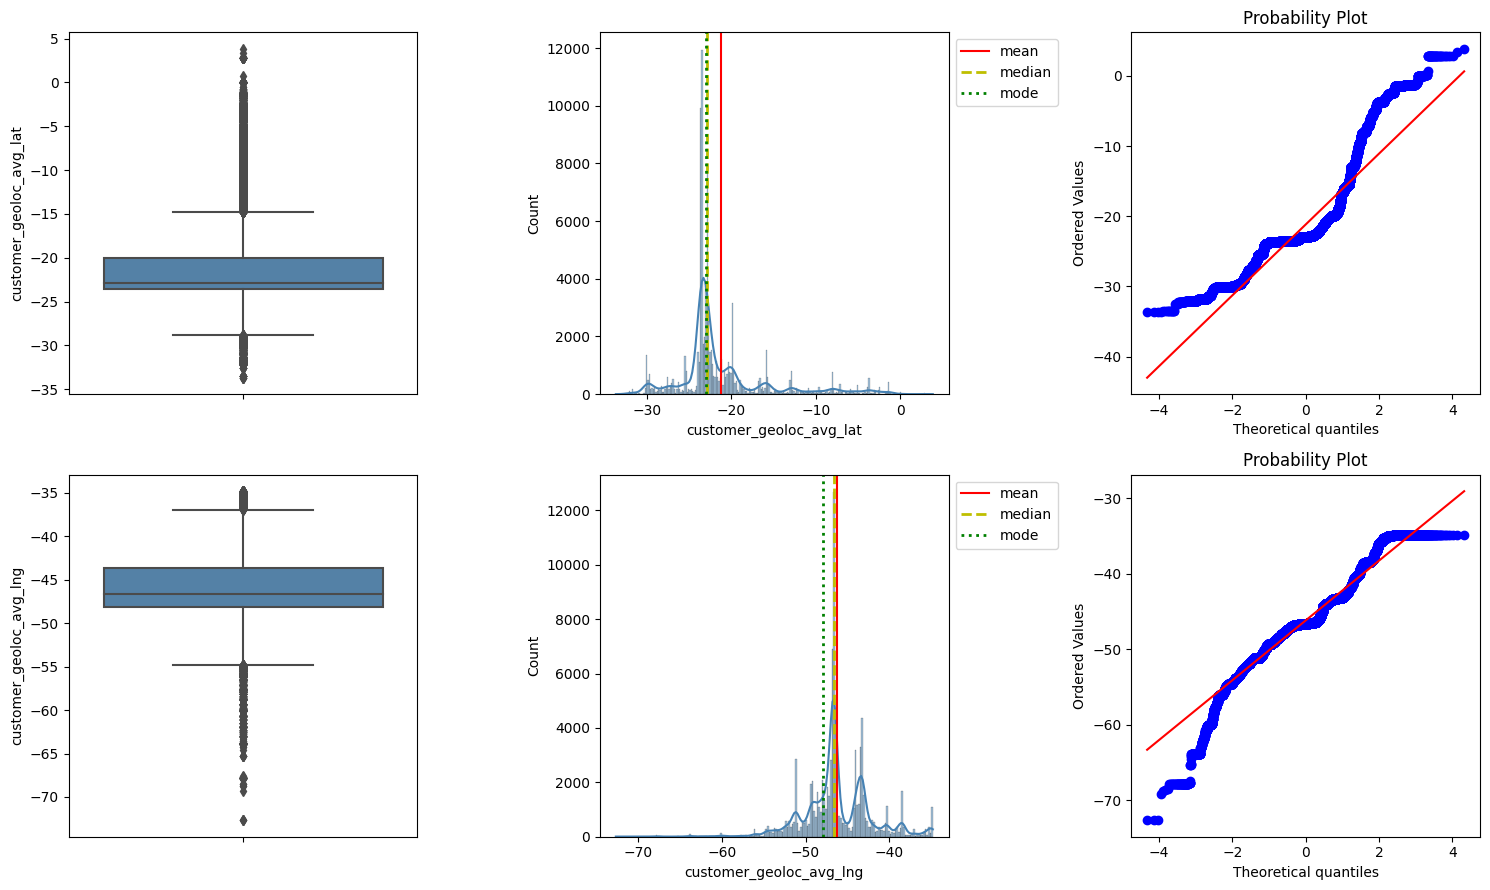

In [120]:
# -----------------------
# Customers geolocation
# -----------------------
df_cuanti_feat = df_customers[["customer_geoloc_avg_lat",
                               "customer_geoloc_avg_lng"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

Map of customers distribution :
<center><img src="./img/Brazil_customers.png" style="height: 400px;"/></center>

**Population density distribution in Brazil** ([source](https://commons.wikimedia.org/wiki/File:Population_density_Brazil_2020.svg))

<center><img src="./img/Population_density_Brazil_2020.png" style="height: 400px;"/></center>

The distribution and density of consumers seems to reflect the population density of brazil.

---

<span style='background:#00649a'><span style='color:white'>Behavioral information</span></span>

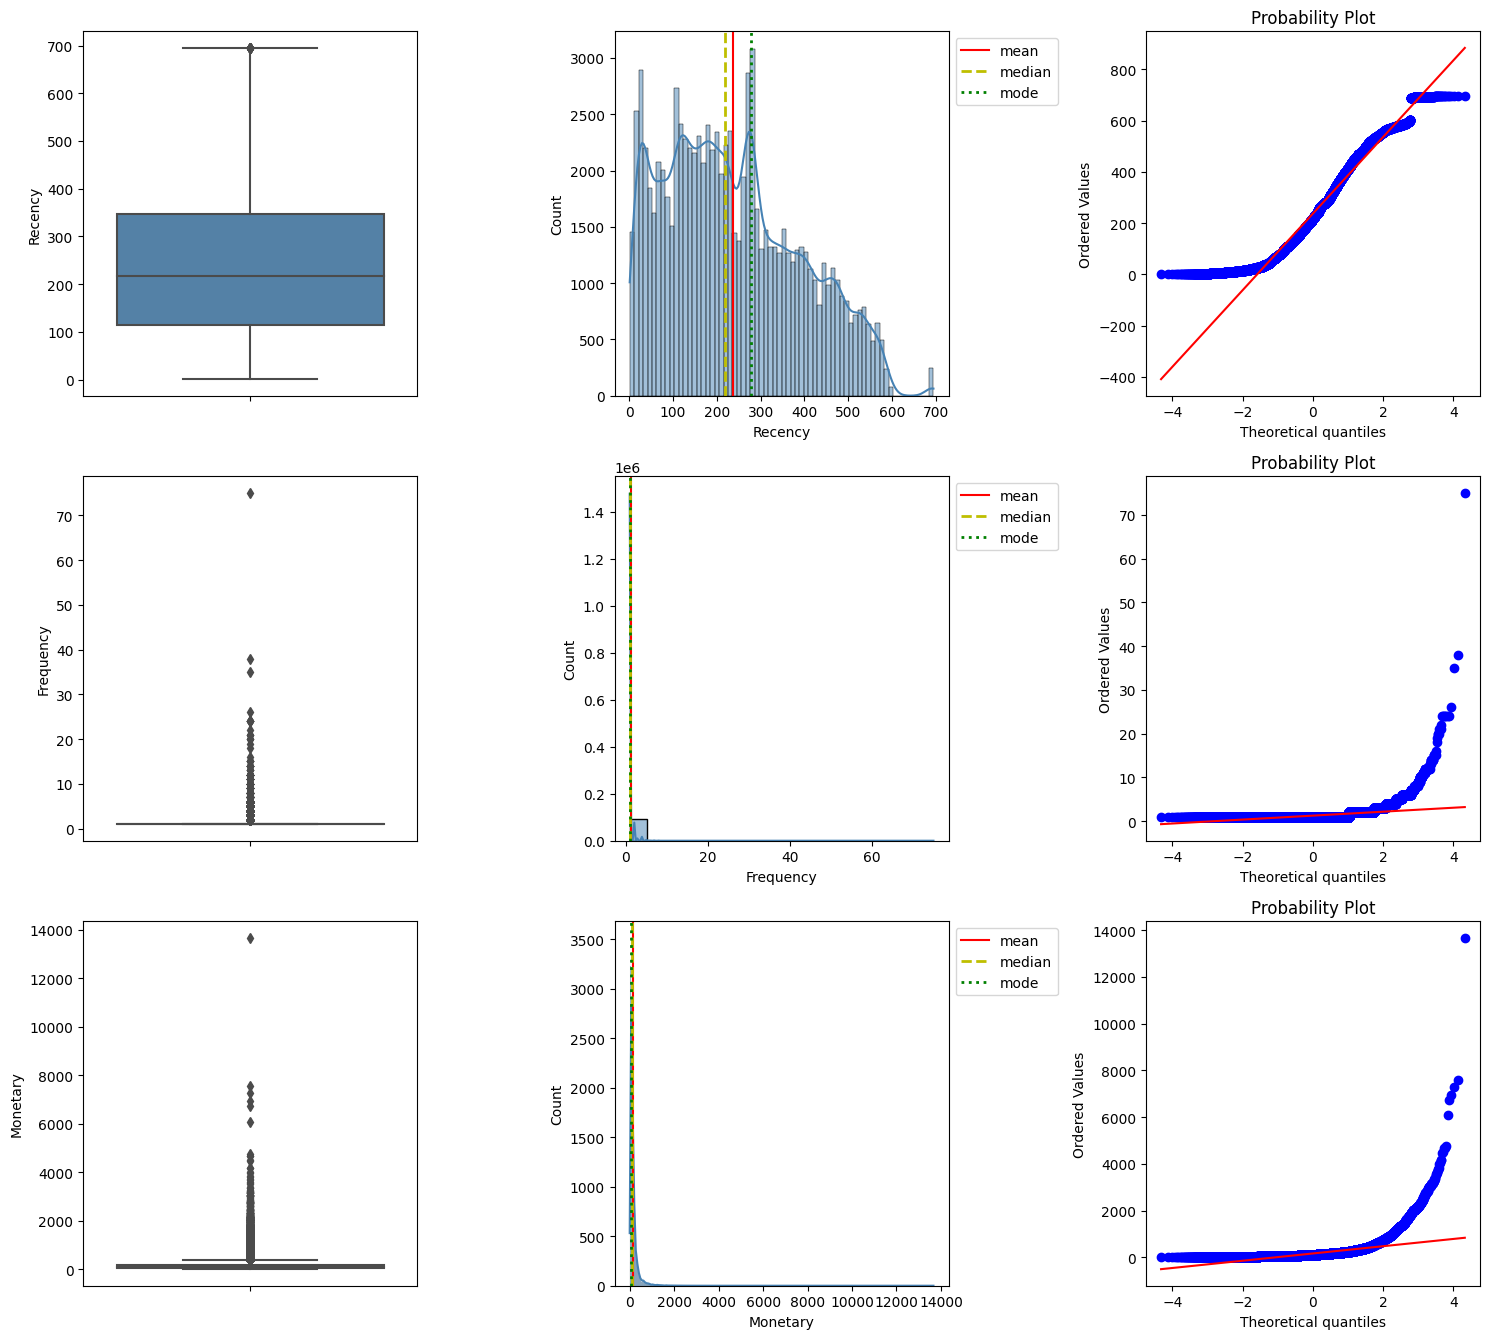

In [121]:
# ---------------------------------
# Recency, Frequency and Monetary
# ---------------------------------
df_cuanti_feat = df_customers[["Recency", "Frequency", "Monetary"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

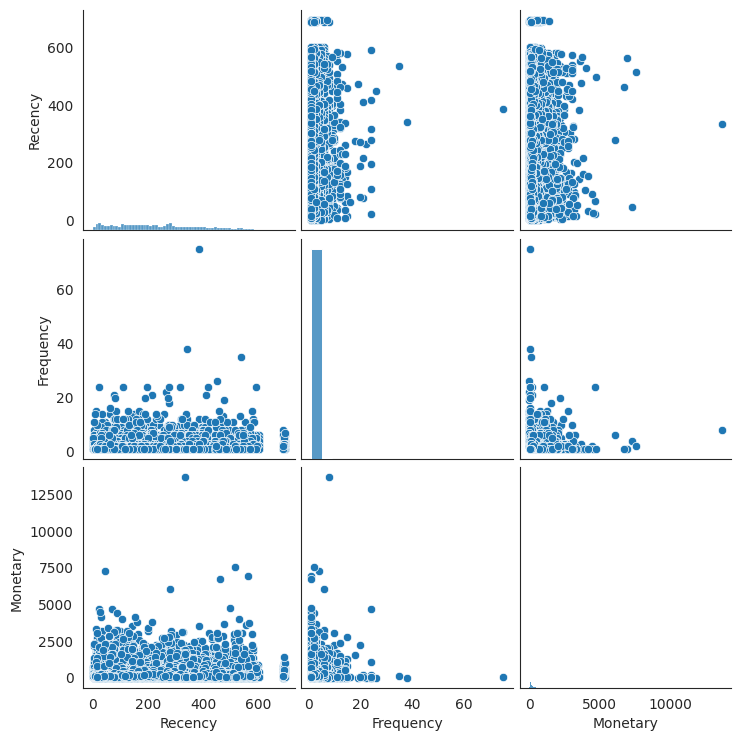

In [122]:
# Recency, frequency and monetary distribution
sns.set_style("white")
sns.pairplot(df_customers, vars=["Recency", "Frequency", "Monetary"],
             palette="blues")
plt.show()

In [123]:
# --------------------
# Column description
# --------------------
complet_description(df_customers[["Recency", "Frequency", "Monetary"]])

Variable     Type null Duplicated Filling percentage    count        mean  \
0    Recency    int64    0      90550              100.0  91160.0  237.391169   
1  Frequency    int64    0      91134              100.0  91160.0    1.237516   
2   Monetary  float64    0      63119              100.0  91160.0  162.434928   

          std   min    25%     50%      75%       max  
0  152.554934   1.0  114.0   218.0    346.0     695.0  
1    0.844672   1.0    1.0     1.0      1.0      75.0  
2  222.788299  0.01  61.27  105.74  180.535  13664.08

In [124]:
# Customers who have purchased more than twice
totalcustomers = df_customers.shape[0]
multibuyers = df_customers.loc[df_customers["Frequency"] > 2]
numberMultibuyers = multibuyers["customer_unique_id"].nunique()
percentMultibuyers = round((numberMultibuyers*100/df_customers.shape[0]), 2)

print(f"""From the {totalcustomers} customers in the dataset, {numberMultibuyers} have purchased more than twice, that means {percentMultibuyers}% of the customers""")

From the 91160 customers in the dataset, 3699 have purchased more than twice, that means 4.06% of the customers


The analysis of the distribution of the values of recency, frequency and monetary variables reveals that :
* The majority of consumers purchased in the last year
* Only a 4.1% of the customers have bought more than twice
* Three-quarters of customers have spent less than 180 brazilian reals
---

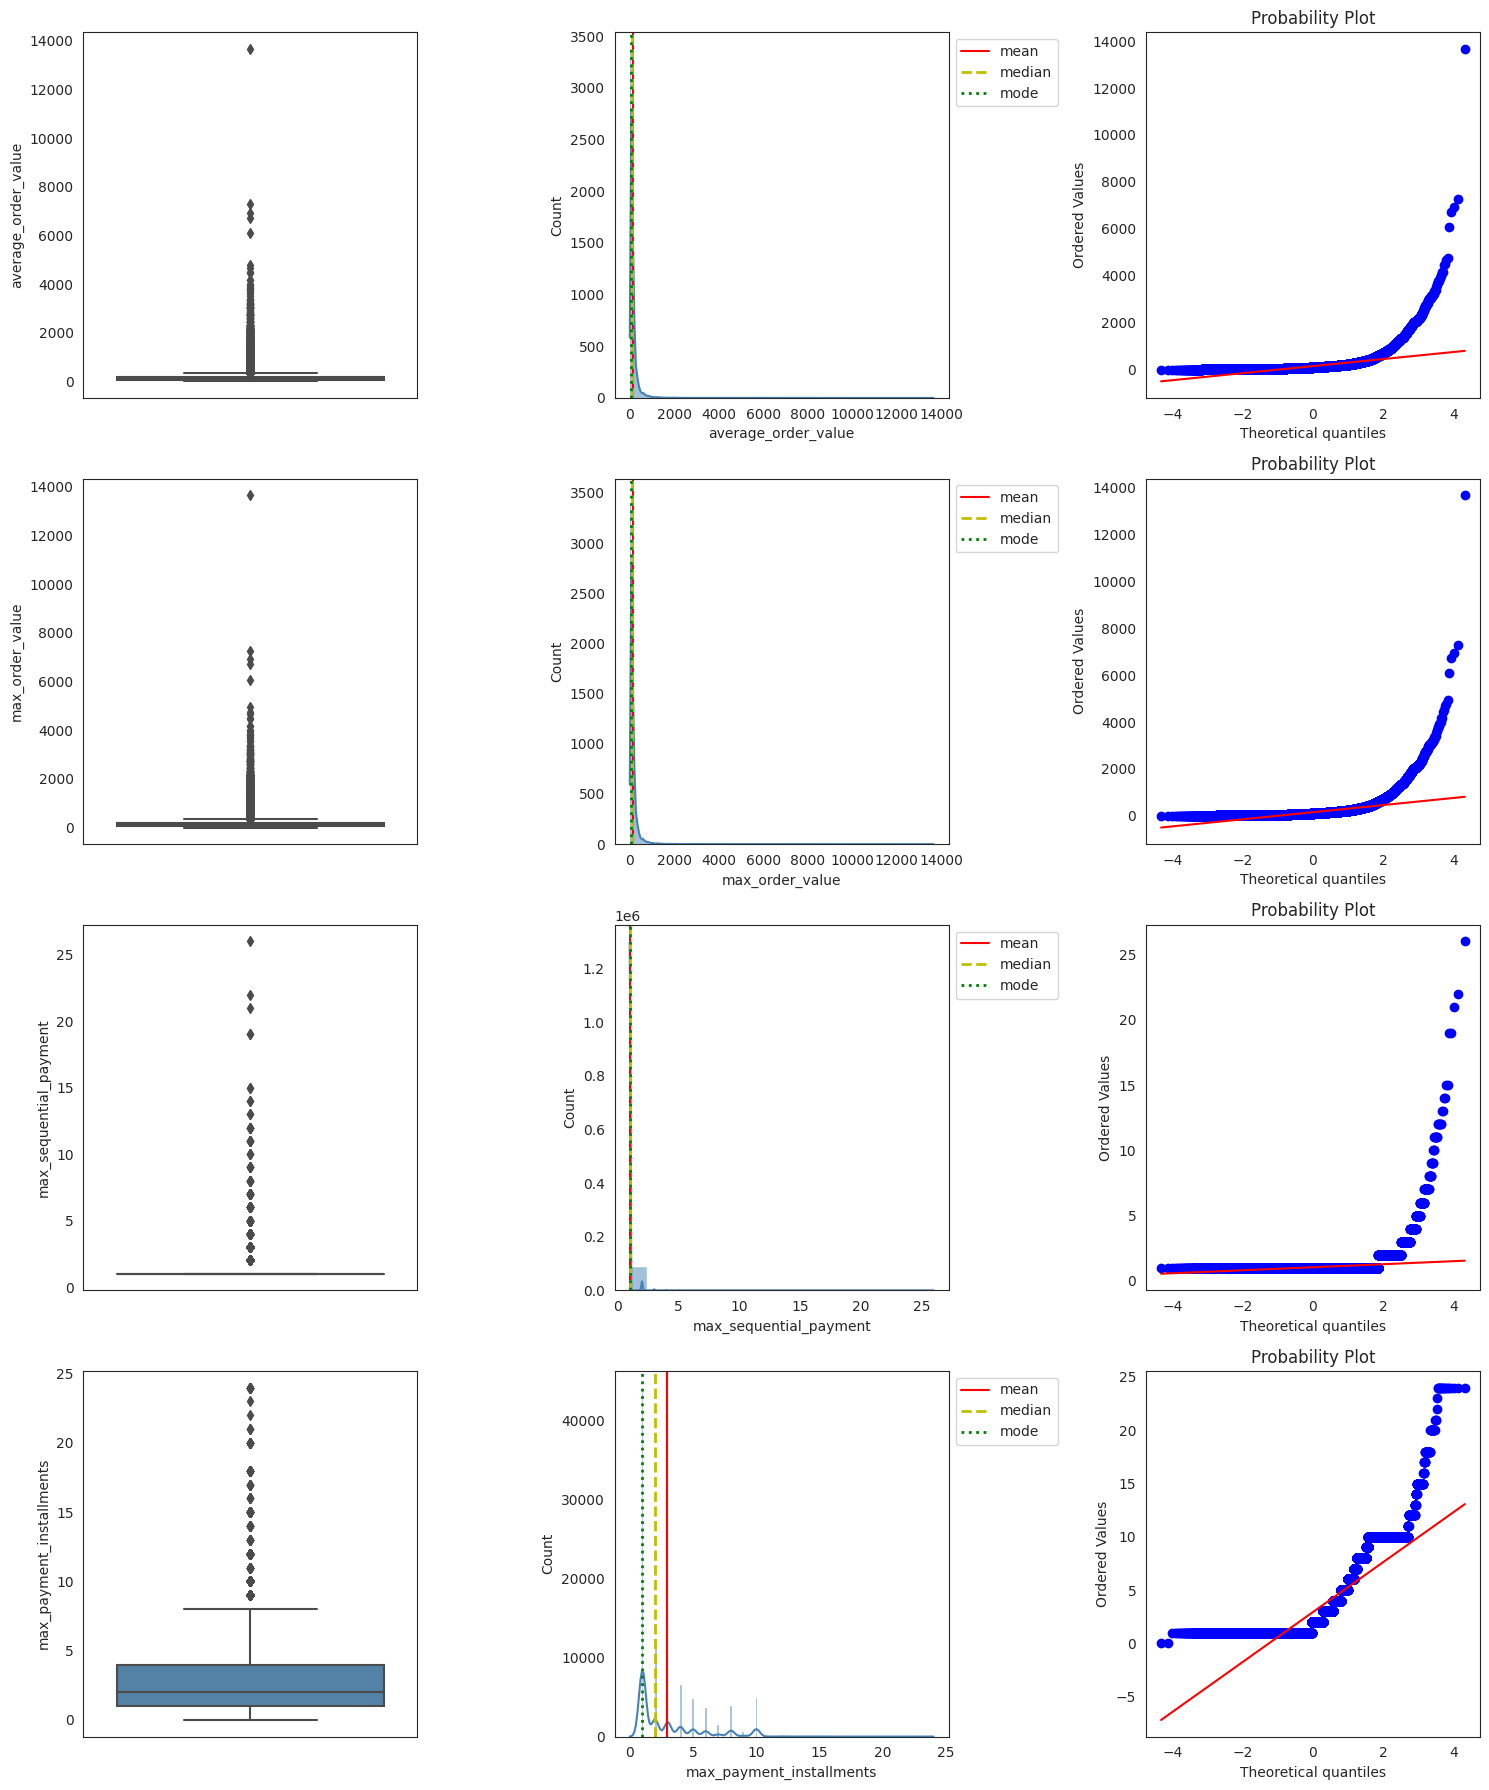

In [125]:
# --------------------
# Price and payments
# --------------------
df_cuanti_feat = df_customers[["average_order_value",
                               "max_order_value",
                               "max_sequential_payment",
                               "max_payment_installments"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

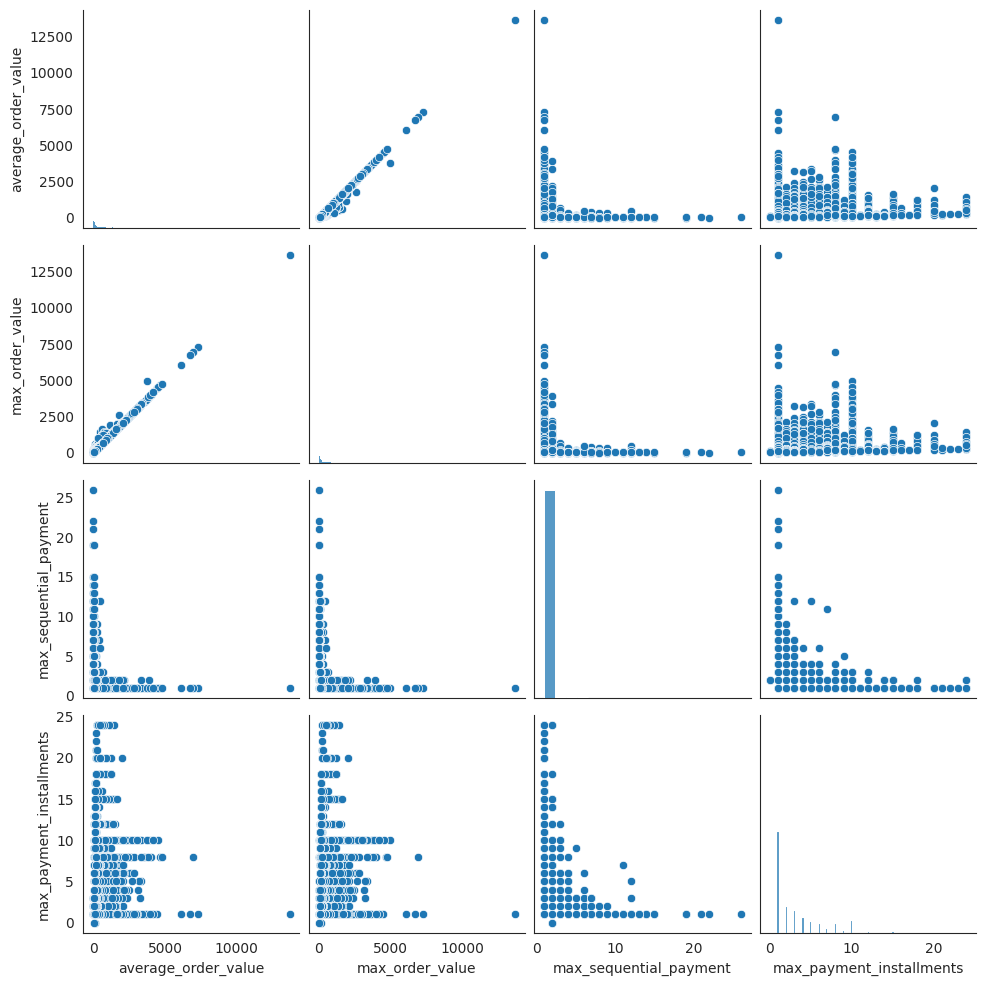

In [126]:
sns.set_style("white")
sns.pairplot(df_customers, vars=["average_order_value",
                                 "max_order_value",
                                 "max_sequential_payment",
                                 "max_payment_installments"], palette="blues")
plt.show()

In [127]:
# --------------------
# Column description
# --------------------
complet_description(df_customers[["average_order_value",
                                  "max_order_value",
                                  "max_sequential_payment",
                                  "max_payment_installments"]])

Variable     Type null Duplicated Filling percentage  \
0       average_order_value  float64    0      63049              100.0   
1           max_order_value  float64    0      64469              100.0   
2    max_sequential_payment  float64    0      91141              100.0   
3  max_payment_installments  float64    0      91136              100.0   

     count        mean         std   min      25%     50%       75%       max  
0  91160.0  158.945289  216.992581  4.07  61.4775  104.28    175.88  13664.08  
1  91160.0  160.263073  218.525266  4.07    61.75  105.16  177.4325  13664.08  
2  91160.0    1.045535    0.370183   1.0      1.0     1.0       1.0      26.0  
3  91160.0    2.939447    2.722856   0.0      1.0     2.0       4.0      24.0

The analysis of the distribution of the values of the variables associated with order prices, and the sequential payment and installments reveals that:
* Most of the orders cost between 4 and 180 brazilian reals
* There is a linear relationship between the average and the maximum value of each customer's orders
* Most orders are paid with only one method of payment
* Orders associated with the highest number of payment methods are not the most expensive
* Most orders were paid in less than four installments
* Orders with more installments are not the most expensive
---

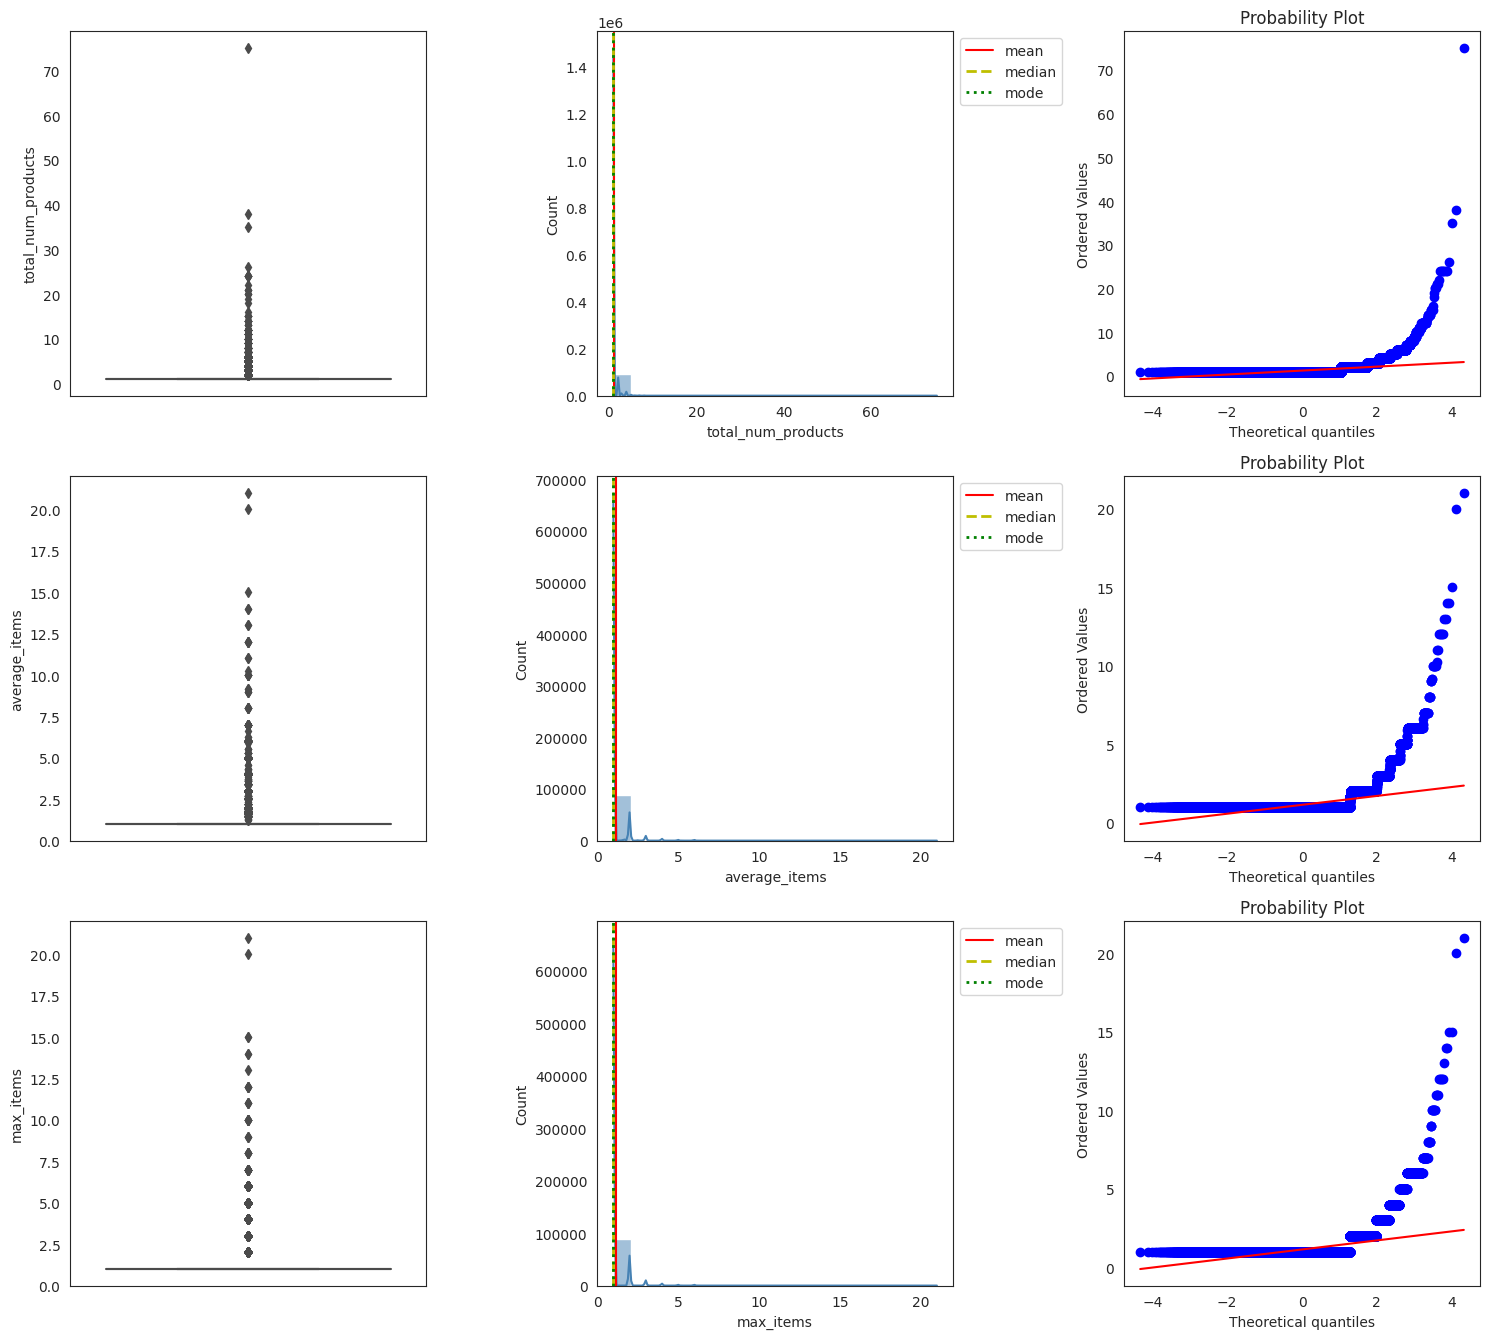

In [128]:
# -----------------
# Number of items
# -----------------
df_cuanti_feat = df_customers[["total_num_products", "average_items",
                               "max_items"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

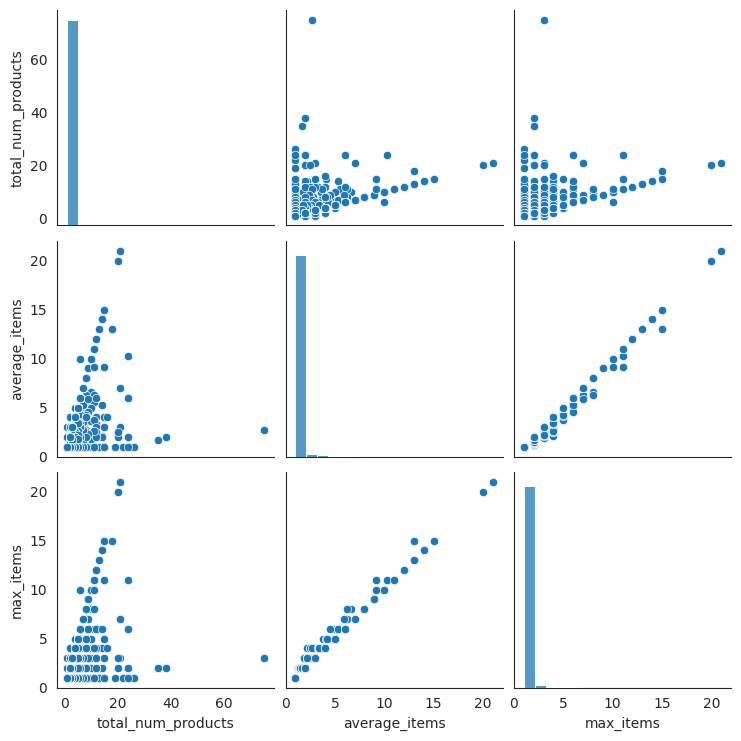

In [129]:
sns.set_style("white")
sns.pairplot(df_customers, vars=["total_num_products", "average_items",
                                 "max_items"], palette="blues")
plt.show()

In [130]:
# --------------------
# Column description
# --------------------
complet_description(df_customers[["total_num_products", "average_items",
                                  "max_items"]])

Variable     Type null Duplicated Filling percentage    count  \
0  total_num_products    int64    0      91134              100.0  91160.0   
1       average_items  float64    0      91099              100.0  91160.0   
2           max_items  float64    0      91143              100.0  91160.0   

       mean       std  min  25%  50%  75%   max  
0  1.237516  0.844672  1.0  1.0  1.0  1.0  75.0  
1  1.141018  0.530484  1.0  1.0  1.0  1.0  21.0  
2  1.143846  0.539073  1.0  1.0  1.0  1.0  21.0

The analysis of the quantity of products ordered indicates that :
* Linear relationship between the average and maximum number of products per order
* Most consumers' orders contain one product
---

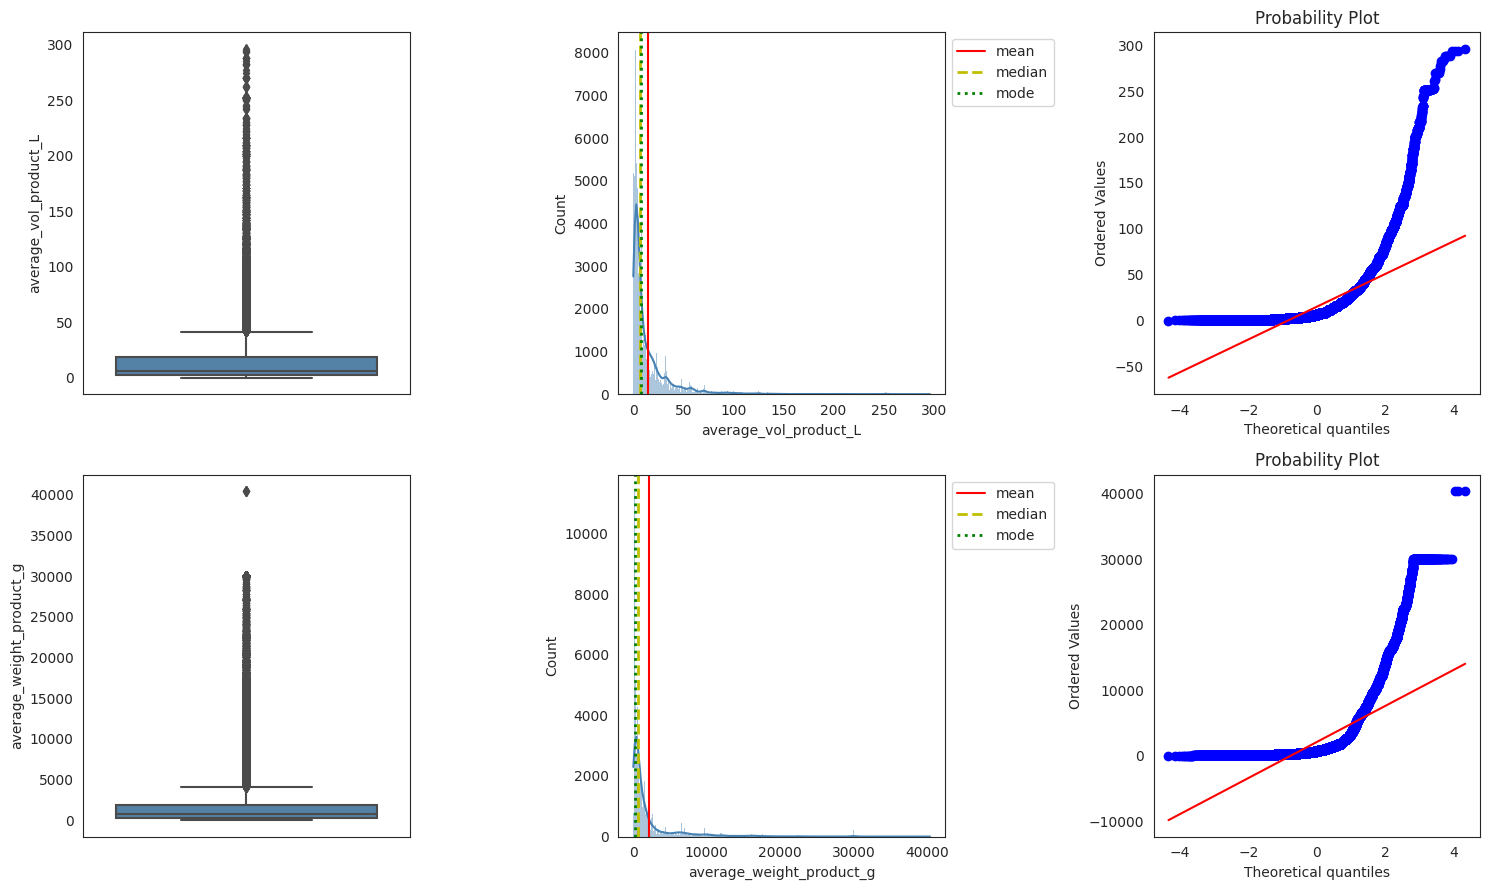

In [131]:
# ------------------
# Size of products
# ------------------
df_cuanti_feat = df_customers[["average_vol_product_L",
                               "average_weight_product_g"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

In [132]:
# --------------------
# Column description
# --------------------
complet_description(df_customers[["average_vol_product_L",
                                  "average_weight_product_g"]])

Variable     Type null Duplicated Filling percentage  \
0     average_vol_product_L  float64    0      83774              100.0   
1  average_weight_product_g  float64    0      87928              100.0   

     count         mean          std    min    25%    50%     75%      max  
0  91160.0    15.215101     23.15249  0.168  2.856    6.6    18.4  296.208  
1  91160.0  2102.278562  3722.848346    0.0  300.0  700.0  1825.0  40425.0

* Most of the products purchased occupy a volume of less than 20L and weigh less than 2kg.
---

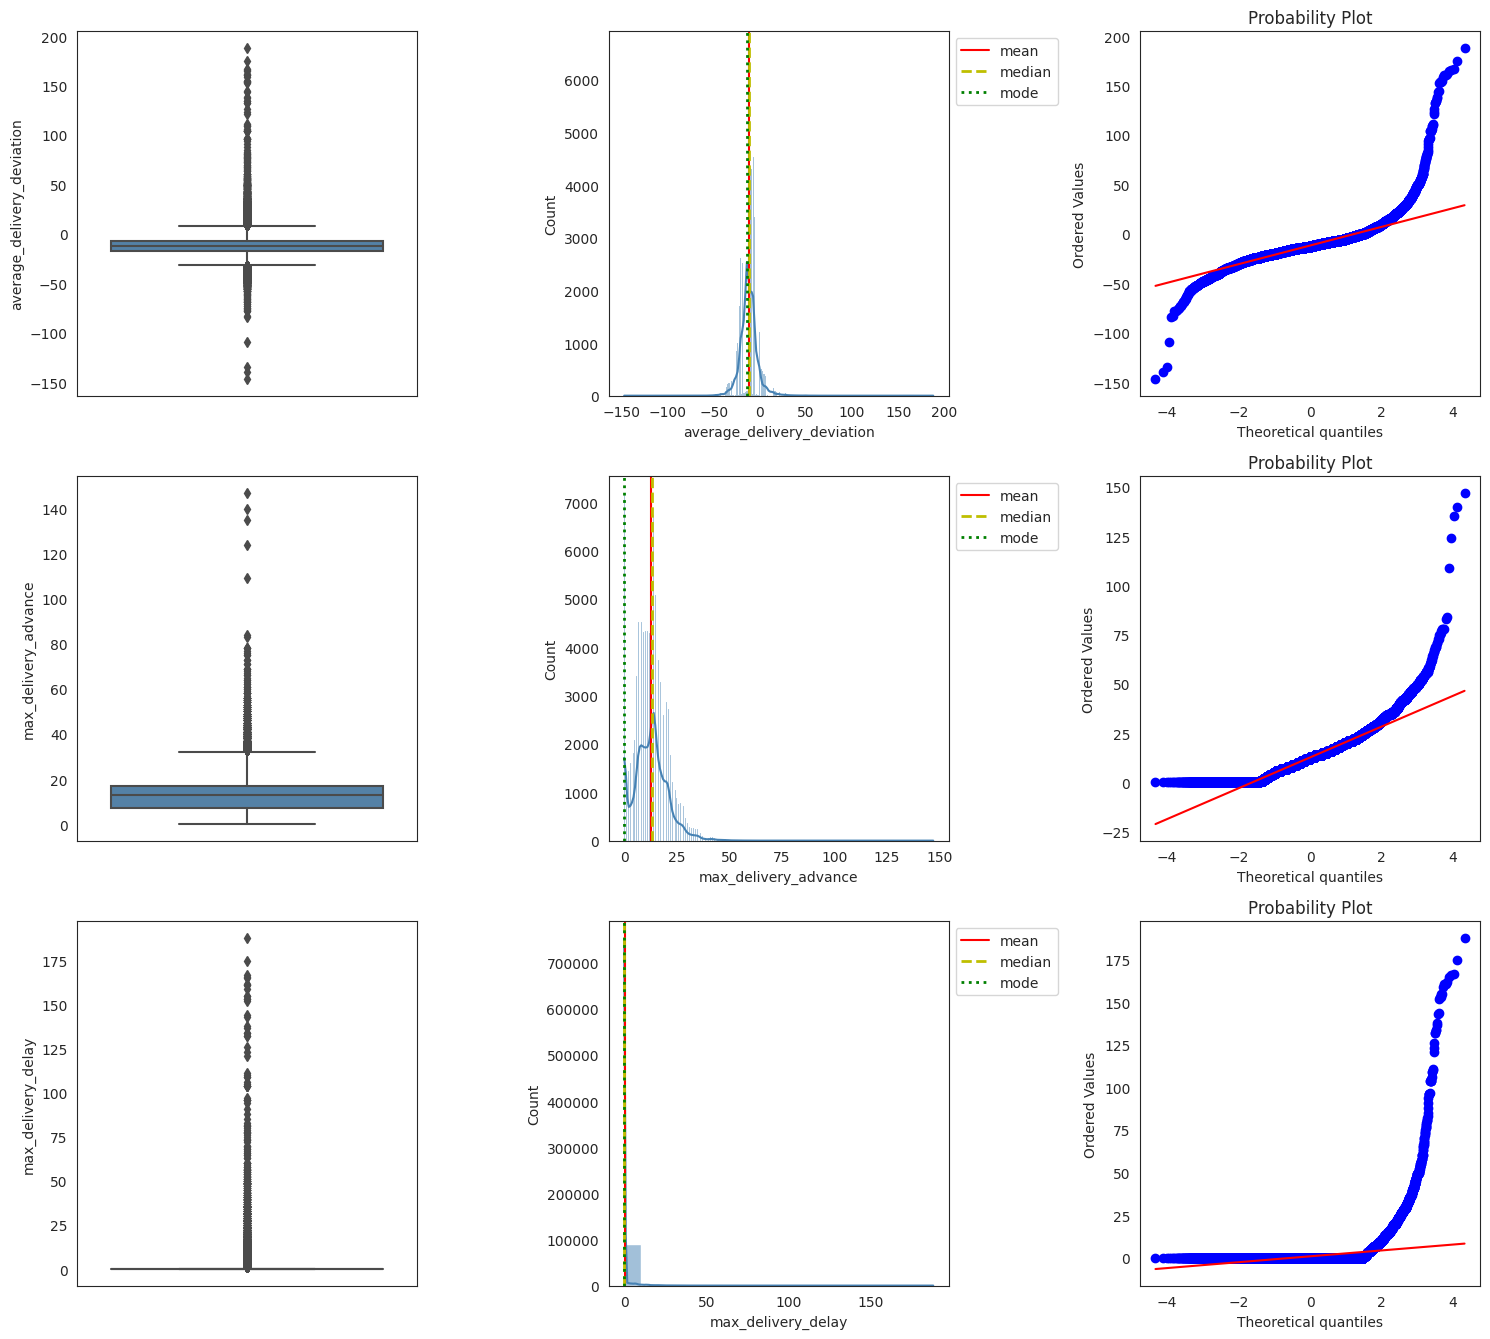

In [133]:
# -----------------------
# Delivery delay
# -----------------------
df_cuanti_feat = df_customers[["average_delivery_deviation",
                               "max_delivery_advance", "max_delivery_delay"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

In [134]:
# --------------------
# Column description
# --------------------
complet_description(df_customers[["average_delivery_deviation",
                                  "max_delivery_advance",
                                  "max_delivery_delay"]])

Variable     Type null Duplicated Filling percentage  \
0  average_delivery_deviation  float64    0      90698              100.0   
1        max_delivery_advance    int64    0      91077              100.0   
2          max_delivery_delay    int64    0      91048              100.0   

     count       mean        std    min   25%   50%   75%    max  
0  91160.0 -11.892437  10.073414 -147.0 -17.0 -12.0  -7.0  188.0  
1  91160.0  12.707054   8.018864    0.0   7.0  13.0  17.0  147.0  
2  91160.0   0.719241   4.622875    0.0   0.0   0.0   0.0  188.0

Delivery date deviation analysis (difference between the date on which the customer received the package and the date on which the delivery was initially scheduled, negative values of the deviation correspond to an advance of the delivery date and positive values to a delay) shows that :

* On average, orders are delivered 11 days in advance
---

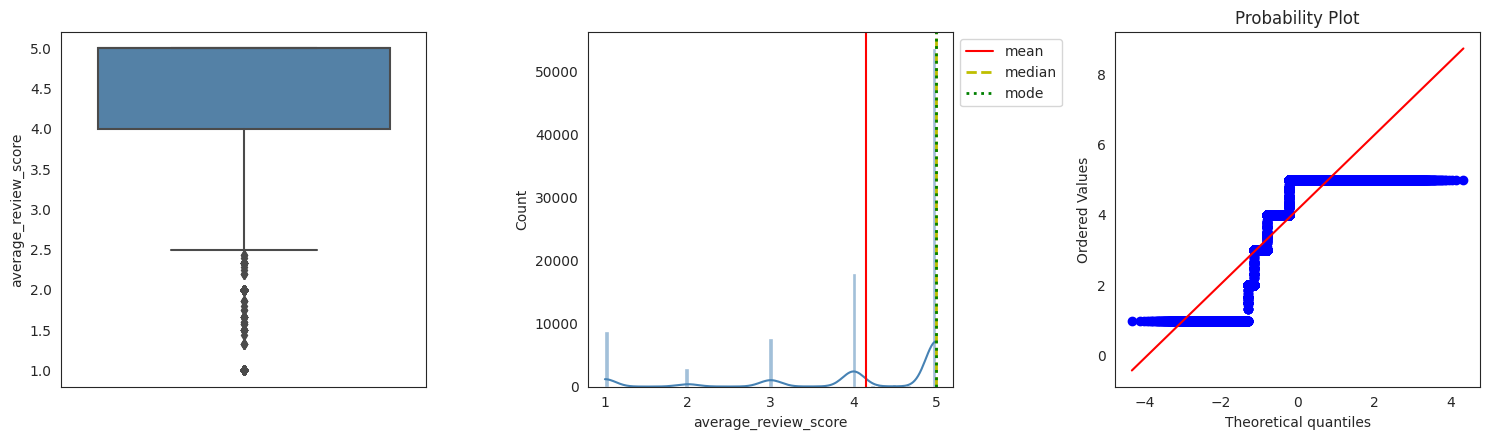

In [135]:
# ---------
# Reviews
# ---------
df_cuanti_feat = df_customers[["average_review_score"]]
list_cuanti_features = df_cuanti_feat.columns.tolist()
# Visualization
univ_quantit(list_cuanti_features, df_cuanti_feat)

In [136]:
# --------------------
# Column description
# --------------------
complet_description(df_customers[["average_review_score"]])

Variable     Type null Duplicated Filling percentage    count  \
0  average_review_score  float64    0      91097              100.0  91160.0   

       mean       std  min  25%  50%  75%  max  
0  4.154468  1.279332  1.0  4.0  5.0  5.0  5.0

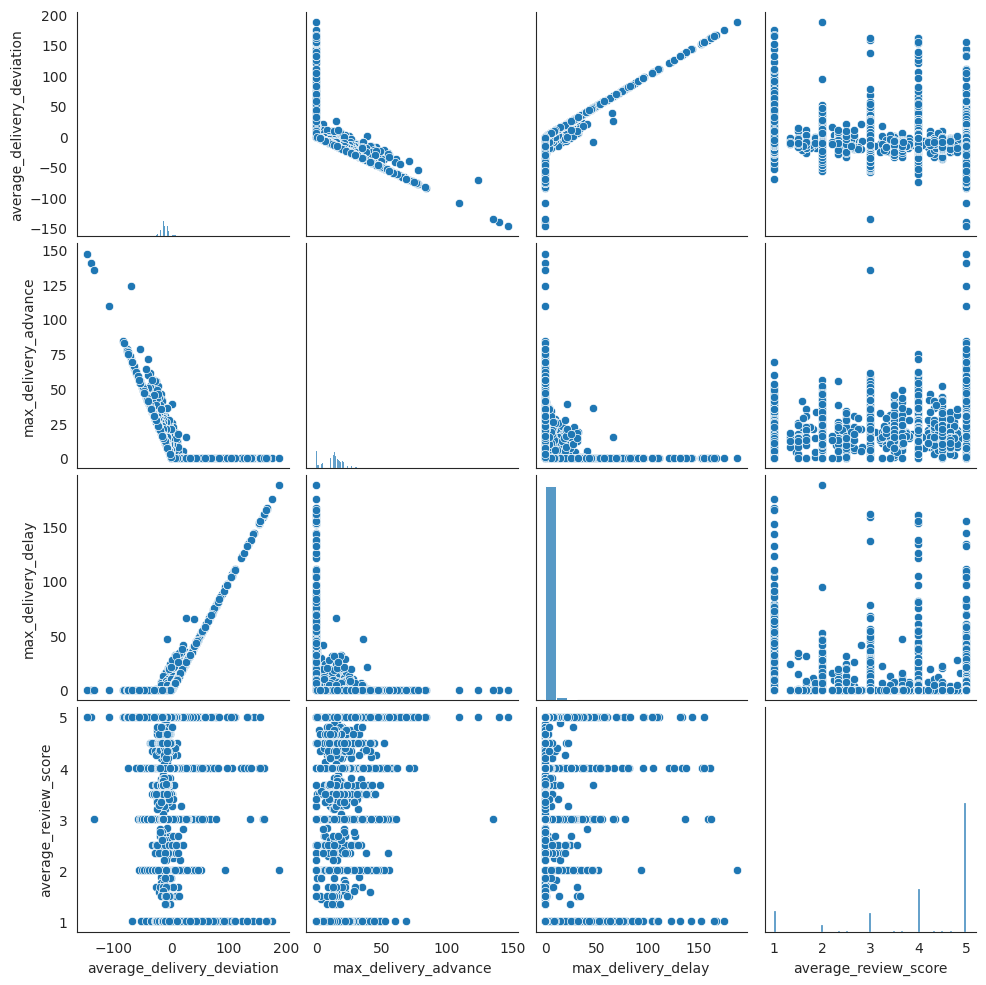

In [137]:
sns.set_style("white")
sns.pairplot(df_customers, vars=["average_delivery_deviation",
                                 "max_delivery_advance",
                                 "max_delivery_delay",
                                 "average_review_score"], palette="blues")
plt.show()

The majority of consumers participate in reviews and give good scores (above 4 out of 5).<br>
The combined analysis of the deviation of the delivery date and the participation and score of the reviews does not reveal an evident correlation between the variables.<br>

The average deviation from the delivery date combines the information of the advance and the delay of the delivery date.

---

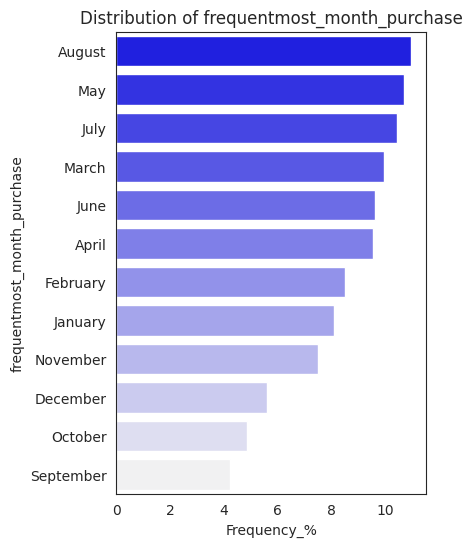

In [138]:
# -----------------------------
# Frequentmost month purchase
# -----------------------------
df_customers["frequentmost_month_purchase"] =\
                    df_customers["frequentmost_month_purchase"].astype(str)

univ_cate_vari(df_customers, 'frequentmost_month_purchase')

* More than 40% of orders are placed between May and August, which corresponds to the end of winter and spring in Brazil.
* Only 20% of orders are placed between November and January, which corresponds to the Brazilian summer.
---

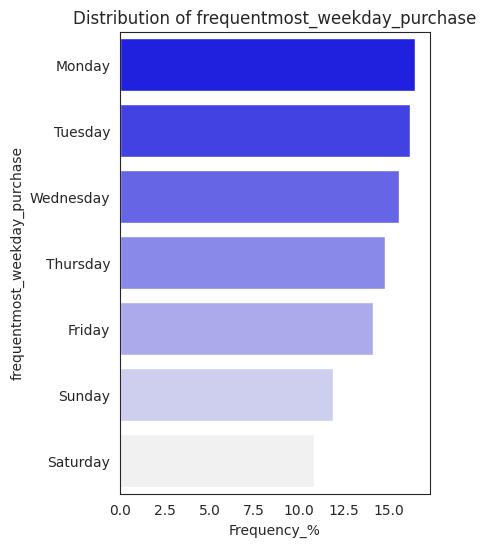

In [139]:
# -------------------------------
# Frequentmost weekday purchase
# -------------------------------
univ_cate_vari(df_customers, 'frequentmost_weekday_purchase')

* The distribution of purchases throughout the week is quite homogeneous.
* The day of the week that concentrates more purchases is Monday with 16.5%, the day of the week that concentrates less is Saturday with 10.9%.
---

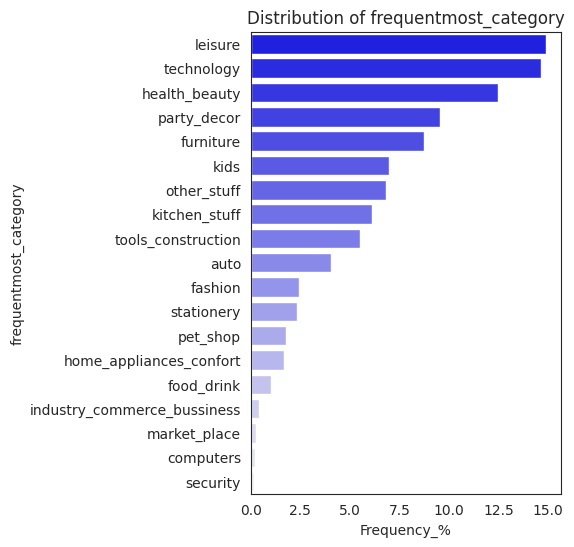

In [140]:
# ------------------------------
# Frequentmost category bougth
# ------------------------------
univ_cate_vari(df_customers, 'frequentmost_category')

Half of the purchases concern products in the leisure, technology, health and beauty and decoration categories.

---

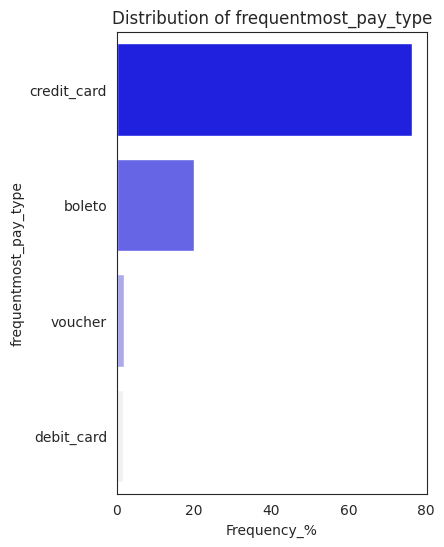

In [141]:
# -----------------------
# Frequentmost_pay_type
# -----------------------
univ_cate_vari(df_customers, 'frequentmost_pay_type')

Three quarters of the payments are made by credit card, 20% by boletos.

<a id='segmentation_dataset'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Dataset for segmentation** </span></span>


---
---

**Summary :**

The dataset for segmentation study, *customers_info_for_clustering.csv*,  consists of 93186 rows and 24 columns.
It informs about different aspects related to consumers, each consumer is identified by a unique code.

* The distribution and density of consumers (chart on the left) seems to reflect the population density of brazil (chart on the right).

<left><img src="./img/Brazil_customers.png" style="height: 400px;"/></left>
<right><img src="./img/Population_density_Brazil_2020.png" style="height: 400px;"/></right>


* The majority of consumers purchased in the last year
* Only a 4.1% of the customers have bought more than twice
* Three-quarters of customers have spent less than 180 brazilian reals

* Most of the orders cost between 4 and 180 brazilian reals
* There is a linear relationship between the average and the maximum value of each customer's orders, one of the features two will be deleted
* Most orders are paid with only one method of payment
* Orders associated with the highest number of payment methods are not the most expensive
* Most orders were paid in less than four installments
* Orders with more installments are not the most expensive

* Most of the products purchased occupy a volume of less than 20L and weigh less than 2kg.

* Linear relationship between the average and maximum number of products per order, one of the two features will be deleted
* Most consumers' orders contain one product

* Delivery date deviation analysis (difference between the date on which the customer received the package and the date on which the delivery was initially scheduled) shows that on average, orders are delivered 11 days in advance

* The majority of consumers participate in reviews and give good scores (above 4 out of 5).
* The combined analysis of the deviation of the delivery date and the participation and score of the reviews does not reveal an evident correlation between the variables.
* The average deviation from the delivery date combines the information of the advance and the delay of the delivery date, these features will be deleted.

* More than 40% of orders are placed between May and August, which corresponds to the end of winter and spring in Brazil.
* Only 20% of orders are placed between November and January, which corresponds to the Brazilian summer.

* The distribution of purchases throughout the week is quite homogeneous.
* The day of the week that concentrates more purchases is Monday with 16.5%, the day of the week that concentrates less is Saturday with 10.9%.

* Half of the purchases concern products in the leisure, technology, health and beauty and decoration categories.

* Three quarters of the payments are made by credit card, 20% by boletos.


In [142]:
# Variables to be dropped because of linear relationships
feat_drop = ["average_order_value", "average_items", "max_delivery_advance",
             "max_delivery_delay"]
df_customers = df_customers.drop(columns=feat_drop)

In [143]:

# Folder in which dataset will be saved
P5_cleaned = "/home/raquelsp/Documents/Openclassrooms/P5_segment_clients_eComerc/P5_travail/p5_cleaned"
os.chdir(P5_cleaned)

# Save a copy
df_customers.to_csv("customers_info_for_clustering.csv", sep="\t",
                    encoding="utf_8", index=False)

In [144]:
# --------------
# Dataset size
# --------------
print("The dataset for segmentation study contains " +
      str(df_customers.shape[0]) + " rows and " +
      str(df_customers.shape[1]) + " columns.\n")

# ---------------
# Data overview
# ---------------
# pd.options.display.max_columns = None
df_customers.head(3)

The dataset for segmentation study contains 91160 rows and 19 columns.



customer_unique_id  customer_geoloc_avg_lat  \
0  0000366f3b9a7992bf8c76cfdf3221e2               -23.340235   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               -23.559115   
2  0000f46a3911fa3c0805444483337064               -27.542880   

   customer_geoloc_avg_lng  Recency  Frequency  Monetary  \
0               -46.830140      112          1    141.90   
1               -46.787626      115          1     27.19   
2               -48.633426      537          1     86.22   

  frequentmost_category  average_vol_product_L  average_weight_product_g  \
0           party_decor                  7.616                    1500.0   
1         health_beauty                  5.148                     375.0   
2            stationery                 43.750                    1500.0   

   average_review_score  total_num_products  max_items  max_order_value  \
0                   5.0                   1        1.0           141.90   
1                   4.0                   1        1.0            27.19   
2                   3.0                   1        1.0            86.22   

   max_sequential_payment  max_payment_installments frequentmost_pay_type  \
0                     1.0                       8.0           credit_card   
1                     1.0                       1.0           credit_card   
2                     1.0                       8.0           credit_card   

  frequentmost_month_purchase frequentmost_weekday_purchase  \
0                         May                      Thursday   
1                         May                        Monday   
2                       March                        Friday   

   average_delivery_deviation  
0                        -5.0  
1                        -5.0  
2                        -2.0

In [145]:
df_customers.shape

(91160, 19)

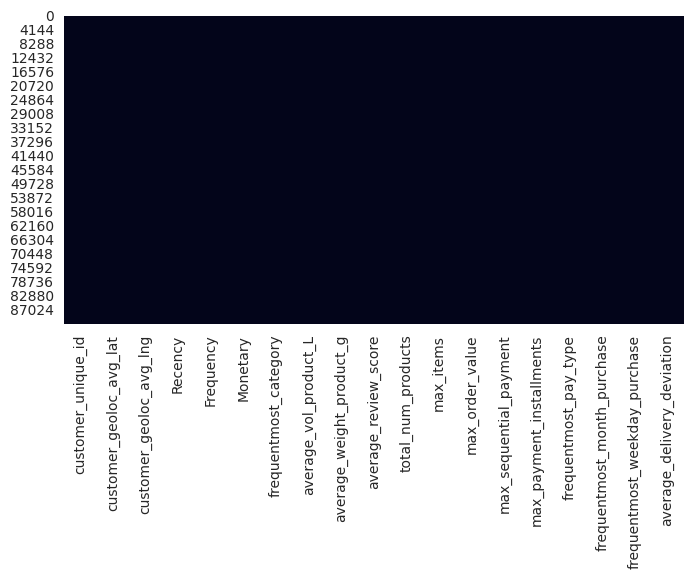

In [146]:
# ---------------------
# Missing values plot
# ---------------------
plt.figure(figsize=(8, 4))
sns.heatmap(df_customers.isnull(), cbar=False, cmap="rocket")
plt.show()

In [147]:
# --------------------
# Column description
# --------------------
complet_description(df_customers)

Variable     Type null Duplicated Filling percentage  \
0              customer_unique_id   object    0          0              100.0   
1     frequentmost_month_purchase   object    0      91148              100.0   
2           frequentmost_pay_type   object    0      91156              100.0   
3        max_payment_installments  float64    0      91136              100.0   
4          max_sequential_payment  float64    0      91141              100.0   
5                 max_order_value  float64    0      64469              100.0   
6                       max_items  float64    0      91143              100.0   
7              total_num_products    int64    0      91134              100.0   
8   frequentmost_weekday_purchase   object    0      91153              100.0   
9            average_review_score  float64    0      91097              100.0   
10          average_vol_product_L  float64    0      83774              100.0   
11          frequentmost_category   object    0      91141              100.0   
12                       Monetary  float64    0      63119              100.0   
13                      Frequency    int64    0      91134              100.0   
14                        Recency    int64    0      90550              100.0   
15        customer_geoloc_avg_lng  float64    0      75820              100.0   
16        customer_geoloc_avg_lat  float64    0      75796              100.0   
17       average_weight_product_g  float64    0      87928              100.0   
18     average_delivery_deviation  float64    0      90698              100.0   

      count unique                               top   freq         mean  \
0     91160  91160  0000366f3b9a7992bf8c76cfdf3221e2      1          NaN   
1     91160     12                            August  10004          NaN   
2     91160      4                       credit_card  69784          NaN   
3   91160.0    NaN                               NaN    NaN     2.939447   
4   91160.0    NaN                               NaN    NaN     1.045535   
5   91160.0    NaN                               NaN    NaN   160.263073   
6   91160.0    NaN                               NaN    NaN     1.143846   
7   91160.0    NaN                               NaN    NaN     1.237516   
8     91160      7                            Monday  15040          NaN   
9   91160.0    NaN                               NaN    NaN     4.154468   
10  91160.0    NaN                               NaN    NaN    15.215101   
11    91160     19                           leisure  13582          NaN   
12  91160.0    NaN                               NaN    NaN   162.434928   
13  91160.0    NaN                               NaN    NaN     1.237516   
14  91160.0    NaN                               NaN    NaN   237.391169   
15  91160.0    NaN                               NaN    NaN   -46.191034   
16  91160.0    NaN                               NaN    NaN   -21.180163   
17  91160.0    NaN                               NaN    NaN  2102.278562   
18  91160.0    NaN                               NaN    NaN   -11.892437   

            std        min        25%        50%        75%        max  
0           NaN        NaN        NaN        NaN        NaN        NaN  
1           NaN        NaN        NaN        NaN        NaN        NaN  
2           NaN        NaN        NaN        NaN        NaN        NaN  
3      2.722856        0.0        1.0        2.0        4.0       24.0  
4      0.370183        1.0        1.0        1.0        1.0       26.0  
5    218.525266       4.07      61.75     105.16   177.4325   13664.08  
6      0.539073        1.0        1.0        1.0        1.0       21.0  
7      0.844672        1.0        1.0        1.0        1.0       75.0  
8           NaN        NaN        NaN        NaN        NaN        NaN  
9      1.279332        1.0        4.0        5.0        5.0        5.0  
10     23.15249      0.168      2.856        6.6       18.4    296.208  
11     